# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [1]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [3]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    stop_words = ["the", "and", "of", "a", "is", "over"]
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        sentence = list(filter(lambda x: not x in stop_words, sentence))
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if any(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████████████████████████| 255/255 [00:02<00:00, 109.16it/s]


In [4]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(str(index), f"<unk:{index}>")
    
    def index(self, word):
        return self.word2index.get(word, f"<unk:{word}>")
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

print(lang.n_words)
print(action_lang.n_words)
print(argument_lang.n_words)

#lang.add_sentence(["<SOS>", "<EOS>"])
#action_lang.add_sentence(["<SOS>", "<EOS>"])
#argument_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                    argument_lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                    argument_lang.add_word(instruction_arg_2)
                
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths
                    
sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))
print('max eval sentence length = %d words' % (max(eval_sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')
argument_lang.dump('argument_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))
print('number of arguments = ', argument_lang.n_words)

print(action_lang.index2word)
print(argument_lang.word2index)

 28%|████████████████████▋                                                      | 1816/6574 [00:00<00:00, 17980.23it/s]

2053
10
83


100%|█████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 13421.01it/s]

average sentence length = 6.92 words
max eval sentence length = 22 words
vocab size = 2053
most common words:  [('to', 98305), ('turn', 72887), ('on', 56709), ('right', 44577), ('left', 43432), ('in', 38055), ('up', 32122), ('walk', 30867), ('put', 28952), ('table', 28084)]
most common actions:  [('GotoLocation', 70355), ('PickupObject', 31968), ('PutObject', 29426), ('SliceObject', 3152), ('HeatObject', 3079), ('CoolObject', 3059), ('CleanObject', 2955), ('ToggleObject', 2424), ('<SOS>', 0), ('<EOS>', 0)]
number of arguments =  83
{'0': 'GotoLocation', '1': 'PickupObject', '2': 'ToggleObject', '3': 'PutObject', '4': 'SliceObject', '5': 'CleanObject', '6': 'CoolObject', '7': 'HeatObject', '8': '<SOS>', '9': '<EOS>'}
{'dresser': 0, 'alarmclock': 1, 'desklamp': 2, 'desk': 3, 'shelf': 4, 'sidetable': 5, 'baseballbat': 6, 'basketball': 7, 'book': 8, 'bed': 9, 'bowl': 10, 'sofa': 11, 'box': 12, 'coffeetable': 13, 'diningtable': 14, 'floorlamp': 15, 'candle': 16, 'cd': 17, 'drawer': 18, 'gar

In [5]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                train_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action / argument pairs =', len(train_low_action_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                eval_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action / argument pairs =', len(eval_low_action_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    #indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_argument_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, [rpair[0], rpair[1]]))

100%|█████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 36428.73it/s]


train reconstruction samples = 162303
train high -> low pairs = 141278
train low -> action / argument pairs = 141278
eval reconstruction samples = 5961
eval high -> low pairs = 5140
eval low -> action / argument pairs = 5140
using device: cuda
[['pick', 'up', 'candle', 'on', 'top', 'toilet'], ['PickupObject'], ['candle']]
(tensor([[  0],
        [  1],
        [408],
        [  5],
        [ 23],
        [825]], device='cuda:0'), tensor([[1]], device='cuda:0'))


# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 10

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class ActionPredictor(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(ActionPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input):
        output = F.relu(self.linear1(input))
        output = self.dropout(output)
        output = F.log_softmax(self.linear2(output), dim=0)
        return output

class ArgumentPredictor(nn.Module):
    def __init__(self, input_size, output_size, dropout_p=0.1):
        super(ArgumentPredictor, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        
        self.linear1 = nn.Linear(self.input_size, 512)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear2 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, self.output_size)
    
    def forward(self, input):
        output = F.relu(self.linear1(input))
        output = self.dropout(output)
        output = F.log_softmax(self.linear2(output), dim=0)
        return output

# Train - Action Predictor

updates:  1035470
0m 0s (- 97m 50s) (100 0%) 2.0041
0m 1s (- 92m 18s) (200 0%) 1.5350
0m 1s (- 90m 58s) (300 0%) 1.1134
0m 2s (- 89m 26s) (400 0%) 0.8320
0m 2s (- 88m 31s) (500 0%) 0.9161
0m 3s (- 88m 30s) (600 0%) 0.8496
0m 3s (- 87m 54s) (700 0%) 0.5892
0m 4s (- 87m 32s) (800 0%) 0.4686
0m 4s (- 87m 2s) (900 0%) 0.3266
0m 5s (- 86m 19s) (1000 0%) 0.4360
0m 5s (- 86m 25s) (1100 0%) 0.3692
0m 6s (- 86m 39s) (1200 0%) 0.3342
0m 6s (- 86m 37s) (1300 0%) 0.2902
0m 7s (- 86m 58s) (1400 0%) 0.2478
0m 7s (- 86m 33s) (1500 0%) 0.2515
0m 8s (- 86m 14s) (1600 0%) 0.1868
0m 8s (- 86m 11s) (1700 0%) 0.1222
0m 9s (- 86m 15s) (1800 0%) 0.1764
0m 9s (- 86m 19s) (1900 0%) 0.2125
0m 10s (- 86m 12s) (2000 0%) 0.2803
0m 10s (- 86m 8s) (2100 0%) 0.1778
0m 10s (- 86m 5s) (2200 0%) 0.2442
0m 11s (- 86m 6s) (2300 0%) 0.2121
0m 12s (- 86m 13s) (2400 0%) 0.1706
0m 12s (- 86m 12s) (2500 0%) 0.1079
0m 13s (- 86m 19s) (2600 0%) 0.1883
0m 13s (- 86m 28s) (2700 0%) 0.1322
0m 14s (- 86m 39s) (2800 0%) 0.1586
0m 14s

1m 57s (- 87m 30s) (22700 2%) 0.0515
1m 58s (- 87m 29s) (22800 2%) 0.1732
1m 58s (- 87m 30s) (22900 2%) 0.0155
1m 59s (- 87m 28s) (23000 2%) 0.1033
1m 59s (- 87m 27s) (23100 2%) 0.0816
2m 0s (- 87m 27s) (23200 2%) 0.1197
2m 0s (- 87m 26s) (23300 2%) 0.0295
2m 1s (- 87m 25s) (23400 2%) 0.1546
2m 1s (- 87m 24s) (23500 2%) 0.1515
2m 2s (- 87m 22s) (23600 2%) 0.1756
2m 2s (- 87m 23s) (23700 2%) 0.0149
2m 3s (- 87m 23s) (23800 2%) 0.2088
2m 3s (- 87m 25s) (23900 2%) 0.0306
2m 4s (- 87m 24s) (24000 2%) 0.1438
2m 4s (- 87m 25s) (24100 2%) 0.2229
2m 5s (- 87m 24s) (24200 2%) 0.1336
2m 6s (- 87m 23s) (24300 2%) 0.0734
2m 6s (- 87m 22s) (24400 2%) 0.3120
2m 7s (- 87m 22s) (24500 2%) 0.1685
2m 7s (- 87m 22s) (24600 2%) 0.0243
2m 8s (- 87m 20s) (24700 2%) 0.0573
2m 8s (- 87m 19s) (24800 2%) 0.0225
2m 9s (- 87m 17s) (24900 2%) 0.3112
2m 9s (- 87m 18s) (25000 2%) 0.0741
2m 10s (- 87m 17s) (25100 2%) 0.0224
2m 10s (- 87m 15s) (25200 2%) 0.0105
2m 11s (- 87m 13s) (25300 2%) 0.3707
2m 11s (- 87m 12s) (

3m 52s (- 84m 55s) (45100 4%) 0.1407
3m 52s (- 84m 54s) (45200 4%) 0.1806
3m 53s (- 84m 54s) (45300 4%) 0.3377
3m 53s (- 84m 54s) (45400 4%) 0.1690
3m 54s (- 84m 53s) (45500 4%) 0.0930
3m 54s (- 84m 53s) (45600 4%) 0.0973
3m 55s (- 84m 53s) (45700 4%) 0.1115
3m 55s (- 84m 53s) (45800 4%) 0.0847
3m 56s (- 84m 53s) (45900 4%) 0.0797
3m 56s (- 84m 52s) (46000 4%) 0.2154
3m 57s (- 84m 52s) (46100 4%) 0.0780
3m 57s (- 84m 51s) (46200 4%) 0.0835
3m 58s (- 84m 50s) (46300 4%) 0.1936
3m 58s (- 84m 49s) (46400 4%) 0.1203
3m 59s (- 84m 48s) (46500 4%) 0.0983
3m 59s (- 84m 47s) (46600 4%) 0.0744
4m 0s (- 84m 47s) (46700 4%) 0.0182
4m 0s (- 84m 46s) (46800 4%) 0.0619
4m 1s (- 84m 45s) (46900 4%) 0.1201
4m 1s (- 84m 44s) (47000 4%) 0.0550
4m 2s (- 84m 43s) (47100 4%) 0.0409
4m 2s (- 84m 43s) (47200 4%) 0.1923
4m 3s (- 84m 42s) (47300 4%) 0.2315
4m 3s (- 84m 41s) (47400 4%) 0.0357
4m 4s (- 84m 40s) (47500 4%) 0.0980
4m 4s (- 84m 39s) (47600 4%) 0.0465
4m 5s (- 84m 39s) (47700 4%) 0.1713
4m 5s (- 84m

5m 45s (- 82m 29s) (67500 6%) 0.0829
5m 45s (- 82m 28s) (67600 6%) 0.2790
5m 46s (- 82m 27s) (67700 6%) 0.0606
5m 46s (- 82m 26s) (67800 6%) 0.0899
5m 47s (- 82m 25s) (67900 6%) 0.0581
5m 47s (- 82m 24s) (68000 6%) 0.1157
5m 48s (- 82m 24s) (68100 6%) 0.1266
5m 48s (- 82m 23s) (68200 6%) 0.0580
5m 49s (- 82m 22s) (68300 6%) 0.1045
5m 49s (- 82m 22s) (68400 6%) 0.2049
5m 50s (- 82m 21s) (68500 6%) 0.0634
5m 50s (- 82m 20s) (68600 6%) 0.0424
5m 51s (- 82m 19s) (68700 6%) 0.2042
5m 51s (- 82m 18s) (68800 6%) 0.4999
5m 51s (- 82m 17s) (68900 6%) 0.0614
5m 52s (- 82m 16s) (69000 6%) 0.0927
5m 52s (- 82m 15s) (69100 6%) 0.0612
5m 53s (- 82m 15s) (69200 6%) 0.0654
5m 53s (- 82m 14s) (69300 6%) 0.0895
5m 54s (- 82m 13s) (69400 6%) 0.0376
5m 54s (- 82m 13s) (69500 6%) 0.0331
5m 55s (- 82m 12s) (69600 6%) 0.1543
5m 55s (- 82m 11s) (69700 6%) 0.0575
5m 56s (- 82m 10s) (69800 6%) 0.0436
5m 56s (- 82m 9s) (69900 6%) 0.4975
5m 57s (- 82m 8s) (70000 6%) 0.0566
5m 57s (- 82m 7s) (70100 6%) 0.0500
5m 5

7m 39s (- 80m 36s) (89900 8%) 0.0296
7m 40s (- 80m 36s) (90000 8%) 0.0195
7m 40s (- 80m 35s) (90100 8%) 0.0352
7m 41s (- 80m 34s) (90200 8%) 0.0189
7m 41s (- 80m 34s) (90300 8%) 0.0155
7m 42s (- 80m 33s) (90400 8%) 0.0150
7m 42s (- 80m 33s) (90500 8%) 0.1060
7m 43s (- 80m 33s) (90600 8%) 0.0947
7m 44s (- 80m 33s) (90700 8%) 0.0607
7m 44s (- 80m 32s) (90800 8%) 0.0269
7m 45s (- 80m 32s) (90900 8%) 0.0986
7m 45s (- 80m 32s) (91000 8%) 0.0121
7m 46s (- 80m 32s) (91100 8%) 0.0102
7m 46s (- 80m 31s) (91200 8%) 0.0264
7m 47s (- 80m 31s) (91300 8%) 0.0348
7m 47s (- 80m 31s) (91400 8%) 0.0116
7m 48s (- 80m 30s) (91500 8%) 0.0368
7m 48s (- 80m 30s) (91600 8%) 0.1330
7m 49s (- 80m 30s) (91700 8%) 0.2896
7m 49s (- 80m 30s) (91800 8%) 0.1605
7m 50s (- 80m 29s) (91900 8%) 0.0154
7m 50s (- 80m 29s) (92000 8%) 0.1147
7m 51s (- 80m 28s) (92100 8%) 0.1222
7m 51s (- 80m 27s) (92200 8%) 0.0094
7m 52s (- 80m 26s) (92300 8%) 0.0361
7m 52s (- 80m 26s) (92400 8%) 0.1516
7m 53s (- 80m 26s) (92500 8%) 0.0076
7

9m 36s (- 79m 30s) (111700 10%) 0.0088
9m 37s (- 79m 30s) (111800 10%) 0.0155
9m 37s (- 79m 30s) (111900 10%) 0.0021
9m 38s (- 79m 30s) (112000 10%) 0.0593
9m 39s (- 79m 29s) (112100 10%) 0.0040
9m 39s (- 79m 29s) (112200 10%) 0.0079
9m 40s (- 79m 29s) (112300 10%) 0.0145
9m 40s (- 79m 29s) (112400 10%) 0.0297
9m 41s (- 79m 29s) (112500 10%) 0.0097
9m 41s (- 79m 29s) (112600 10%) 0.0400
9m 42s (- 79m 28s) (112700 10%) 0.0106
9m 43s (- 79m 28s) (112800 10%) 0.1639
9m 43s (- 79m 28s) (112900 10%) 0.0245
9m 44s (- 79m 29s) (113000 10%) 0.0195
9m 44s (- 79m 29s) (113100 10%) 0.0745
9m 45s (- 79m 29s) (113200 10%) 0.0127
9m 45s (- 79m 28s) (113300 10%) 0.0105
9m 46s (- 79m 29s) (113400 10%) 0.0090
9m 47s (- 79m 28s) (113500 10%) 0.0424
9m 47s (- 79m 28s) (113600 10%) 0.0521
9m 48s (- 79m 28s) (113700 10%) 0.0289
9m 48s (- 79m 28s) (113800 10%) 0.0562
9m 49s (- 79m 28s) (113900 10%) 0.0162
9m 49s (- 79m 28s) (114000 11%) 0.0076
9m 50s (- 79m 28s) (114100 11%) 0.0293
9m 51s (- 79m 28s) (11420

11m 32s (- 78m 37s) (132500 12%) 0.0166
11m 32s (- 78m 36s) (132600 12%) 0.0419
11m 33s (- 78m 36s) (132700 12%) 0.0427
11m 33s (- 78m 36s) (132800 12%) 0.1473
11m 34s (- 78m 35s) (132900 12%) 0.0250
11m 34s (- 78m 34s) (133000 12%) 0.0255
11m 35s (- 78m 34s) (133100 12%) 0.0146
11m 35s (- 78m 34s) (133200 12%) 0.0149
11m 36s (- 78m 33s) (133300 12%) 0.0128
11m 37s (- 78m 33s) (133400 12%) 0.0065
11m 37s (- 78m 33s) (133500 12%) 0.0196
11m 38s (- 78m 32s) (133600 12%) 0.0079
11m 38s (- 78m 32s) (133700 12%) 0.0064
11m 39s (- 78m 32s) (133800 12%) 0.0101
11m 39s (- 78m 31s) (133900 12%) 0.0050
11m 40s (- 78m 31s) (134000 12%) 0.0170
11m 40s (- 78m 30s) (134100 12%) 0.2807
11m 41s (- 78m 30s) (134200 12%) 0.0207
11m 41s (- 78m 30s) (134300 12%) 0.0108
11m 42s (- 78m 29s) (134400 12%) 0.0071
11m 42s (- 78m 29s) (134500 12%) 0.0055
11m 43s (- 78m 28s) (134600 12%) 0.0293
11m 44s (- 78m 28s) (134700 13%) 0.0054
11m 44s (- 78m 28s) (134800 13%) 0.0069
11m 45s (- 78m 27s) (134900 13%) 0.0096


13m 19s (- 76m 45s) (153200 14%) 0.0664
13m 20s (- 76m 44s) (153300 14%) 0.0737
13m 20s (- 76m 44s) (153400 14%) 0.2512
13m 21s (- 76m 44s) (153500 14%) 0.0842
13m 21s (- 76m 43s) (153600 14%) 0.0621
13m 22s (- 76m 43s) (153700 14%) 0.5406
13m 22s (- 76m 43s) (153800 14%) 0.0577
13m 23s (- 76m 42s) (153900 14%) 0.1016
13m 24s (- 76m 42s) (154000 14%) 0.0289
13m 24s (- 76m 42s) (154100 14%) 0.0291
13m 25s (- 76m 41s) (154200 14%) 0.1068
13m 25s (- 76m 41s) (154300 14%) 0.0197
13m 26s (- 76m 41s) (154400 14%) 0.0224
13m 26s (- 76m 40s) (154500 14%) 0.0321
13m 27s (- 76m 40s) (154600 14%) 0.0264
13m 28s (- 76m 40s) (154700 14%) 0.0136
13m 28s (- 76m 40s) (154800 14%) 0.0141
13m 29s (- 76m 39s) (154900 14%) 0.0725
13m 29s (- 76m 39s) (155000 14%) 0.0465
13m 30s (- 76m 38s) (155100 14%) 0.2588
13m 30s (- 76m 38s) (155200 14%) 0.0440
13m 31s (- 76m 38s) (155300 14%) 0.4508
13m 31s (- 76m 37s) (155400 15%) 0.0329
13m 32s (- 76m 37s) (155500 15%) 0.0241
13m 32s (- 76m 36s) (155600 15%) 0.0324


15m 8s (- 75m 1s) (173900 16%) 0.3992
15m 9s (- 75m 0s) (174000 16%) 0.0300
15m 9s (- 75m 0s) (174100 16%) 0.0318
15m 10s (- 75m 0s) (174200 16%) 0.0361
15m 10s (- 74m 59s) (174300 16%) 0.0466
15m 11s (- 74m 59s) (174400 16%) 0.0427
15m 11s (- 74m 58s) (174500 16%) 0.1729
15m 12s (- 74m 58s) (174600 16%) 0.0223
15m 12s (- 74m 57s) (174700 16%) 0.0566
15m 13s (- 74m 57s) (174800 16%) 0.0197
15m 14s (- 74m 57s) (174900 16%) 0.0371
15m 14s (- 74m 56s) (175000 16%) 0.0399
15m 15s (- 74m 56s) (175100 16%) 0.0978
15m 15s (- 74m 55s) (175200 16%) 0.0301
15m 16s (- 74m 55s) (175300 16%) 0.0151
15m 16s (- 74m 54s) (175400 16%) 0.0535
15m 17s (- 74m 54s) (175500 16%) 0.0496
15m 17s (- 74m 53s) (175600 16%) 0.0100
15m 18s (- 74m 52s) (175700 16%) 0.0471
15m 18s (- 74m 52s) (175800 16%) 0.0113
15m 19s (- 74m 51s) (175900 16%) 0.0585
15m 19s (- 74m 51s) (176000 16%) 0.0167
15m 20s (- 74m 50s) (176100 17%) 0.0268
15m 20s (- 74m 49s) (176200 17%) 0.0138
15m 21s (- 74m 49s) (176300 17%) 0.0513
15m 21s

16m 59s (- 73m 26s) (194600 18%) 0.0063
17m 0s (- 73m 25s) (194700 18%) 0.0142
17m 0s (- 73m 25s) (194800 18%) 0.0309
17m 1s (- 73m 24s) (194900 18%) 0.0226
17m 1s (- 73m 24s) (195000 18%) 0.0344
17m 2s (- 73m 23s) (195100 18%) 0.1120
17m 2s (- 73m 23s) (195200 18%) 0.0229
17m 3s (- 73m 23s) (195300 18%) 0.2547
17m 4s (- 73m 22s) (195400 18%) 0.0878
17m 4s (- 73m 22s) (195500 18%) 0.1006
17m 5s (- 73m 21s) (195600 18%) 0.1105
17m 5s (- 73m 21s) (195700 18%) 0.0053
17m 6s (- 73m 20s) (195800 18%) 0.0230
17m 6s (- 73m 19s) (195900 18%) 0.1009
17m 7s (- 73m 19s) (196000 18%) 0.0210
17m 7s (- 73m 19s) (196100 18%) 0.0037
17m 8s (- 73m 19s) (196200 18%) 0.0037
17m 8s (- 73m 18s) (196300 18%) 0.0035
17m 9s (- 73m 18s) (196400 18%) 0.0219
17m 10s (- 73m 17s) (196500 18%) 0.1099
17m 10s (- 73m 17s) (196600 18%) 0.0008
17m 11s (- 73m 16s) (196700 18%) 0.0027
17m 11s (- 73m 16s) (196800 19%) 0.0187
17m 12s (- 73m 16s) (196900 19%) 0.0177
17m 12s (- 73m 15s) (197000 19%) 0.0197
17m 13s (- 73m 15s

18m 51s (- 71m 50s) (215300 20%) 0.0106
18m 52s (- 71m 49s) (215400 20%) 0.0034
18m 52s (- 71m 49s) (215500 20%) 0.0499
18m 53s (- 71m 49s) (215600 20%) 0.0020
18m 53s (- 71m 48s) (215700 20%) 0.0051
18m 54s (- 71m 48s) (215800 20%) 0.0098
18m 54s (- 71m 47s) (215900 20%) 0.0179
18m 55s (- 71m 47s) (216000 20%) 0.0431
18m 55s (- 71m 47s) (216100 20%) 0.0492
18m 56s (- 71m 46s) (216200 20%) 0.0101
18m 57s (- 71m 46s) (216300 20%) 0.1206
18m 57s (- 71m 45s) (216400 20%) 0.0236
18m 58s (- 71m 45s) (216500 20%) 0.0204
18m 58s (- 71m 45s) (216600 20%) 0.0568
18m 59s (- 71m 45s) (216700 20%) 0.0101
18m 59s (- 71m 44s) (216800 20%) 0.0087
19m 0s (- 71m 44s) (216900 20%) 0.0104
19m 1s (- 71m 44s) (217000 20%) 0.0077
19m 1s (- 71m 43s) (217100 20%) 0.0285
19m 2s (- 71m 43s) (217200 20%) 0.0516
19m 2s (- 71m 42s) (217300 20%) 0.0663
19m 3s (- 71m 42s) (217400 20%) 0.0336
19m 3s (- 71m 41s) (217500 21%) 0.0084
19m 4s (- 71m 41s) (217600 21%) 0.0044
19m 5s (- 71m 41s) (217700 21%) 0.0301
19m 5s (-

20m 47s (- 70m 27s) (236000 22%) 0.0266
20m 48s (- 70m 27s) (236100 22%) 0.0186
20m 49s (- 70m 26s) (236200 22%) 0.0516
20m 49s (- 70m 26s) (236300 22%) 0.1388
20m 50s (- 70m 25s) (236400 22%) 0.0074
20m 50s (- 70m 24s) (236500 22%) 0.0255
20m 51s (- 70m 24s) (236600 22%) 0.0188
20m 51s (- 70m 23s) (236700 22%) 0.0146
20m 52s (- 70m 23s) (236800 22%) 0.0121
20m 52s (- 70m 23s) (236900 22%) 0.0054
20m 53s (- 70m 22s) (237000 22%) 0.0153
20m 53s (- 70m 22s) (237100 22%) 0.0080
20m 54s (- 70m 21s) (237200 22%) 0.0068
20m 54s (- 70m 21s) (237300 22%) 0.0084
20m 55s (- 70m 20s) (237400 22%) 0.0024
20m 56s (- 70m 20s) (237500 22%) 0.0119
20m 56s (- 70m 19s) (237600 22%) 0.0153
20m 57s (- 70m 19s) (237700 22%) 0.2528
20m 57s (- 70m 18s) (237800 22%) 0.0076
20m 58s (- 70m 18s) (237900 22%) 0.0043
20m 58s (- 70m 17s) (238000 22%) 0.0081
20m 59s (- 70m 17s) (238100 22%) 0.0233
20m 59s (- 70m 16s) (238200 23%) 0.0065
21m 0s (- 70m 16s) (238300 23%) 0.0076
21m 0s (- 70m 15s) (238400 23%) 0.0044
21

22m 38s (- 68m 39s) (256700 24%) 0.0275
22m 38s (- 68m 39s) (256800 24%) 0.0925
22m 39s (- 68m 38s) (256900 24%) 0.0347
22m 39s (- 68m 38s) (257000 24%) 0.2692
22m 40s (- 68m 37s) (257100 24%) 0.0275
22m 40s (- 68m 36s) (257200 24%) 0.0795
22m 41s (- 68m 36s) (257300 24%) 0.4552
22m 41s (- 68m 35s) (257400 24%) 0.0523
22m 42s (- 68m 35s) (257500 24%) 0.0528
22m 42s (- 68m 34s) (257600 24%) 0.0130
22m 43s (- 68m 34s) (257700 24%) 0.0883
22m 43s (- 68m 33s) (257800 24%) 0.0368
22m 44s (- 68m 33s) (257900 24%) 0.0230
22m 44s (- 68m 32s) (258000 24%) 0.0216
22m 45s (- 68m 32s) (258100 24%) 0.0281
22m 45s (- 68m 31s) (258200 24%) 0.0160
22m 46s (- 68m 31s) (258300 24%) 0.0139
22m 46s (- 68m 30s) (258400 24%) 0.0093
22m 47s (- 68m 30s) (258500 24%) 0.0772
22m 47s (- 68m 29s) (258600 24%) 0.2314
22m 48s (- 68m 28s) (258700 24%) 0.0761
22m 48s (- 68m 28s) (258800 24%) 0.0498
22m 49s (- 68m 27s) (258900 25%) 0.3606
22m 49s (- 68m 27s) (259000 25%) 0.0299
22m 50s (- 68m 26s) (259100 25%) 0.0167


24m 28s (- 66m 54s) (277400 26%) 0.3728
24m 29s (- 66m 53s) (277500 26%) 0.0188
24m 30s (- 66m 53s) (277600 26%) 0.0188
24m 30s (- 66m 52s) (277700 26%) 0.0322
24m 31s (- 66m 52s) (277800 26%) 0.0237
24m 31s (- 66m 51s) (277900 26%) 0.0649
24m 32s (- 66m 51s) (278000 26%) 0.0757
24m 32s (- 66m 50s) (278100 26%) 0.1052
24m 33s (- 66m 50s) (278200 26%) 0.0455
24m 33s (- 66m 49s) (278300 26%) 0.0261
24m 34s (- 66m 49s) (278400 26%) 0.0243
24m 34s (- 66m 48s) (278500 26%) 0.0149
24m 35s (- 66m 48s) (278600 26%) 0.0518
24m 36s (- 66m 47s) (278700 26%) 0.0797
24m 36s (- 66m 47s) (278800 26%) 0.0185
24m 37s (- 66m 46s) (278900 26%) 0.0430
24m 37s (- 66m 46s) (279000 26%) 0.0039
24m 38s (- 66m 45s) (279100 26%) 0.0414
24m 38s (- 66m 45s) (279200 26%) 0.0298
24m 39s (- 66m 44s) (279300 26%) 0.0205
24m 39s (- 66m 44s) (279400 26%) 0.0065
24m 40s (- 66m 43s) (279500 26%) 0.0557
24m 40s (- 66m 43s) (279600 27%) 0.0152
24m 41s (- 66m 42s) (279700 27%) 0.0096
24m 41s (- 66m 42s) (279800 27%) 0.0455


26m 19s (- 65m 6s) (298100 28%) 0.0115
26m 19s (- 65m 6s) (298200 28%) 0.0081
26m 20s (- 65m 5s) (298300 28%) 0.0101
26m 20s (- 65m 5s) (298400 28%) 0.0252
26m 21s (- 65m 4s) (298500 28%) 0.0080
26m 21s (- 65m 3s) (298600 28%) 0.0229
26m 22s (- 65m 3s) (298700 28%) 0.1181
26m 23s (- 65m 3s) (298800 28%) 0.2492
26m 23s (- 65m 2s) (298900 28%) 0.1171
26m 24s (- 65m 2s) (299000 28%) 0.0191
26m 24s (- 65m 1s) (299100 28%) 0.0855
26m 25s (- 65m 0s) (299200 28%) 0.1232
26m 25s (- 65m 0s) (299300 28%) 0.0028
26m 26s (- 64m 59s) (299400 28%) 0.0430
26m 26s (- 64m 59s) (299500 28%) 0.0782
26m 27s (- 64m 58s) (299600 28%) 0.0044
26m 27s (- 64m 58s) (299700 28%) 0.0031
26m 28s (- 64m 57s) (299800 28%) 0.0070
26m 28s (- 64m 57s) (299900 28%) 0.0025
26m 29s (- 64m 56s) (300000 28%) 0.1313
26m 29s (- 64m 56s) (300100 28%) 0.0007
26m 30s (- 64m 55s) (300200 28%) 0.0020
26m 31s (- 64m 55s) (300300 29%) 0.0030
26m 31s (- 64m 54s) (300400 29%) 0.0232
26m 32s (- 64m 54s) (300500 29%) 0.0165
26m 32s (- 64

28m 12s (- 63m 24s) (318800 30%) 0.0088
28m 12s (- 63m 24s) (318900 30%) 0.0121
28m 13s (- 63m 23s) (319000 30%) 0.0020
28m 14s (- 63m 23s) (319100 30%) 0.0537
28m 14s (- 63m 22s) (319200 30%) 0.0054
28m 15s (- 63m 22s) (319300 30%) 0.0088
28m 15s (- 63m 21s) (319400 30%) 0.0141
28m 16s (- 63m 21s) (319500 30%) 0.0432
28m 16s (- 63m 20s) (319600 30%) 0.0229
28m 17s (- 63m 20s) (319700 30%) 0.0326
28m 17s (- 63m 19s) (319800 30%) 0.0088
28m 18s (- 63m 19s) (319900 30%) 0.1139
28m 19s (- 63m 18s) (320000 30%) 0.0186
28m 19s (- 63m 18s) (320100 30%) 0.0542
28m 20s (- 63m 18s) (320200 30%) 0.0157
28m 20s (- 63m 17s) (320300 30%) 0.0135
28m 21s (- 63m 17s) (320400 30%) 0.0078
28m 22s (- 63m 16s) (320500 30%) 0.0053
28m 22s (- 63m 16s) (320600 30%) 0.0339
28m 23s (- 63m 15s) (320700 30%) 0.0370
28m 23s (- 63m 15s) (320800 30%) 0.0304
28m 24s (- 63m 15s) (320900 30%) 0.0513
28m 24s (- 63m 14s) (321000 31%) 0.0122
28m 25s (- 63m 14s) (321100 31%) 0.0032
28m 26s (- 63m 13s) (321200 31%) 0.0316


30m 8s (- 61m 47s) (339500 32%) 0.0442
30m 9s (- 61m 46s) (339600 32%) 0.0108
30m 9s (- 61m 46s) (339700 32%) 0.0248
30m 10s (- 61m 45s) (339800 32%) 0.0552
30m 10s (- 61m 45s) (339900 32%) 0.1086
30m 11s (- 61m 44s) (340000 32%) 0.0227
30m 11s (- 61m 44s) (340100 32%) 0.0227
30m 12s (- 61m 43s) (340200 32%) 0.0205
30m 12s (- 61m 43s) (340300 32%) 0.0126
30m 13s (- 61m 42s) (340400 32%) 0.0081
30m 13s (- 61m 42s) (340500 32%) 0.0030
30m 14s (- 61m 41s) (340600 32%) 0.0145
30m 14s (- 61m 41s) (340700 32%) 0.0055
30m 15s (- 61m 40s) (340800 32%) 0.0050
30m 16s (- 61m 40s) (340900 32%) 0.0085
30m 16s (- 61m 39s) (341000 32%) 0.0042
30m 17s (- 61m 39s) (341100 32%) 0.0185
30m 17s (- 61m 38s) (341200 32%) 0.2233
30m 18s (- 61m 38s) (341300 32%) 0.0183
30m 18s (- 61m 37s) (341400 32%) 0.0038
30m 19s (- 61m 37s) (341500 32%) 0.0100
30m 19s (- 61m 36s) (341600 32%) 0.0055
30m 20s (- 61m 36s) (341700 32%) 0.0213
30m 21s (- 61m 35s) (341800 33%) 0.0055
30m 21s (- 61m 35s) (341900 33%) 0.0042
30m

32m 0s (- 60m 0s) (360200 34%) 0.0369
32m 0s (- 59m 59s) (360300 34%) 0.0400
32m 1s (- 59m 59s) (360400 34%) 0.0499
32m 2s (- 59m 58s) (360500 34%) 0.2121
32m 2s (- 59m 58s) (360600 34%) 0.0785
32m 3s (- 59m 57s) (360700 34%) 0.0314
32m 3s (- 59m 57s) (360800 34%) 0.4527
32m 4s (- 59m 56s) (360900 34%) 0.0476
32m 4s (- 59m 56s) (361000 34%) 0.0504
32m 5s (- 59m 55s) (361100 34%) 0.0205
32m 5s (- 59m 55s) (361200 34%) 0.0221
32m 6s (- 59m 54s) (361300 34%) 0.0837
32m 6s (- 59m 54s) (361400 34%) 0.0190
32m 7s (- 59m 53s) (361500 34%) 0.0200
32m 8s (- 59m 53s) (361600 34%) 0.0230
32m 8s (- 59m 52s) (361700 34%) 0.0144
32m 9s (- 59m 52s) (361800 34%) 0.0091
32m 9s (- 59m 51s) (361900 34%) 0.0108
32m 10s (- 59m 51s) (362000 34%) 0.0861
32m 10s (- 59m 50s) (362100 34%) 0.0453
32m 11s (- 59m 49s) (362200 34%) 0.2470
32m 11s (- 59m 49s) (362300 34%) 0.0223
32m 12s (- 59m 48s) (362400 34%) 0.3264
32m 12s (- 59m 48s) (362500 35%) 0.0215
32m 13s (- 59m 47s) (362600 35%) 0.0154
32m 13s (- 59m 47s)

33m 50s (- 58m 9s) (380900 36%) 0.2830
33m 50s (- 58m 8s) (381000 36%) 0.0944
33m 51s (- 58m 7s) (381100 36%) 0.0202
33m 51s (- 58m 7s) (381200 36%) 0.0231
33m 52s (- 58m 6s) (381300 36%) 0.0302
33m 52s (- 58m 6s) (381400 36%) 0.0572
33m 53s (- 58m 5s) (381500 36%) 0.0173
33m 54s (- 58m 5s) (381600 36%) 0.1491
33m 54s (- 58m 4s) (381700 36%) 0.0142
33m 55s (- 58m 4s) (381800 36%) 0.0591
33m 55s (- 58m 3s) (381900 36%) 0.0161
33m 56s (- 58m 3s) (382000 36%) 0.0270
33m 56s (- 58m 3s) (382100 36%) 0.0329
33m 57s (- 58m 2s) (382200 36%) 0.0769
33m 58s (- 58m 2s) (382300 36%) 0.0155
33m 58s (- 58m 1s) (382400 36%) 0.0245
33m 59s (- 58m 1s) (382500 36%) 0.0181
33m 59s (- 58m 0s) (382600 36%) 0.0314
34m 0s (- 57m 59s) (382700 36%) 0.0099
34m 0s (- 57m 59s) (382800 36%) 0.0447
34m 1s (- 57m 58s) (382900 36%) 0.0055
34m 1s (- 57m 58s) (383000 36%) 0.0460
34m 2s (- 57m 57s) (383100 36%) 0.0152
34m 2s (- 57m 57s) (383200 37%) 0.0097
34m 3s (- 57m 56s) (383300 37%) 0.0053
34m 3s (- 57m 56s) (38340

35m 42s (- 56m 22s) (401600 38%) 0.0679
35m 43s (- 56m 21s) (401700 38%) 0.0061
35m 43s (- 56m 21s) (401800 38%) 0.0068
35m 44s (- 56m 20s) (401900 38%) 0.0143
35m 44s (- 56m 20s) (402000 38%) 0.0125
35m 45s (- 56m 19s) (402100 38%) 0.0223
35m 46s (- 56m 19s) (402200 38%) 0.0876
35m 46s (- 56m 18s) (402300 38%) 0.0170
35m 47s (- 56m 18s) (402400 38%) 0.2730
35m 47s (- 56m 17s) (402500 38%) 0.0740
35m 48s (- 56m 17s) (402600 38%) 0.1010
35m 48s (- 56m 16s) (402700 38%) 0.1158
35m 49s (- 56m 16s) (402800 38%) 0.0058
35m 49s (- 56m 15s) (402900 38%) 0.0219
35m 50s (- 56m 14s) (403000 38%) 0.0867
35m 51s (- 56m 14s) (403100 38%) 0.0148
35m 51s (- 56m 13s) (403200 38%) 0.0018
35m 52s (- 56m 13s) (403300 38%) 0.0036
35m 52s (- 56m 12s) (403400 38%) 0.0029
35m 53s (- 56m 12s) (403500 38%) 0.0094
35m 53s (- 56m 12s) (403600 38%) 0.1229
35m 54s (- 56m 11s) (403700 38%) 0.0006
35m 54s (- 56m 11s) (403800 38%) 0.0021
35m 55s (- 56m 10s) (403900 39%) 0.0260
35m 56s (- 56m 10s) (404000 39%) 0.0097


37m 34s (- 54m 33s) (422300 40%) 0.0064
37m 35s (- 54m 33s) (422400 40%) 0.0102
37m 35s (- 54m 32s) (422500 40%) 0.0018
37m 36s (- 54m 32s) (422600 40%) 0.0399
37m 36s (- 54m 31s) (422700 40%) 0.0038
37m 37s (- 54m 31s) (422800 40%) 0.0057
37m 37s (- 54m 30s) (422900 40%) 0.0070
37m 38s (- 54m 30s) (423000 40%) 0.0258
37m 39s (- 54m 29s) (423100 40%) 0.0411
37m 39s (- 54m 29s) (423200 40%) 0.0325
37m 40s (- 54m 28s) (423300 40%) 0.0076
37m 40s (- 54m 27s) (423400 40%) 0.1011
37m 41s (- 54m 27s) (423500 40%) 0.0336
37m 41s (- 54m 26s) (423600 40%) 0.0152
37m 42s (- 54m 26s) (423700 40%) 0.0430
37m 42s (- 54m 25s) (423800 40%) 0.0093
37m 43s (- 54m 25s) (423900 40%) 0.0083
37m 43s (- 54m 24s) (424000 40%) 0.0086
37m 44s (- 54m 24s) (424100 40%) 0.0087
37m 44s (- 54m 23s) (424200 40%) 0.0311
37m 45s (- 54m 23s) (424300 40%) 0.0278
37m 45s (- 54m 22s) (424400 40%) 0.0505
37m 46s (- 54m 21s) (424500 40%) 0.0274
37m 46s (- 54m 21s) (424600 41%) 0.0049
37m 47s (- 54m 20s) (424700 41%) 0.0047


39m 30s (- 52m 50s) (443000 42%) 0.2300
39m 31s (- 52m 50s) (443100 42%) 0.0233
39m 31s (- 52m 49s) (443200 42%) 0.0174
39m 32s (- 52m 49s) (443300 42%) 0.0349
39m 32s (- 52m 48s) (443400 42%) 0.1076
39m 33s (- 52m 47s) (443500 42%) 0.0062
39m 33s (- 52m 47s) (443600 42%) 0.0228
39m 34s (- 52m 46s) (443700 42%) 0.0213
39m 34s (- 52m 46s) (443800 42%) 0.0169
39m 35s (- 52m 45s) (443900 42%) 0.0093
39m 35s (- 52m 45s) (444000 42%) 0.0047
39m 36s (- 52m 44s) (444100 42%) 0.0110
39m 37s (- 52m 44s) (444200 42%) 0.0061
39m 37s (- 52m 43s) (444300 42%) 0.0074
39m 38s (- 52m 43s) (444400 42%) 0.0070
39m 38s (- 52m 42s) (444500 42%) 0.0026
39m 39s (- 52m 42s) (444600 42%) 0.0165
39m 39s (- 52m 41s) (444700 42%) 0.0139
39m 40s (- 52m 41s) (444800 42%) 0.2104
39m 40s (- 52m 40s) (444900 42%) 0.0052
39m 41s (- 52m 39s) (445000 42%) 0.0076
39m 42s (- 52m 39s) (445100 42%) 0.0100
39m 42s (- 52m 38s) (445200 42%) 0.0202
39m 43s (- 52m 38s) (445300 43%) 0.0066
39m 43s (- 52m 37s) (445400 43%) 0.0089


41m 22s (- 51m 1s) (463700 44%) 0.0782
41m 23s (- 51m 0s) (463800 44%) 0.0357
41m 23s (- 51m 0s) (463900 44%) 0.0586
41m 24s (- 50m 59s) (464000 44%) 0.0234
41m 24s (- 50m 59s) (464100 44%) 0.2524
41m 25s (- 50m 58s) (464200 44%) 0.0241
41m 25s (- 50m 58s) (464300 44%) 0.0682
41m 26s (- 50m 57s) (464400 44%) 0.3944
41m 26s (- 50m 56s) (464500 44%) 0.0448
41m 27s (- 50m 56s) (464600 44%) 0.0400
41m 28s (- 50m 55s) (464700 44%) 0.0097
41m 28s (- 50m 55s) (464800 44%) 0.0700
41m 29s (- 50m 54s) (464900 44%) 0.0240
41m 29s (- 50m 54s) (465000 44%) 0.0123
41m 30s (- 50m 53s) (465100 44%) 0.0154
41m 30s (- 50m 53s) (465200 44%) 0.0143
41m 31s (- 50m 52s) (465300 44%) 0.0111
41m 31s (- 50m 52s) (465400 44%) 0.0094
41m 32s (- 50m 51s) (465500 44%) 0.0061
41m 32s (- 50m 51s) (465600 44%) 0.0698
41m 33s (- 50m 50s) (465700 44%) 0.2189
41m 33s (- 50m 50s) (465800 44%) 0.0698
41m 34s (- 50m 49s) (465900 44%) 0.0392
41m 35s (- 50m 49s) (466000 45%) 0.3005
41m 35s (- 50m 48s) (466100 45%) 0.0251
41m

43m 12s (- 49m 9s) (484400 46%) 0.0147
43m 13s (- 49m 8s) (484500 46%) 0.3156
43m 13s (- 49m 8s) (484600 46%) 0.0242
43m 14s (- 49m 7s) (484700 46%) 0.0212
43m 14s (- 49m 7s) (484800 46%) 0.0366
43m 15s (- 49m 6s) (484900 46%) 0.0168
43m 15s (- 49m 6s) (485000 46%) 0.0556
43m 16s (- 49m 5s) (485100 46%) 0.0816
43m 16s (- 49m 5s) (485200 46%) 0.0674
43m 17s (- 49m 4s) (485300 46%) 0.0269
43m 18s (- 49m 4s) (485400 46%) 0.0244
43m 18s (- 49m 3s) (485500 46%) 0.0300
43m 19s (- 49m 3s) (485600 46%) 0.0199
43m 19s (- 49m 2s) (485700 46%) 0.0406
43m 20s (- 49m 2s) (485800 46%) 0.0672
43m 20s (- 49m 1s) (485900 46%) 0.0137
43m 21s (- 49m 0s) (486000 46%) 0.0237
43m 21s (- 49m 0s) (486100 46%) 0.0030
43m 22s (- 48m 59s) (486200 46%) 0.0419
43m 22s (- 48m 59s) (486300 46%) 0.0302
43m 23s (- 48m 58s) (486400 46%) 0.0132
43m 23s (- 48m 58s) (486500 46%) 0.0057
43m 24s (- 48m 57s) (486600 46%) 0.0536
43m 24s (- 48m 57s) (486700 47%) 0.0131
43m 25s (- 48m 56s) (486800 47%) 0.0062
43m 25s (- 48m 56s

45m 1s (- 47m 17s) (505100 48%) 0.0544
45m 2s (- 47m 16s) (505200 48%) 0.0079
45m 2s (- 47m 16s) (505300 48%) 0.0066
45m 3s (- 47m 15s) (505400 48%) 0.0077
45m 4s (- 47m 14s) (505500 48%) 0.0237
45m 4s (- 47m 14s) (505600 48%) 0.0080
45m 5s (- 47m 13s) (505700 48%) 0.0156
45m 5s (- 47m 13s) (505800 48%) 0.1058
45m 6s (- 47m 12s) (505900 48%) 0.2141
45m 6s (- 47m 12s) (506000 48%) 0.0980
45m 7s (- 47m 11s) (506100 48%) 0.0088
45m 7s (- 47m 11s) (506200 48%) 0.0847
45m 8s (- 47m 10s) (506300 48%) 0.1066
45m 8s (- 47m 9s) (506400 48%) 0.0034
45m 9s (- 47m 9s) (506500 48%) 0.0280
45m 9s (- 47m 8s) (506600 48%) 0.0680
45m 10s (- 47m 8s) (506700 48%) 0.0046
45m 10s (- 47m 7s) (506800 48%) 0.0017
45m 11s (- 47m 7s) (506900 48%) 0.0045
45m 12s (- 47m 6s) (507000 48%) 0.0074
45m 12s (- 47m 6s) (507100 48%) 0.1236
45m 13s (- 47m 5s) (507200 48%) 0.0011
45m 13s (- 47m 5s) (507300 48%) 0.0015
45m 14s (- 47m 4s) (507400 49%) 0.0018
45m 14s (- 47m 4s) (507500 49%) 0.0244
45m 15s (- 47m 3s) (507600 4

46m 50s (- 45m 24s) (525800 50%) 0.0026
46m 51s (- 45m 23s) (525900 50%) 0.0064
46m 51s (- 45m 23s) (526000 50%) 0.0170
46m 52s (- 45m 22s) (526100 50%) 0.0038
46m 52s (- 45m 22s) (526200 50%) 0.0388
46m 53s (- 45m 21s) (526300 50%) 0.0032
46m 53s (- 45m 21s) (526400 50%) 0.0068
46m 54s (- 45m 20s) (526500 50%) 0.0197
46m 54s (- 45m 20s) (526600 50%) 0.0576
46m 55s (- 45m 19s) (526700 50%) 0.0110
46m 55s (- 45m 18s) (526800 50%) 0.0237
46m 56s (- 45m 18s) (526900 50%) 0.0055
46m 56s (- 45m 17s) (527000 50%) 0.0913
46m 57s (- 45m 17s) (527100 50%) 0.0219
46m 58s (- 45m 16s) (527200 50%) 0.0471
46m 58s (- 45m 16s) (527300 50%) 0.0100
46m 59s (- 45m 15s) (527400 50%) 0.0095
46m 59s (- 45m 15s) (527500 50%) 0.0099
47m 0s (- 45m 14s) (527600 50%) 0.0041
47m 0s (- 45m 14s) (527700 50%) 0.0157
47m 1s (- 45m 13s) (527800 50%) 0.0338
47m 1s (- 45m 13s) (527900 50%) 0.0219
47m 2s (- 45m 12s) (528000 50%) 0.0620
47m 2s (- 45m 12s) (528100 51%) 0.0118
47m 3s (- 45m 11s) (528200 51%) 0.0047
47m 3s 

48m 40s (- 43m 33s) (546500 52%) 0.2006
48m 41s (- 43m 32s) (546600 52%) 0.0501
48m 41s (- 43m 32s) (546700 52%) 0.0121
48m 42s (- 43m 31s) (546800 52%) 0.0161
48m 42s (- 43m 31s) (546900 52%) 0.0789
48m 43s (- 43m 30s) (547000 52%) 0.0725
48m 43s (- 43m 30s) (547100 52%) 0.0194
48m 44s (- 43m 29s) (547200 52%) 0.0195
48m 44s (- 43m 28s) (547300 52%) 0.0140
48m 45s (- 43m 28s) (547400 52%) 0.0111
48m 46s (- 43m 27s) (547500 52%) 0.0050
48m 46s (- 43m 27s) (547600 52%) 0.0024
48m 47s (- 43m 26s) (547700 52%) 0.0096
48m 47s (- 43m 26s) (547800 52%) 0.0039
48m 48s (- 43m 25s) (547900 52%) 0.0044
48m 48s (- 43m 25s) (548000 52%) 0.0065
48m 49s (- 43m 24s) (548100 52%) 0.0127
48m 49s (- 43m 24s) (548200 52%) 0.0105
48m 50s (- 43m 23s) (548300 52%) 0.1816
48m 51s (- 43m 23s) (548400 52%) 0.0197
48m 51s (- 43m 22s) (548500 52%) 0.0040
48m 52s (- 43m 22s) (548600 52%) 0.0080
48m 52s (- 43m 21s) (548700 52%) 0.0063
48m 53s (- 43m 21s) (548800 53%) 0.0195
48m 53s (- 43m 20s) (548900 53%) 0.0060


50m 32s (- 41m 43s) (567200 54%) 0.0895
50m 32s (- 41m 42s) (567300 54%) 0.0230
50m 33s (- 41m 42s) (567400 54%) 0.0479
50m 33s (- 41m 41s) (567500 54%) 0.0394
50m 34s (- 41m 41s) (567600 54%) 0.1827
50m 34s (- 41m 40s) (567700 54%) 0.0591
50m 35s (- 41m 39s) (567800 54%) 0.0396
50m 35s (- 41m 39s) (567900 54%) 0.3869
50m 36s (- 41m 38s) (568000 54%) 0.0414
50m 36s (- 41m 38s) (568100 54%) 0.0527
50m 37s (- 41m 37s) (568200 54%) 0.0187
50m 38s (- 41m 37s) (568300 54%) 0.0110
50m 38s (- 41m 36s) (568400 54%) 0.0712
50m 39s (- 41m 36s) (568500 54%) 0.0174
50m 39s (- 41m 35s) (568600 54%) 0.0145
50m 40s (- 41m 35s) (568700 54%) 0.0140
50m 40s (- 41m 34s) (568800 54%) 0.0116
50m 41s (- 41m 34s) (568900 54%) 0.0074
50m 41s (- 41m 33s) (569000 54%) 0.0062
50m 42s (- 41m 33s) (569100 54%) 0.0753
50m 43s (- 41m 32s) (569200 54%) 0.0357
50m 43s (- 41m 32s) (569300 54%) 0.2214
50m 44s (- 41m 31s) (569400 54%) 0.0218
50m 44s (- 41m 31s) (569500 54%) 0.3140
50m 45s (- 41m 30s) (569600 55%) 0.0176


52m 21s (- 39m 51s) (587900 56%) 0.0691
52m 22s (- 39m 51s) (588000 56%) 0.3346
52m 22s (- 39m 50s) (588100 56%) 0.0100
52m 23s (- 39m 50s) (588200 56%) 0.0250
52m 23s (- 39m 49s) (588300 56%) 0.0204
52m 24s (- 39m 49s) (588400 56%) 0.0263
52m 24s (- 39m 48s) (588500 56%) 0.0381
52m 25s (- 39m 47s) (588600 56%) 0.0147
52m 25s (- 39m 47s) (588700 56%) 0.1416
52m 26s (- 39m 46s) (588800 56%) 0.0186
52m 26s (- 39m 46s) (588900 56%) 0.0301
52m 27s (- 39m 45s) (589000 56%) 0.0179
52m 27s (- 39m 45s) (589100 56%) 0.0253
52m 28s (- 39m 44s) (589200 56%) 0.0339
52m 28s (- 39m 44s) (589300 56%) 0.1108
52m 29s (- 39m 43s) (589400 56%) 0.0153
52m 29s (- 39m 43s) (589500 56%) 0.0200
52m 30s (- 39m 42s) (589600 56%) 0.0103
52m 31s (- 39m 41s) (589700 56%) 0.0266
52m 31s (- 39m 41s) (589800 56%) 0.0115
52m 32s (- 39m 40s) (589900 56%) 0.0322
52m 32s (- 39m 40s) (590000 56%) 0.0050
52m 33s (- 39m 39s) (590100 56%) 0.0514
52m 33s (- 39m 39s) (590200 56%) 0.0201
52m 34s (- 39m 38s) (590300 57%) 0.0118


54m 12s (- 38m 1s) (608600 58%) 0.0098
54m 13s (- 38m 0s) (608700 58%) 0.0510
54m 13s (- 38m 0s) (608800 58%) 0.0101
54m 14s (- 37m 59s) (608900 58%) 0.0055
54m 14s (- 37m 59s) (609000 58%) 0.0144
54m 15s (- 37m 58s) (609100 58%) 0.0112
54m 15s (- 37m 58s) (609200 58%) 0.0161
54m 16s (- 37m 57s) (609300 58%) 0.0909
54m 17s (- 37m 57s) (609400 58%) 0.0136
54m 17s (- 37m 56s) (609500 58%) 0.2959
54m 18s (- 37m 56s) (609600 58%) 0.0041
54m 18s (- 37m 55s) (609700 58%) 0.0851
54m 19s (- 37m 55s) (609800 58%) 0.1005
54m 19s (- 37m 54s) (609900 58%) 0.0041
54m 20s (- 37m 54s) (610000 58%) 0.0259
54m 20s (- 37m 53s) (610100 58%) 0.0637
54m 21s (- 37m 52s) (610200 58%) 0.0106
54m 21s (- 37m 52s) (610300 58%) 0.0022
54m 22s (- 37m 51s) (610400 58%) 0.0036
54m 23s (- 37m 51s) (610500 58%) 0.0023
54m 23s (- 37m 50s) (610600 58%) 0.0090
54m 24s (- 37m 50s) (610700 58%) 0.1105
54m 24s (- 37m 49s) (610800 58%) 0.0010
54m 25s (- 37m 49s) (610900 58%) 0.0029
54m 25s (- 37m 48s) (611000 59%) 0.0161
54m

56m 0s (- 36m 9s) (629200 60%) 0.0042
56m 1s (- 36m 9s) (629300 60%) 0.0034
56m 1s (- 36m 8s) (629400 60%) 0.0060
56m 2s (- 36m 8s) (629500 60%) 0.0123
56m 2s (- 36m 7s) (629600 60%) 0.0024
56m 3s (- 36m 7s) (629700 60%) 0.0427
56m 3s (- 36m 6s) (629800 60%) 0.0059
56m 4s (- 36m 6s) (629900 60%) 0.0028
56m 4s (- 36m 5s) (630000 60%) 0.0070
56m 5s (- 36m 5s) (630100 60%) 0.0322
56m 5s (- 36m 4s) (630200 60%) 0.0214
56m 6s (- 36m 4s) (630300 60%) 0.0245
56m 6s (- 36m 3s) (630400 60%) 0.0089
56m 7s (- 36m 2s) (630500 60%) 0.0823
56m 7s (- 36m 2s) (630600 60%) 0.0255
56m 8s (- 36m 1s) (630700 60%) 0.0160
56m 9s (- 36m 1s) (630800 60%) 0.0414
56m 9s (- 36m 0s) (630900 60%) 0.0088
56m 10s (- 36m 0s) (631000 60%) 0.0170
56m 10s (- 35m 59s) (631100 60%) 0.0077
56m 11s (- 35m 59s) (631200 60%) 0.0166
56m 11s (- 35m 58s) (631300 60%) 0.0283
56m 12s (- 35m 58s) (631400 60%) 0.0203
56m 12s (- 35m 57s) (631500 60%) 0.0516
56m 13s (- 35m 56s) (631600 60%) 0.0197
56m 13s (- 35m 56s) (631700 61%) 0.00

57m 48s (- 34m 17s) (649900 62%) 0.0193
57m 48s (- 34m 17s) (650000 62%) 0.0190
57m 49s (- 34m 16s) (650100 62%) 0.2117
57m 50s (- 34m 16s) (650200 62%) 0.0159
57m 50s (- 34m 15s) (650300 62%) 0.0167
57m 51s (- 34m 15s) (650400 62%) 0.0398
57m 51s (- 34m 14s) (650500 62%) 0.1048
57m 52s (- 34m 13s) (650600 62%) 0.0078
57m 52s (- 34m 13s) (650700 62%) 0.0219
57m 53s (- 34m 12s) (650800 62%) 0.0144
57m 53s (- 34m 12s) (650900 62%) 0.0141
57m 54s (- 34m 11s) (651000 62%) 0.0074
57m 54s (- 34m 11s) (651100 62%) 0.0039
57m 55s (- 34m 10s) (651200 62%) 0.0090
57m 55s (- 34m 10s) (651300 62%) 0.0050
57m 56s (- 34m 9s) (651400 62%) 0.0052
57m 56s (- 34m 9s) (651500 62%) 0.0096
57m 57s (- 34m 8s) (651600 62%) 0.0031
57m 57s (- 34m 7s) (651700 62%) 0.0191
57m 58s (- 34m 7s) (651800 62%) 0.0127
57m 58s (- 34m 6s) (651900 62%) 0.1790
57m 59s (- 34m 6s) (652000 62%) 0.0060
57m 59s (- 34m 5s) (652100 62%) 0.0037
58m 0s (- 34m 5s) (652200 62%) 0.0070
58m 0s (- 34m 4s) (652300 62%) 0.0118
58m 1s (- 34

59m 34s (- 32m 25s) (670600 64%) 0.0268
59m 35s (- 32m 24s) (670700 64%) 0.2424
59m 35s (- 32m 23s) (670800 64%) 0.0441
59m 36s (- 32m 23s) (670900 64%) 0.0411
59m 36s (- 32m 22s) (671000 64%) 0.0713
59m 37s (- 32m 22s) (671100 64%) 0.0236
59m 37s (- 32m 21s) (671200 64%) 0.2561
59m 38s (- 32m 21s) (671300 64%) 0.0209
59m 38s (- 32m 20s) (671400 64%) 0.0485
59m 39s (- 32m 20s) (671500 64%) 0.3547
59m 39s (- 32m 19s) (671600 64%) 0.0504
59m 40s (- 32m 19s) (671700 64%) 0.0357
59m 41s (- 32m 18s) (671800 64%) 0.0081
59m 41s (- 32m 18s) (671900 64%) 0.0530
59m 42s (- 32m 17s) (672000 64%) 0.0295
59m 42s (- 32m 16s) (672100 64%) 0.0245
59m 43s (- 32m 16s) (672200 64%) 0.0164
59m 43s (- 32m 15s) (672300 64%) 0.0075
59m 44s (- 32m 15s) (672400 64%) 0.0117
59m 44s (- 32m 14s) (672500 64%) 0.0103
59m 45s (- 32m 14s) (672600 64%) 0.0067
59m 45s (- 32m 13s) (672700 64%) 0.0607
59m 46s (- 32m 13s) (672800 64%) 0.2068
59m 46s (- 32m 12s) (672900 64%) 0.0538
59m 47s (- 32m 12s) (673000 64%) 0.0443


61m 19s (- 30m 31s) (691300 66%) 0.0279
61m 19s (- 30m 31s) (691400 66%) 0.0540
61m 20s (- 30m 30s) (691500 66%) 0.0155
61m 20s (- 30m 30s) (691600 66%) 0.3201
61m 21s (- 30m 29s) (691700 66%) 0.0162
61m 21s (- 30m 29s) (691800 66%) 0.0213
61m 22s (- 30m 28s) (691900 66%) 0.0349
61m 22s (- 30m 27s) (692000 66%) 0.0168
61m 23s (- 30m 27s) (692100 66%) 0.0372
61m 23s (- 30m 26s) (692200 66%) 0.0706
61m 24s (- 30m 26s) (692300 66%) 0.0908
61m 25s (- 30m 25s) (692400 66%) 0.0282
61m 25s (- 30m 25s) (692500 66%) 0.0170
61m 26s (- 30m 24s) (692600 66%) 0.0215
61m 26s (- 30m 24s) (692700 66%) 0.0125
61m 27s (- 30m 23s) (692800 66%) 0.0384
61m 27s (- 30m 23s) (692900 66%) 0.0521
61m 28s (- 30m 22s) (693000 66%) 0.0110
61m 28s (- 30m 22s) (693100 66%) 0.0177
61m 29s (- 30m 21s) (693200 66%) 0.0022
61m 29s (- 30m 20s) (693300 66%) 0.0309
61m 30s (- 30m 20s) (693400 66%) 0.0239
61m 30s (- 30m 19s) (693500 66%) 0.0147
61m 31s (- 30m 19s) (693600 66%) 0.0054
61m 31s (- 30m 18s) (693700 66%) 0.0541


63m 4s (- 28m 39s) (712000 68%) 0.0136
63m 4s (- 28m 38s) (712100 68%) 0.0091
63m 5s (- 28m 38s) (712200 68%) 0.0337
63m 5s (- 28m 37s) (712300 68%) 0.0046
63m 6s (- 28m 37s) (712400 68%) 0.0055
63m 6s (- 28m 36s) (712500 68%) 0.0101
63m 7s (- 28m 36s) (712600 68%) 0.0111
63m 8s (- 28m 35s) (712700 68%) 0.0055
63m 8s (- 28m 35s) (712800 68%) 0.0320
63m 9s (- 28m 34s) (712900 68%) 0.0777
63m 9s (- 28m 33s) (713000 68%) 0.1953
63m 10s (- 28m 33s) (713100 68%) 0.0996
63m 10s (- 28m 32s) (713200 68%) 0.0077
63m 11s (- 28m 32s) (713300 68%) 0.0753
63m 11s (- 28m 31s) (713400 68%) 0.0890
63m 12s (- 28m 31s) (713500 68%) 0.0042
63m 12s (- 28m 30s) (713600 68%) 0.0287
63m 13s (- 28m 30s) (713700 68%) 0.0608
63m 13s (- 28m 29s) (713800 68%) 0.0050
63m 14s (- 28m 29s) (713900 68%) 0.0030
63m 14s (- 28m 28s) (714000 68%) 0.0050
63m 15s (- 28m 27s) (714100 68%) 0.0037
63m 15s (- 28m 27s) (714200 68%) 0.1093
63m 16s (- 28m 26s) (714300 68%) 0.0008
63m 16s (- 28m 26s) (714400 68%) 0.0012
63m 17s (- 

64m 50s (- 26m 47s) (732700 70%) 0.0023
64m 51s (- 26m 47s) (732800 70%) 0.0031
64m 51s (- 26m 46s) (732900 70%) 0.0027
64m 52s (- 26m 46s) (733000 70%) 0.0067
64m 52s (- 26m 45s) (733100 70%) 0.0140
64m 53s (- 26m 45s) (733200 70%) 0.0293
64m 53s (- 26m 44s) (733300 70%) 0.0027
64m 54s (- 26m 44s) (733400 70%) 0.0030
64m 54s (- 26m 43s) (733500 70%) 0.0088
64m 55s (- 26m 42s) (733600 70%) 0.0088
64m 56s (- 26m 42s) (733700 70%) 0.0243
64m 56s (- 26m 41s) (733800 70%) 0.0085
64m 57s (- 26m 41s) (733900 70%) 0.0227
64m 57s (- 26m 40s) (734000 70%) 0.0786
64m 58s (- 26m 40s) (734100 70%) 0.0086
64m 58s (- 26m 39s) (734200 70%) 0.0225
64m 59s (- 26m 39s) (734300 70%) 0.0420
64m 59s (- 26m 38s) (734400 70%) 0.0166
65m 0s (- 26m 38s) (734500 70%) 0.0117
65m 0s (- 26m 37s) (734600 70%) 0.0075
65m 1s (- 26m 37s) (734700 70%) 0.0059
65m 1s (- 26m 36s) (734800 70%) 0.0212
65m 2s (- 26m 36s) (734900 70%) 0.0302
65m 2s (- 26m 35s) (735000 70%) 0.0095
65m 3s (- 26m 34s) (735100 70%) 0.0543
65m 3s 

66m 39s (- 24m 57s) (753400 72%) 0.0106
66m 39s (- 24m 56s) (753500 72%) 0.0195
66m 40s (- 24m 56s) (753600 72%) 0.1866
66m 40s (- 24m 55s) (753700 72%) 0.0310
66m 41s (- 24m 55s) (753800 72%) 0.0152
66m 41s (- 24m 54s) (753900 72%) 0.0117
66m 42s (- 24m 54s) (754000 72%) 0.0510
66m 42s (- 24m 53s) (754100 72%) 0.0725
66m 43s (- 24m 52s) (754200 72%) 0.0164
66m 43s (- 24m 52s) (754300 72%) 0.0139
66m 44s (- 24m 51s) (754400 72%) 0.0155
66m 44s (- 24m 51s) (754500 72%) 0.0114
66m 45s (- 24m 50s) (754600 72%) 0.0032
66m 45s (- 24m 50s) (754700 72%) 0.0070
66m 46s (- 24m 49s) (754800 72%) 0.0087
66m 46s (- 24m 49s) (754900 72%) 0.0048
66m 47s (- 24m 48s) (755000 72%) 0.0065
66m 47s (- 24m 48s) (755100 72%) 0.0025
66m 48s (- 24m 47s) (755200 72%) 0.0130
66m 48s (- 24m 46s) (755300 72%) 0.0138
66m 49s (- 24m 46s) (755400 72%) 0.1555
66m 49s (- 24m 45s) (755500 72%) 0.0179
66m 50s (- 24m 45s) (755600 72%) 0.0041
66m 50s (- 24m 44s) (755700 72%) 0.0045
66m 51s (- 24m 44s) (755800 72%) 0.0071


68m 24s (- 23m 5s) (774100 74%) 0.0221
68m 24s (- 23m 5s) (774200 74%) 0.1893
68m 24s (- 23m 4s) (774300 74%) 0.0758
68m 25s (- 23m 4s) (774400 74%) 0.0175
68m 25s (- 23m 3s) (774500 74%) 0.0588
68m 26s (- 23m 2s) (774600 74%) 0.0365
68m 26s (- 23m 2s) (774700 74%) 0.1794
68m 27s (- 23m 1s) (774800 74%) 0.0728
68m 27s (- 23m 1s) (774900 74%) 0.0334
68m 28s (- 23m 0s) (775000 74%) 0.3615
68m 28s (- 23m 0s) (775100 74%) 0.0459
68m 29s (- 22m 59s) (775200 74%) 0.0384
68m 29s (- 22m 59s) (775300 74%) 0.0199
68m 30s (- 22m 58s) (775400 74%) 0.0115
68m 31s (- 22m 58s) (775500 74%) 0.0602
68m 31s (- 22m 57s) (775600 74%) 0.0143
68m 32s (- 22m 57s) (775700 74%) 0.0175
68m 32s (- 22m 56s) (775800 74%) 0.0175
68m 33s (- 22m 55s) (775900 74%) 0.0127
68m 33s (- 22m 55s) (776000 74%) 0.0054
68m 34s (- 22m 54s) (776100 74%) 0.0042
68m 34s (- 22m 54s) (776200 74%) 0.0815
68m 35s (- 22m 53s) (776300 74%) 0.0252
68m 35s (- 22m 53s) (776400 74%) 0.2341
68m 36s (- 22m 52s) (776500 74%) 0.0149
68m 36s (- 

70m 8s (- 21m 14s) (794800 76%) 0.1634
70m 8s (- 21m 13s) (794900 76%) 0.0198
70m 9s (- 21m 13s) (795000 76%) 0.0717
70m 9s (- 21m 12s) (795100 76%) 0.3195
70m 10s (- 21m 12s) (795200 76%) 0.0110
70m 10s (- 21m 11s) (795300 76%) 0.0232
70m 11s (- 21m 11s) (795400 76%) 0.0330
70m 11s (- 21m 10s) (795500 76%) 0.0152
70m 12s (- 21m 10s) (795600 76%) 0.0510
70m 12s (- 21m 9s) (795700 76%) 0.0110
70m 13s (- 21m 8s) (795800 76%) 0.1526
70m 13s (- 21m 8s) (795900 76%) 0.0171
70m 14s (- 21m 7s) (796000 76%) 0.0245
70m 14s (- 21m 7s) (796100 76%) 0.0147
70m 15s (- 21m 6s) (796200 76%) 0.0306
70m 15s (- 21m 6s) (796300 76%) 0.0388
70m 16s (- 21m 5s) (796400 76%) 0.0653
70m 16s (- 21m 5s) (796500 76%) 0.0126
70m 17s (- 21m 4s) (796600 76%) 0.0180
70m 17s (- 21m 4s) (796700 76%) 0.0062
70m 18s (- 21m 3s) (796800 76%) 0.0596
70m 18s (- 21m 3s) (796900 76%) 0.0052
70m 19s (- 21m 2s) (797000 76%) 0.0329
70m 19s (- 21m 1s) (797100 76%) 0.0077
70m 20s (- 21m 1s) (797200 76%) 0.0468
70m 20s (- 21m 0s) (

71m 54s (- 19m 23s) (815500 78%) 0.0100
71m 54s (- 19m 23s) (815600 78%) 0.0181
71m 55s (- 19m 22s) (815700 78%) 0.0081
71m 55s (- 19m 22s) (815800 78%) 0.0379
71m 56s (- 19m 21s) (815900 78%) 0.0063
71m 56s (- 19m 21s) (816000 78%) 0.0049
71m 57s (- 19m 20s) (816100 78%) 0.0134
71m 57s (- 19m 19s) (816200 78%) 0.0090
71m 58s (- 19m 19s) (816300 78%) 0.0122
71m 58s (- 19m 18s) (816400 78%) 0.0762
71m 59s (- 19m 18s) (816500 78%) 0.0258
72m 0s (- 19m 17s) (816600 78%) 0.2675
72m 0s (- 19m 17s) (816700 78%) 0.0036
72m 1s (- 19m 16s) (816800 78%) 0.0743
72m 1s (- 19m 16s) (816900 78%) 0.0899
72m 2s (- 19m 15s) (817000 78%) 0.0026
72m 2s (- 19m 15s) (817100 78%) 0.0174
72m 2s (- 19m 14s) (817200 78%) 0.0644
72m 3s (- 19m 14s) (817300 78%) 0.0096
72m 4s (- 19m 13s) (817400 78%) 0.0021
72m 4s (- 19m 13s) (817500 78%) 0.0033
72m 5s (- 19m 12s) (817600 78%) 0.0024
72m 5s (- 19m 12s) (817700 78%) 0.0067
72m 6s (- 19m 11s) (817800 78%) 0.1128
72m 6s (- 19m 10s) (817900 78%) 0.0006
72m 7s (- 19m 

73m 41s (- 17m 33s) (836200 80%) 0.0019
73m 41s (- 17m 33s) (836300 80%) 0.0033
73m 42s (- 17m 32s) (836400 80%) 0.0044
73m 42s (- 17m 31s) (836500 80%) 0.0074
73m 43s (- 17m 31s) (836600 80%) 0.0152
73m 43s (- 17m 30s) (836700 80%) 0.0018
73m 44s (- 17m 30s) (836800 80%) 0.0401
73m 44s (- 17m 29s) (836900 80%) 0.0041
73m 45s (- 17m 29s) (837000 80%) 0.0039
73m 45s (- 17m 28s) (837100 80%) 0.0078
73m 46s (- 17m 28s) (837200 80%) 0.0278
73m 46s (- 17m 27s) (837300 80%) 0.0188
73m 47s (- 17m 27s) (837400 80%) 0.0281
73m 47s (- 17m 26s) (837500 80%) 0.0074
73m 48s (- 17m 26s) (837600 80%) 0.0937
73m 48s (- 17m 25s) (837700 80%) 0.0110
73m 49s (- 17m 25s) (837800 80%) 0.0127
73m 49s (- 17m 24s) (837900 80%) 0.0408
73m 50s (- 17m 24s) (838000 80%) 0.0101
73m 50s (- 17m 23s) (838100 80%) 0.0042
73m 51s (- 17m 22s) (838200 80%) 0.0074
73m 52s (- 17m 22s) (838300 80%) 0.0143
73m 52s (- 17m 21s) (838400 80%) 0.0198
73m 53s (- 17m 21s) (838500 80%) 0.0248
73m 53s (- 17m 20s) (838600 80%) 0.0368


75m 29s (- 15m 43s) (856900 82%) 0.0369
75m 29s (- 15m 43s) (857000 82%) 0.0142
75m 30s (- 15m 42s) (857100 82%) 0.0140
75m 30s (- 15m 42s) (857200 82%) 0.2070
75m 31s (- 15m 41s) (857300 82%) 0.0134
75m 31s (- 15m 41s) (857400 82%) 0.0161
75m 32s (- 15m 40s) (857500 82%) 0.0250
75m 32s (- 15m 40s) (857600 82%) 0.1018
75m 33s (- 15m 39s) (857700 82%) 0.0063
75m 33s (- 15m 39s) (857800 82%) 0.0228
75m 34s (- 15m 38s) (857900 82%) 0.0169
75m 34s (- 15m 37s) (858000 82%) 0.0133
75m 35s (- 15m 37s) (858100 82%) 0.0063
75m 35s (- 15m 36s) (858200 82%) 0.0028
75m 36s (- 15m 36s) (858300 82%) 0.0052
75m 36s (- 15m 35s) (858400 82%) 0.0035
75m 37s (- 15m 35s) (858500 82%) 0.0042
75m 37s (- 15m 34s) (858600 82%) 0.0051
75m 38s (- 15m 34s) (858700 82%) 0.0021
75m 38s (- 15m 33s) (858800 82%) 0.0176
75m 39s (- 15m 33s) (858900 82%) 0.0167
75m 39s (- 15m 32s) (859000 82%) 0.1781
75m 40s (- 15m 32s) (859100 82%) 0.0060
75m 40s (- 15m 31s) (859200 82%) 0.0036
75m 41s (- 15m 31s) (859300 82%) 0.0080


77m 14s (- 13m 53s) (877600 84%) 0.0193
77m 14s (- 13m 53s) (877700 84%) 0.0608
77m 15s (- 13m 52s) (877800 84%) 0.1728
77m 15s (- 13m 52s) (877900 84%) 0.0444
77m 16s (- 13m 51s) (878000 84%) 0.0267
77m 16s (- 13m 51s) (878100 84%) 0.0446
77m 17s (- 13m 50s) (878200 84%) 0.0203
77m 17s (- 13m 49s) (878300 84%) 0.2236
77m 18s (- 13m 49s) (878400 84%) 0.0200
77m 18s (- 13m 48s) (878500 84%) 0.3233
77m 19s (- 13m 48s) (878600 84%) 0.1000
77m 19s (- 13m 47s) (878700 84%) 0.0358
77m 20s (- 13m 47s) (878800 84%) 0.0245
77m 20s (- 13m 46s) (878900 84%) 0.0075
77m 21s (- 13m 46s) (879000 84%) 0.0763
77m 21s (- 13m 45s) (879100 84%) 0.0218
77m 22s (- 13m 45s) (879200 84%) 0.0209
77m 22s (- 13m 44s) (879300 84%) 0.0161
77m 23s (- 13m 44s) (879400 84%) 0.0081
77m 24s (- 13m 43s) (879500 84%) 0.0098
77m 24s (- 13m 43s) (879600 84%) 0.0066
77m 25s (- 13m 42s) (879700 84%) 0.0591
77m 25s (- 13m 41s) (879800 84%) 0.0199
77m 26s (- 13m 41s) (879900 84%) 0.1889
77m 26s (- 13m 40s) (880000 84%) 0.0480


78m 58s (- 12m 3s) (898300 86%) 0.2702
78m 59s (- 12m 3s) (898400 86%) 0.0220
78m 59s (- 12m 2s) (898500 86%) 0.0602
79m 0s (- 12m 2s) (898600 86%) 0.0123
79m 0s (- 12m 1s) (898700 86%) 0.2950
79m 1s (- 12m 0s) (898800 86%) 0.0119
79m 1s (- 12m 0s) (898900 86%) 0.0161
79m 2s (- 11m 59s) (899000 86%) 0.0364
79m 2s (- 11m 59s) (899100 86%) 0.0192
79m 3s (- 11m 58s) (899200 86%) 0.0371
79m 3s (- 11m 58s) (899300 86%) 0.0649
79m 4s (- 11m 57s) (899400 86%) 0.0724
79m 4s (- 11m 57s) (899500 86%) 0.0209
79m 5s (- 11m 56s) (899600 86%) 0.0129
79m 5s (- 11m 56s) (899700 86%) 0.0261
79m 6s (- 11m 55s) (899800 86%) 0.0222
79m 6s (- 11m 55s) (899900 86%) 0.0360
79m 7s (- 11m 54s) (900000 86%) 0.0729
79m 7s (- 11m 54s) (900100 86%) 0.0078
79m 8s (- 11m 53s) (900200 86%) 0.0208
79m 8s (- 11m 52s) (900300 86%) 0.0255
79m 9s (- 11m 52s) (900400 86%) 0.0234
79m 9s (- 11m 51s) (900500 86%) 0.0252
79m 10s (- 11m 51s) (900600 86%) 0.0205
79m 10s (- 11m 50s) (900700 86%) 0.0045
79m 11s (- 11m 50s) (900800

80m 44s (- 10m 13s) (919000 88%) 0.0515
80m 45s (- 10m 13s) (919100 88%) 0.0177
80m 45s (- 10m 12s) (919200 88%) 0.0079
80m 46s (- 10m 12s) (919300 88%) 0.0383
80m 46s (- 10m 11s) (919400 88%) 0.0037
80m 47s (- 10m 11s) (919500 88%) 0.0053
80m 47s (- 10m 10s) (919600 88%) 0.0124
80m 48s (- 10m 10s) (919700 88%) 0.0092
80m 48s (- 10m 9s) (919800 88%) 0.0104
80m 49s (- 10m 9s) (919900 88%) 0.0198
80m 49s (- 10m 8s) (920000 88%) 0.0943
80m 50s (- 10m 8s) (920100 88%) 0.1861
80m 50s (- 10m 7s) (920200 88%) 0.0764
80m 51s (- 10m 7s) (920300 88%) 0.0131
80m 51s (- 10m 6s) (920400 88%) 0.0533
80m 52s (- 10m 6s) (920500 88%) 0.0968
80m 52s (- 10m 5s) (920600 88%) 0.0019
80m 53s (- 10m 4s) (920700 88%) 0.0443
80m 53s (- 10m 4s) (920800 88%) 0.0414
80m 54s (- 10m 3s) (920900 88%) 0.0032
80m 54s (- 10m 3s) (921000 88%) 0.0020
80m 55s (- 10m 2s) (921100 88%) 0.0026
80m 55s (- 10m 2s) (921200 88%) 0.0080
80m 56s (- 10m 1s) (921300 88%) 0.1043
80m 56s (- 10m 1s) (921400 88%) 0.0011
80m 57s (- 10m 0s

82m 33s (- 8m 21s) (940200 90%) 0.0122
82m 34s (- 8m 21s) (940300 90%) 0.0373
82m 35s (- 8m 20s) (940400 90%) 0.0023
82m 35s (- 8m 20s) (940500 90%) 0.0055
82m 36s (- 8m 19s) (940600 90%) 0.0083
82m 36s (- 8m 19s) (940700 90%) 0.0100
82m 37s (- 8m 18s) (940800 90%) 0.0305
82m 37s (- 8m 18s) (940900 90%) 0.0125
82m 38s (- 8m 17s) (941000 90%) 0.0332
82m 38s (- 8m 17s) (941100 90%) 0.0638
82m 39s (- 8m 16s) (941200 90%) 0.0084
82m 39s (- 8m 16s) (941300 90%) 0.0142
82m 40s (- 8m 15s) (941400 90%) 0.0402
82m 40s (- 8m 15s) (941500 90%) 0.0090
82m 41s (- 8m 14s) (941600 90%) 0.0057
82m 41s (- 8m 14s) (941700 90%) 0.0061
82m 42s (- 8m 13s) (941800 90%) 0.0051
82m 42s (- 8m 13s) (941900 90%) 0.0151
82m 43s (- 8m 12s) (942000 90%) 0.0254
82m 43s (- 8m 11s) (942100 90%) 0.0091
82m 44s (- 8m 11s) (942200 90%) 0.0337
82m 44s (- 8m 10s) (942300 91%) 0.0130
82m 45s (- 8m 10s) (942400 91%) 0.0019
82m 46s (- 8m 9s) (942500 91%) 0.0172
82m 46s (- 8m 9s) (942600 91%) 0.0039
82m 47s (- 8m 8s) (942700 9

84m 25s (- 6m 29s) (961500 92%) 0.0153
84m 25s (- 6m 29s) (961600 92%) 0.0095
84m 26s (- 6m 28s) (961700 92%) 0.0035
84m 26s (- 6m 28s) (961800 92%) 0.0056
84m 27s (- 6m 27s) (961900 92%) 0.0082
84m 27s (- 6m 27s) (962000 92%) 0.0055
84m 28s (- 6m 26s) (962100 92%) 0.0038
84m 28s (- 6m 25s) (962200 92%) 0.0033
84m 29s (- 6m 25s) (962300 92%) 0.0111
84m 29s (- 6m 24s) (962400 92%) 0.0097
84m 30s (- 6m 24s) (962500 92%) 0.1681
84m 30s (- 6m 23s) (962600 92%) 0.0170
84m 31s (- 6m 23s) (962700 92%) 0.0029
84m 31s (- 6m 22s) (962800 92%) 0.0077
84m 32s (- 6m 22s) (962900 92%) 0.0128
84m 32s (- 6m 21s) (963000 93%) 0.0080
84m 33s (- 6m 21s) (963100 93%) 0.0058
84m 33s (- 6m 20s) (963200 93%) 0.0053
84m 34s (- 6m 20s) (963300 93%) 0.0100
84m 35s (- 6m 19s) (963400 93%) 0.0913
84m 35s (- 6m 19s) (963500 93%) 0.0186
84m 36s (- 6m 18s) (963600 93%) 0.1278
84m 36s (- 6m 18s) (963700 93%) 0.0059
84m 37s (- 6m 17s) (963800 93%) 0.0705
84m 37s (- 6m 17s) (963900 93%) 0.0773
84m 38s (- 6m 16s) (96400

86m 12s (- 4m 37s) (982800 94%) 0.0066
86m 12s (- 4m 36s) (982900 94%) 0.0177
86m 13s (- 4m 36s) (983000 94%) 0.0115
86m 13s (- 4m 35s) (983100 94%) 0.0065
86m 14s (- 4m 35s) (983200 94%) 0.0051
86m 14s (- 4m 34s) (983300 94%) 0.0807
86m 15s (- 4m 34s) (983400 94%) 0.1597
86m 15s (- 4m 33s) (983500 94%) 0.0792
86m 16s (- 4m 32s) (983600 94%) 0.0180
86m 16s (- 4m 32s) (983700 95%) 0.2550
86m 17s (- 4m 31s) (983800 95%) 0.0213
86m 17s (- 4m 31s) (983900 95%) 0.0119
86m 18s (- 4m 30s) (984000 95%) 0.0225
86m 18s (- 4m 30s) (984100 95%) 0.0142
86m 19s (- 4m 29s) (984200 95%) 0.0281
86m 19s (- 4m 29s) (984300 95%) 0.0360
86m 20s (- 4m 28s) (984400 95%) 0.0127
86m 20s (- 4m 28s) (984500 95%) 0.0726
86m 21s (- 4m 27s) (984600 95%) 0.4983
86m 21s (- 4m 27s) (984700 95%) 0.0735
86m 22s (- 4m 26s) (984800 95%) 0.1734
86m 22s (- 4m 26s) (984900 95%) 0.1864
86m 23s (- 4m 25s) (985000 95%) 0.0211
86m 23s (- 4m 25s) (985100 95%) 0.1514
86m 24s (- 4m 24s) (985200 95%) 0.0307
86m 24s (- 4m 23s) (98530

87m 56s (- 2m 45s) (1003900 96%) 0.0285
87m 57s (- 2m 45s) (1004000 96%) 0.0040
87m 57s (- 2m 44s) (1004100 96%) 0.0276
87m 58s (- 2m 44s) (1004200 96%) 0.0033
87m 58s (- 2m 43s) (1004300 96%) 0.0394
87m 59s (- 2m 43s) (1004400 96%) 0.0172
87m 59s (- 2m 42s) (1004500 97%) 0.0030
88m 0s (- 2m 42s) (1004600 97%) 0.0313
88m 0s (- 2m 41s) (1004700 97%) 0.0062
88m 1s (- 2m 41s) (1004800 97%) 0.0210
88m 1s (- 2m 40s) (1004900 97%) 0.0051
88m 2s (- 2m 40s) (1005000 97%) 0.0286
88m 2s (- 2m 39s) (1005100 97%) 0.1020
88m 3s (- 2m 39s) (1005200 97%) 0.0044
88m 3s (- 2m 38s) (1005300 97%) 0.0266
88m 4s (- 2m 38s) (1005400 97%) 0.0023
88m 4s (- 2m 37s) (1005500 97%) 0.0127
88m 5s (- 2m 36s) (1005600 97%) 0.0307
88m 5s (- 2m 36s) (1005700 97%) 0.0030
88m 6s (- 2m 35s) (1005800 97%) 0.0045
88m 6s (- 2m 35s) (1005900 97%) 0.0197
88m 7s (- 2m 34s) (1006000 97%) 0.0467
88m 7s (- 2m 34s) (1006100 97%) 0.0607
88m 8s (- 2m 33s) (1006200 97%) 0.0098
88m 8s (- 2m 33s) (1006300 97%) 0.0116
88m 9s (- 2m 32s) 

89m 40s (- 0m 57s) (1024600 98%) 0.0012
89m 40s (- 0m 56s) (1024700 98%) 0.0026
89m 41s (- 0m 56s) (1024800 98%) 0.0115
89m 41s (- 0m 55s) (1024900 98%) 0.1067
89m 42s (- 0m 54s) (1025000 98%) 0.0009
89m 42s (- 0m 54s) (1025100 98%) 0.0020
89m 43s (- 0m 53s) (1025200 99%) 0.0148
89m 44s (- 0m 53s) (1025300 99%) 0.0070
89m 44s (- 0m 52s) (1025400 99%) 0.0093
89m 45s (- 0m 52s) (1025500 99%) 0.0036
89m 45s (- 0m 51s) (1025600 99%) 0.0042
89m 46s (- 0m 51s) (1025700 99%) 0.0043
89m 46s (- 0m 50s) (1025800 99%) 0.0055
89m 47s (- 0m 50s) (1025900 99%) 0.0102
89m 47s (- 0m 49s) (1026000 99%) 0.0072
89m 48s (- 0m 49s) (1026100 99%) 0.0048
89m 48s (- 0m 48s) (1026200 99%) 0.0790
89m 49s (- 0m 48s) (1026300 99%) 0.0450
89m 49s (- 0m 47s) (1026400 99%) 0.0045
89m 50s (- 0m 47s) (1026500 99%) 0.1054
89m 50s (- 0m 46s) (1026600 99%) 0.0101
89m 51s (- 0m 46s) (1026700 99%) 0.0074
89m 52s (- 0m 45s) (1026800 99%) 0.0179
89m 52s (- 0m 45s) (1026900 99%) 0.0006
89m 53s (- 0m 44s) (1027000 99%) 0.0085


<Figure size 432x288 with 0 Axes>

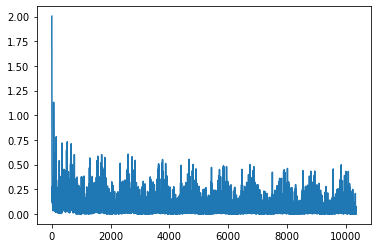

In [12]:
def train(input_tensor, target_action, encoder, predictor, encoder_optimizer, predictor_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    #encoder_optimizer.zero_grad()
    predictor_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # Without teacher forcing: use its own predictions as the next input
    predictor_output = predictor(encoder_hidden.flatten())
    topv, topi = predictor_output.topk(1)
    #predictor_output = topi.squeeze().detach()  # detach from history as input
    loss = criterion(predictor_output.unsqueeze(dim=0), target_action)

    loss.backward()
    
    #encoder_optimizer.step()
    predictor_optimizer.step()

    return loss.item()

hidden_size = 256
learning_rate = 0.001
epochs = 10
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(action_predictor.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[1]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])[0]
        
        loss = train(input_tensor, target_tensor, encoder,
                     action_predictor, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_predictor.state_dict(), 'action_predictor.pt')

show_plot(plot_losses)

# Train - Argument Decoder

updates:  633130
0m 1s (- 160m 22s) (100 0%) 0.2490
0m 2s (- 130m 42s) (200 0%) 0.1823
0m 3s (- 120m 37s) (300 0%) 0.1101
0m 4s (- 116m 6s) (400 0%) 0.1142
0m 5s (- 113m 6s) (500 0%) 0.0816
0m 6s (- 110m 53s) (600 0%) 0.0537
0m 7s (- 109m 2s) (700 0%) 0.1915
0m 8s (- 108m 9s) (800 0%) 0.1301
0m 9s (- 107m 29s) (900 0%) 0.1249
0m 10s (- 106m 49s) (1000 0%) 0.0743
0m 11s (- 107m 31s) (1100 0%) 0.1575
0m 12s (- 107m 36s) (1200 0%) 0.1056
0m 13s (- 107m 43s) (1300 0%) 0.2122
0m 14s (- 108m 5s) (1400 0%) 0.1517
0m 15s (- 108m 13s) (1500 0%) 0.1916
0m 16s (- 107m 58s) (1600 0%) 0.1004
0m 17s (- 107m 32s) (1700 0%) 0.0253
0m 18s (- 107m 11s) (1800 0%) 0.1195
0m 19s (- 106m 57s) (1900 0%) 0.0237
0m 20s (- 106m 36s) (2000 0%) 0.0330
0m 21s (- 106m 17s) (2100 0%) 0.1105
0m 22s (- 106m 4s) (2200 0%) 0.0956
0m 23s (- 106m 2s) (2300 0%) 0.1042
0m 24s (- 106m 2s) (2400 0%) 0.1458
0m 25s (- 105m 52s) (2500 0%) 0.2635
0m 26s (- 105m 47s) (2600 0%) 0.1660
0m 27s (- 105m 49s) (2700 0%) 0.0955
0m 28s (- 

3m 54s (- 108m 14s) (22100 3%) 0.1383
3m 55s (- 108m 13s) (22200 3%) 0.0876
3m 57s (- 108m 12s) (22300 3%) 0.0948
3m 58s (- 108m 12s) (22400 3%) 0.0455
3m 59s (- 108m 11s) (22500 3%) 0.2253
4m 0s (- 108m 9s) (22600 3%) 0.1559
4m 1s (- 108m 6s) (22700 3%) 0.1686
4m 2s (- 108m 5s) (22800 3%) 0.0908
4m 3s (- 108m 3s) (22900 3%) 0.0607
4m 4s (- 108m 2s) (23000 3%) 0.1370
4m 5s (- 108m 0s) (23100 3%) 0.0647
4m 6s (- 107m 58s) (23200 3%) 0.0569
4m 7s (- 107m 56s) (23300 3%) 0.0809
4m 8s (- 107m 54s) (23400 3%) 0.0459
4m 9s (- 107m 52s) (23500 3%) 0.1650
4m 10s (- 107m 50s) (23600 3%) 0.0393
4m 11s (- 107m 47s) (23700 3%) 0.1825
4m 12s (- 107m 44s) (23800 3%) 0.2148
4m 13s (- 107m 43s) (23900 3%) 0.1054
4m 14s (- 107m 40s) (24000 3%) 0.2263
4m 15s (- 107m 38s) (24100 3%) 0.0484
4m 16s (- 107m 37s) (24200 3%) 0.0600
4m 17s (- 107m 35s) (24300 3%) 0.2356
4m 18s (- 107m 33s) (24400 3%) 0.1451
4m 19s (- 107m 31s) (24500 3%) 0.2809
4m 20s (- 107m 30s) (24600 3%) 0.2472
4m 21s (- 107m 28s) (24700 3

7m 42s (- 103m 25s) (43900 6%) 0.1994
7m 43s (- 103m 24s) (44000 6%) 0.0894
7m 44s (- 103m 23s) (44100 6%) 0.1641
7m 45s (- 103m 22s) (44200 6%) 0.1329
7m 46s (- 103m 21s) (44300 6%) 0.0692
7m 47s (- 103m 20s) (44400 7%) 0.2082
7m 48s (- 103m 19s) (44500 7%) 0.1385
7m 49s (- 103m 17s) (44600 7%) 0.0959
7m 50s (- 103m 15s) (44700 7%) 0.1620
7m 51s (- 103m 14s) (44800 7%) 0.0456
7m 52s (- 103m 13s) (44900 7%) 0.0973
7m 53s (- 103m 12s) (45000 7%) 0.0597
7m 54s (- 103m 11s) (45100 7%) 0.2119
7m 55s (- 103m 9s) (45200 7%) 0.0877
7m 56s (- 103m 8s) (45300 7%) 0.1343
7m 57s (- 103m 7s) (45400 7%) 0.1996
7m 59s (- 103m 6s) (45500 7%) 0.0377
8m 0s (- 103m 6s) (45600 7%) 0.0579
8m 1s (- 103m 5s) (45700 7%) 0.1039
8m 2s (- 103m 4s) (45800 7%) 0.1607
8m 3s (- 103m 4s) (45900 7%) 0.0402
8m 4s (- 103m 2s) (46000 7%) 0.0919
8m 5s (- 103m 2s) (46100 7%) 0.1208
8m 6s (- 103m 0s) (46200 7%) 0.1678
8m 7s (- 102m 59s) (46300 7%) 0.1269
8m 8s (- 102m 58s) (46400 7%) 0.1176
8m 9s (- 102m 57s) (46500 7%) 0.

11m 30s (- 99m 47s) (65500 10%) 0.0693
11m 31s (- 99m 46s) (65600 10%) 0.0961
11m 32s (- 99m 44s) (65700 10%) 0.1414
11m 33s (- 99m 43s) (65800 10%) 0.1752
11m 35s (- 99m 42s) (65900 10%) 0.2016
11m 36s (- 99m 41s) (66000 10%) 0.0983
11m 37s (- 99m 40s) (66100 10%) 0.1029
11m 38s (- 99m 38s) (66200 10%) 0.0427
11m 39s (- 99m 37s) (66300 10%) 0.0199
11m 40s (- 99m 35s) (66400 10%) 0.1467
11m 41s (- 99m 33s) (66500 10%) 0.0466
11m 42s (- 99m 31s) (66600 10%) 0.0175
11m 42s (- 99m 29s) (66700 10%) 0.0534
11m 43s (- 99m 28s) (66800 10%) 0.0936
11m 44s (- 99m 26s) (66900 10%) 0.0954
11m 45s (- 99m 24s) (67000 10%) 0.0786
11m 46s (- 99m 23s) (67100 10%) 0.0798
11m 47s (- 99m 21s) (67200 10%) 0.1311
11m 48s (- 99m 19s) (67300 10%) 0.1239
11m 49s (- 99m 17s) (67400 10%) 0.0958
11m 50s (- 99m 16s) (67500 10%) 0.1157
11m 51s (- 99m 14s) (67600 10%) 0.0891
11m 52s (- 99m 13s) (67700 10%) 0.4083
11m 53s (- 99m 12s) (67800 10%) 0.0811
11m 55s (- 99m 12s) (67900 10%) 0.0787
11m 56s (- 99m 11s) (6800

15m 20s (- 96m 40s) (86700 13%) 0.0404
15m 21s (- 96m 39s) (86800 13%) 0.1580
15m 22s (- 96m 38s) (86900 13%) 0.0286
15m 23s (- 96m 37s) (87000 13%) 0.1713
15m 24s (- 96m 36s) (87100 13%) 0.1752
15m 25s (- 96m 35s) (87200 13%) 0.1576
15m 26s (- 96m 34s) (87300 13%) 0.1306
15m 27s (- 96m 33s) (87400 13%) 0.1327
15m 28s (- 96m 32s) (87500 13%) 0.0562
15m 29s (- 96m 31s) (87600 13%) 0.1644
15m 30s (- 96m 29s) (87700 13%) 0.2138
15m 32s (- 96m 28s) (87800 13%) 0.2283
15m 33s (- 96m 27s) (87900 13%) 0.2672
15m 34s (- 96m 26s) (88000 13%) 0.1158
15m 35s (- 96m 25s) (88100 13%) 0.0998
15m 36s (- 96m 24s) (88200 13%) 0.0889
15m 37s (- 96m 24s) (88300 13%) 0.0616
15m 38s (- 96m 23s) (88400 13%) 0.0928
15m 39s (- 96m 22s) (88500 13%) 0.2573
15m 40s (- 96m 21s) (88600 13%) 0.2268
15m 41s (- 96m 20s) (88700 14%) 0.1504
15m 42s (- 96m 19s) (88800 14%) 0.0879
15m 43s (- 96m 18s) (88900 14%) 0.1553
15m 45s (- 96m 17s) (89000 14%) 0.2269
15m 46s (- 96m 16s) (89100 14%) 0.1307
15m 47s (- 96m 15s) (8920

19m 5s (- 93m 7s) (107700 17%) 0.1816
19m 6s (- 93m 5s) (107800 17%) 0.1201
19m 7s (- 93m 4s) (107900 17%) 0.1127
19m 8s (- 93m 3s) (108000 17%) 0.1365
19m 9s (- 93m 2s) (108100 17%) 0.0864
19m 10s (- 93m 1s) (108200 17%) 0.0985
19m 11s (- 93m 0s) (108300 17%) 0.0553
19m 12s (- 92m 59s) (108400 17%) 0.1878
19m 13s (- 92m 57s) (108500 17%) 0.0776
19m 14s (- 92m 56s) (108600 17%) 0.1813
19m 15s (- 92m 55s) (108700 17%) 0.1773
19m 16s (- 92m 54s) (108800 17%) 0.0412
19m 17s (- 92m 53s) (108900 17%) 0.0353
19m 18s (- 92m 52s) (109000 17%) 0.0975
19m 20s (- 92m 51s) (109100 17%) 0.1611
19m 21s (- 92m 50s) (109200 17%) 0.0420
19m 22s (- 92m 49s) (109300 17%) 0.0810
19m 23s (- 92m 48s) (109400 17%) 0.1073
19m 24s (- 92m 47s) (109500 17%) 0.1369
19m 25s (- 92m 46s) (109600 17%) 0.1330
19m 26s (- 92m 45s) (109700 17%) 0.0922
19m 27s (- 92m 44s) (109800 17%) 0.1741
19m 28s (- 92m 42s) (109900 17%) 0.1388
19m 29s (- 92m 41s) (110000 17%) 0.0320
19m 30s (- 92m 40s) (110100 17%) 0.0929
19m 31s (- 9

22m 41s (- 89m 13s) (128400 20%) 0.0975
22m 42s (- 89m 11s) (128500 20%) 0.0574
22m 43s (- 89m 10s) (128600 20%) 0.0080
22m 44s (- 89m 8s) (128700 20%) 0.1019
22m 45s (- 89m 7s) (128800 20%) 0.0732
22m 46s (- 89m 5s) (128900 20%) 0.1033
22m 47s (- 89m 4s) (129000 20%) 0.1170
22m 48s (- 89m 2s) (129100 20%) 0.1913
22m 49s (- 89m 1s) (129200 20%) 0.2113
22m 50s (- 89m 0s) (129300 20%) 0.0945
22m 51s (- 88m 59s) (129400 20%) 0.1128
22m 52s (- 88m 57s) (129500 20%) 0.0503
22m 53s (- 88m 56s) (129600 20%) 0.0263
22m 54s (- 88m 54s) (129700 20%) 0.1315
22m 55s (- 88m 53s) (129800 20%) 0.0508
22m 56s (- 88m 51s) (129900 20%) 0.0155
22m 57s (- 88m 50s) (130000 20%) 0.0588
22m 58s (- 88m 48s) (130100 20%) 0.1112
22m 59s (- 88m 47s) (130200 20%) 0.1030
23m 0s (- 88m 45s) (130300 20%) 0.0696
23m 1s (- 88m 44s) (130400 20%) 0.0820
23m 2s (- 88m 43s) (130500 20%) 0.1266
23m 3s (- 88m 41s) (130600 20%) 0.1208
23m 4s (- 88m 40s) (130700 20%) 0.1091
23m 4s (- 88m 39s) (130800 20%) 0.1083
23m 6s (- 88m

26m 22s (- 85m 38s) (149100 23%) 0.1666
26m 23s (- 85m 37s) (149200 23%) 0.1675
26m 24s (- 85m 36s) (149300 23%) 0.1446
26m 26s (- 85m 35s) (149400 23%) 0.1037
26m 27s (- 85m 34s) (149500 23%) 0.0729
26m 28s (- 85m 33s) (149600 23%) 0.1328
26m 29s (- 85m 32s) (149700 23%) 0.0713
26m 30s (- 85m 31s) (149800 23%) 0.0328
26m 31s (- 85m 30s) (149900 23%) 0.0643
26m 32s (- 85m 28s) (150000 23%) 0.0432
26m 33s (- 85m 27s) (150100 23%) 0.1526
26m 34s (- 85m 26s) (150200 23%) 0.0180
26m 35s (- 85m 25s) (150300 23%) 0.1368
26m 36s (- 85m 25s) (150400 23%) 0.2017
26m 37s (- 85m 24s) (150500 23%) 0.1512
26m 38s (- 85m 23s) (150600 23%) 0.1077
26m 39s (- 85m 21s) (150700 23%) 0.1488
26m 41s (- 85m 20s) (150800 23%) 0.0498
26m 42s (- 85m 19s) (150900 23%) 0.1321
26m 43s (- 85m 18s) (151000 23%) 0.2356
26m 44s (- 85m 17s) (151100 23%) 0.1851
26m 45s (- 85m 16s) (151200 23%) 0.2696
26m 46s (- 85m 15s) (151300 23%) 0.1028
26m 47s (- 85m 14s) (151400 23%) 0.0897
26m 48s (- 85m 13s) (151500 23%) 0.0905


30m 3s (- 82m 1s) (169800 26%) 0.2056
30m 4s (- 82m 0s) (169900 26%) 0.0753
30m 5s (- 81m 59s) (170000 26%) 0.1981
30m 7s (- 81m 58s) (170100 26%) 0.1864
30m 8s (- 81m 58s) (170200 26%) 0.1616
30m 9s (- 81m 56s) (170300 26%) 0.1888
30m 10s (- 81m 56s) (170400 26%) 0.2066
30m 11s (- 81m 54s) (170500 26%) 0.1695
30m 12s (- 81m 53s) (170600 26%) 0.1448
30m 13s (- 81m 52s) (170700 26%) 0.1484
30m 14s (- 81m 51s) (170800 26%) 0.1023
30m 15s (- 81m 50s) (170900 26%) 0.0944
30m 16s (- 81m 49s) (171000 27%) 0.1811
30m 17s (- 81m 48s) (171100 27%) 0.1036
30m 18s (- 81m 47s) (171200 27%) 0.1166
30m 19s (- 81m 46s) (171300 27%) 0.1402
30m 20s (- 81m 45s) (171400 27%) 0.0785
30m 22s (- 81m 44s) (171500 27%) 0.0921
30m 23s (- 81m 43s) (171600 27%) 0.0537
30m 24s (- 81m 42s) (171700 27%) 0.1627
30m 25s (- 81m 41s) (171800 27%) 0.1243
30m 26s (- 81m 40s) (171900 27%) 0.1771
30m 27s (- 81m 39s) (172000 27%) 0.1746
30m 28s (- 81m 38s) (172100 27%) 0.0515
30m 29s (- 81m 38s) (172200 27%) 0.0350
30m 31s 

33m 46s (- 78m 29s) (190500 30%) 0.0667
33m 47s (- 78m 28s) (190600 30%) 0.1485
33m 48s (- 78m 27s) (190700 30%) 0.0988
33m 49s (- 78m 25s) (190800 30%) 0.0979
33m 50s (- 78m 24s) (190900 30%) 0.1233
33m 51s (- 78m 23s) (191000 30%) 0.1815
33m 52s (- 78m 22s) (191100 30%) 0.0436
33m 53s (- 78m 21s) (191200 30%) 0.1620
33m 54s (- 78m 19s) (191300 30%) 0.1524
33m 56s (- 78m 18s) (191400 30%) 0.1330
33m 57s (- 78m 17s) (191500 30%) 0.1030
33m 57s (- 78m 16s) (191600 30%) 0.0242
33m 59s (- 78m 15s) (191700 30%) 0.0269
34m 0s (- 78m 14s) (191800 30%) 0.1287
34m 1s (- 78m 12s) (191900 30%) 0.0096
34m 1s (- 78m 11s) (192000 30%) 0.0706
34m 2s (- 78m 10s) (192100 30%) 0.0519
34m 3s (- 78m 8s) (192200 30%) 0.1173
34m 4s (- 78m 7s) (192300 30%) 0.1342
34m 5s (- 78m 6s) (192400 30%) 0.1318
34m 6s (- 78m 5s) (192500 30%) 0.1998
34m 7s (- 78m 4s) (192600 30%) 0.1298
34m 8s (- 78m 2s) (192700 30%) 0.1093
34m 9s (- 78m 1s) (192800 30%) 0.0215
34m 10s (- 78m 0s) (192900 30%) 0.0596
34m 11s (- 77m 59s)

37m 35s (- 75m 6s) (211200 33%) 0.0722
37m 37s (- 75m 5s) (211300 33%) 0.2962
37m 38s (- 75m 5s) (211400 33%) 0.2160
37m 39s (- 75m 4s) (211500 33%) 0.1485
37m 40s (- 75m 3s) (211600 33%) 0.1039
37m 41s (- 75m 2s) (211700 33%) 0.0705
37m 42s (- 75m 1s) (211800 33%) 0.1096
37m 43s (- 75m 0s) (211900 33%) 0.1203
37m 44s (- 74m 58s) (212000 33%) 0.2594
37m 45s (- 74m 57s) (212100 33%) 0.0757
37m 47s (- 74m 56s) (212200 33%) 0.0881
37m 48s (- 74m 55s) (212300 33%) 0.0629
37m 49s (- 74m 54s) (212400 33%) 0.1195
37m 50s (- 74m 53s) (212500 33%) 0.1879
37m 51s (- 74m 52s) (212600 33%) 0.1197
37m 52s (- 74m 51s) (212700 33%) 0.0999
37m 53s (- 74m 51s) (212800 33%) 0.0326
37m 54s (- 74m 50s) (212900 33%) 0.1448
37m 55s (- 74m 49s) (213000 33%) 0.0915
37m 57s (- 74m 48s) (213100 33%) 0.0237
37m 58s (- 74m 47s) (213200 33%) 0.0542
37m 59s (- 74m 46s) (213300 33%) 0.0477
38m 0s (- 74m 45s) (213400 33%) 0.1303
38m 1s (- 74m 43s) (213500 33%) 0.0340
38m 2s (- 74m 42s) (213600 33%) 0.1386
38m 3s (- 7

41m 22s (- 71m 35s) (231900 36%) 0.1530
41m 23s (- 71m 34s) (232000 36%) 0.1380
41m 24s (- 71m 33s) (232100 36%) 0.0688
41m 25s (- 71m 31s) (232200 36%) 0.2177
41m 26s (- 71m 30s) (232300 36%) 0.2261
41m 27s (- 71m 29s) (232400 36%) 0.1686
41m 28s (- 71m 28s) (232500 36%) 0.2135
41m 30s (- 71m 27s) (232600 36%) 0.1915
41m 31s (- 71m 26s) (232700 36%) 0.1277
41m 32s (- 71m 25s) (232800 36%) 0.0873
41m 33s (- 71m 24s) (232900 36%) 0.1706
41m 34s (- 71m 23s) (233000 36%) 0.1445
41m 35s (- 71m 22s) (233100 36%) 0.2354
41m 36s (- 71m 21s) (233200 36%) 0.0714
41m 37s (- 71m 20s) (233300 36%) 0.1876
41m 38s (- 71m 19s) (233400 36%) 0.1734
41m 39s (- 71m 18s) (233500 36%) 0.1442
41m 41s (- 71m 17s) (233600 36%) 0.2155
41m 42s (- 71m 16s) (233700 36%) 0.1840
41m 43s (- 71m 15s) (233800 36%) 0.1864
41m 44s (- 71m 14s) (233900 36%) 0.1452
41m 45s (- 71m 13s) (234000 36%) 0.1418
41m 46s (- 71m 12s) (234100 36%) 0.1075
41m 47s (- 71m 11s) (234200 36%) 0.0963
41m 48s (- 71m 10s) (234300 37%) 0.1551


45m 9s (- 68m 1s) (252600 39%) 0.1111
45m 10s (- 68m 0s) (252700 39%) 0.1748
45m 11s (- 67m 59s) (252800 39%) 0.1234
45m 13s (- 67m 59s) (252900 39%) 0.2266
45m 14s (- 67m 58s) (253000 39%) 0.0441
45m 15s (- 67m 57s) (253100 39%) 0.0497
45m 16s (- 67m 56s) (253200 39%) 0.1104
45m 17s (- 67m 55s) (253300 40%) 0.1312
45m 18s (- 67m 54s) (253400 40%) 0.2170
45m 19s (- 67m 53s) (253500 40%) 0.0940
45m 20s (- 67m 52s) (253600 40%) 0.0591
45m 21s (- 67m 50s) (253700 40%) 0.1169
45m 22s (- 67m 49s) (253800 40%) 0.0739
45m 24s (- 67m 48s) (253900 40%) 0.1111
45m 25s (- 67m 47s) (254000 40%) 0.1119
45m 26s (- 67m 46s) (254100 40%) 0.0729
45m 27s (- 67m 45s) (254200 40%) 0.1420
45m 28s (- 67m 43s) (254300 40%) 0.1596
45m 29s (- 67m 42s) (254400 40%) 0.0590
45m 30s (- 67m 41s) (254500 40%) 0.0955
45m 31s (- 67m 40s) (254600 40%) 0.1928
45m 32s (- 67m 39s) (254700 40%) 0.1292
45m 33s (- 67m 38s) (254800 40%) 0.1149
45m 34s (- 67m 37s) (254900 40%) 0.0203
45m 35s (- 67m 36s) (255000 40%) 0.0215
45m

48m 52s (- 64m 20s) (273300 43%) 0.1176
48m 53s (- 64m 19s) (273400 43%) 0.1695
48m 54s (- 64m 18s) (273500 43%) 0.2857
48m 55s (- 64m 17s) (273600 43%) 0.3304
48m 56s (- 64m 16s) (273700 43%) 0.2420
48m 57s (- 64m 14s) (273800 43%) 0.1452
48m 58s (- 64m 13s) (273900 43%) 0.2651
48m 59s (- 64m 12s) (274000 43%) 0.0611
49m 0s (- 64m 11s) (274100 43%) 0.0483
49m 1s (- 64m 10s) (274200 43%) 0.0750
49m 2s (- 64m 9s) (274300 43%) 0.0462
49m 3s (- 64m 8s) (274400 43%) 0.0650
49m 4s (- 64m 7s) (274500 43%) 0.0512
49m 5s (- 64m 6s) (274600 43%) 0.3171
49m 6s (- 64m 4s) (274700 43%) 0.2268
49m 7s (- 64m 3s) (274800 43%) 0.1497
49m 8s (- 64m 2s) (274900 43%) 0.0919
49m 9s (- 64m 1s) (275000 43%) 0.0765
49m 10s (- 64m 0s) (275100 43%) 0.0935
49m 11s (- 63m 59s) (275200 43%) 0.1348
49m 12s (- 63m 58s) (275300 43%) 0.2034
49m 13s (- 63m 57s) (275400 43%) 0.0989
49m 14s (- 63m 55s) (275500 43%) 0.0944
49m 16s (- 63m 54s) (275600 43%) 0.0560
49m 17s (- 63m 53s) (275700 43%) 0.1103
49m 18s (- 63m 52s)

52m 30s (- 60m 34s) (294000 46%) 0.1728
52m 31s (- 60m 33s) (294100 46%) 0.2931
52m 32s (- 60m 32s) (294200 46%) 0.2187
52m 33s (- 60m 31s) (294300 46%) 0.0825
52m 35s (- 60m 30s) (294400 46%) 0.1712
52m 36s (- 60m 29s) (294500 46%) 0.2107
52m 37s (- 60m 28s) (294600 46%) 0.1609
52m 38s (- 60m 26s) (294700 46%) 0.1625
52m 39s (- 60m 25s) (294800 46%) 0.1603
52m 40s (- 60m 24s) (294900 46%) 0.1858
52m 41s (- 60m 23s) (295000 46%) 0.2919
52m 42s (- 60m 22s) (295100 46%) 0.2495
52m 43s (- 60m 21s) (295200 46%) 0.2287
52m 44s (- 60m 20s) (295300 46%) 0.1511
52m 45s (- 60m 19s) (295400 46%) 0.0524
52m 46s (- 60m 18s) (295500 46%) 0.1950
52m 47s (- 60m 17s) (295600 46%) 0.1916
52m 48s (- 60m 16s) (295700 46%) 0.2089
52m 49s (- 60m 15s) (295800 46%) 0.1787
52m 50s (- 60m 13s) (295900 46%) 0.1769
52m 51s (- 60m 12s) (296000 46%) 0.1322
52m 53s (- 60m 11s) (296100 46%) 0.0979
52m 54s (- 60m 10s) (296200 46%) 0.1398
52m 55s (- 60m 9s) (296300 46%) 0.1320
52m 56s (- 60m 8s) (296400 46%) 0.2319
52

56m 14s (- 56m 54s) (314700 49%) 0.1346
56m 15s (- 56m 53s) (314800 49%) 0.0382
56m 16s (- 56m 52s) (314900 49%) 0.0341
56m 17s (- 56m 51s) (315000 49%) 0.0274
56m 18s (- 56m 49s) (315100 49%) 0.0196
56m 19s (- 56m 48s) (315200 49%) 0.0534
56m 20s (- 56m 47s) (315300 49%) 0.0439
56m 21s (- 56m 46s) (315400 49%) 0.0722
56m 22s (- 56m 45s) (315500 49%) 0.0753
56m 23s (- 56m 44s) (315600 49%) 0.1474
56m 24s (- 56m 43s) (315700 49%) 0.1650
56m 26s (- 56m 42s) (315800 49%) 0.2082
56m 27s (- 56m 41s) (315900 49%) 0.0887
56m 28s (- 56m 40s) (316000 49%) 0.1723
56m 29s (- 56m 39s) (316100 49%) 0.1305
56m 30s (- 56m 38s) (316200 49%) 0.2276
56m 31s (- 56m 37s) (316300 49%) 0.0558
56m 32s (- 56m 36s) (316400 49%) 0.0319
56m 33s (- 56m 35s) (316500 49%) 0.1040
56m 34s (- 56m 34s) (316600 50%) 0.1010
56m 35s (- 56m 32s) (316700 50%) 0.1518
56m 36s (- 56m 31s) (316800 50%) 0.1613
56m 37s (- 56m 30s) (316900 50%) 0.0521
56m 38s (- 56m 29s) (317000 50%) 0.1084
56m 39s (- 56m 28s) (317100 50%) 0.0765


59m 53s (- 53m 10s) (335400 52%) 0.0830
59m 54s (- 53m 9s) (335500 52%) 0.0932
59m 55s (- 53m 7s) (335600 53%) 0.1845
59m 57s (- 53m 6s) (335700 53%) 0.1075
59m 58s (- 53m 5s) (335800 53%) 0.0881
59m 59s (- 53m 4s) (335900 53%) 0.1869
60m 0s (- 53m 3s) (336000 53%) 0.0903
60m 1s (- 53m 2s) (336100 53%) 0.1374
60m 2s (- 53m 1s) (336200 53%) 0.2902
60m 3s (- 53m 0s) (336300 53%) 0.2857
60m 4s (- 52m 59s) (336400 53%) 0.2287
60m 5s (- 52m 58s) (336500 53%) 0.0828
60m 6s (- 52m 57s) (336600 53%) 0.0834
60m 7s (- 52m 56s) (336700 53%) 0.1454
60m 8s (- 52m 55s) (336800 53%) 0.2800
60m 9s (- 52m 54s) (336900 53%) 0.2884
60m 10s (- 52m 52s) (337000 53%) 0.2041
60m 11s (- 52m 51s) (337100 53%) 0.1648
60m 12s (- 52m 50s) (337200 53%) 0.2712
60m 13s (- 52m 49s) (337300 53%) 0.0802
60m 15s (- 52m 48s) (337400 53%) 0.0449
60m 16s (- 52m 47s) (337500 53%) 0.0522
60m 17s (- 52m 46s) (337600 53%) 0.0384
60m 18s (- 52m 45s) (337700 53%) 0.0557
60m 19s (- 52m 44s) (337800 53%) 0.0575
60m 20s (- 52m 43s)

63m 34s (- 49m 27s) (356100 56%) 0.1627
63m 35s (- 49m 26s) (356200 56%) 0.2662
63m 36s (- 49m 25s) (356300 56%) 0.1041
63m 37s (- 49m 24s) (356400 56%) 0.0965
63m 38s (- 49m 23s) (356500 56%) 0.1016
63m 40s (- 49m 22s) (356600 56%) 0.0484
63m 41s (- 49m 21s) (356700 56%) 0.0324
63m 42s (- 49m 20s) (356800 56%) 0.0792
63m 43s (- 49m 19s) (356900 56%) 0.1499
63m 44s (- 49m 18s) (357000 56%) 0.2409
63m 45s (- 49m 17s) (357100 56%) 0.1702
63m 46s (- 49m 16s) (357200 56%) 0.1367
63m 47s (- 49m 14s) (357300 56%) 0.1752
63m 48s (- 49m 13s) (357400 56%) 0.2573
63m 49s (- 49m 12s) (357500 56%) 0.2300
63m 50s (- 49m 11s) (357600 56%) 0.0885
63m 52s (- 49m 10s) (357700 56%) 0.1572
63m 53s (- 49m 9s) (357800 56%) 0.2198
63m 54s (- 49m 8s) (357900 56%) 0.1488
63m 55s (- 49m 7s) (358000 56%) 0.1479
63m 56s (- 49m 6s) (358100 56%) 0.1594
63m 57s (- 49m 5s) (358200 56%) 0.1631
63m 58s (- 49m 4s) (358300 56%) 0.2577
63m 59s (- 49m 3s) (358400 56%) 0.2950
64m 0s (- 49m 2s) (358500 56%) 0.2336
64m 1s (-

67m 14s (- 45m 44s) (376800 59%) 0.1400
67m 15s (- 45m 43s) (376900 59%) 0.1440
67m 16s (- 45m 42s) (377000 59%) 0.1577
67m 17s (- 45m 41s) (377100 59%) 0.0616
67m 18s (- 45m 40s) (377200 59%) 0.1002
67m 19s (- 45m 39s) (377300 59%) 0.0821
67m 20s (- 45m 38s) (377400 59%) 0.0408
67m 22s (- 45m 37s) (377500 59%) 0.0454
67m 23s (- 45m 36s) (377600 59%) 0.1670
67m 24s (- 45m 35s) (377700 59%) 0.2237
67m 25s (- 45m 33s) (377800 59%) 0.1087
67m 26s (- 45m 32s) (377900 59%) 0.0725
67m 27s (- 45m 31s) (378000 59%) 0.0957
67m 28s (- 45m 30s) (378100 59%) 0.0574
67m 29s (- 45m 29s) (378200 59%) 0.0278
67m 30s (- 45m 28s) (378300 59%) 0.0248
67m 32s (- 45m 27s) (378400 59%) 0.0199
67m 33s (- 45m 26s) (378500 59%) 0.0558
67m 34s (- 45m 25s) (378600 59%) 0.0383
67m 35s (- 45m 24s) (378700 59%) 0.0817
67m 36s (- 45m 23s) (378800 59%) 0.0522
67m 37s (- 45m 22s) (378900 59%) 0.1322
67m 38s (- 45m 21s) (379000 59%) 0.1397
67m 39s (- 45m 20s) (379100 59%) 0.2949
67m 41s (- 45m 19s) (379200 59%) 0.0811


71m 1s (- 42m 6s) (397500 62%) 0.1167
71m 2s (- 42m 4s) (397600 62%) 0.2281
71m 3s (- 42m 3s) (397700 62%) 0.0754
71m 4s (- 42m 2s) (397800 62%) 0.1024
71m 5s (- 42m 1s) (397900 62%) 0.0352
71m 6s (- 42m 0s) (398000 62%) 0.1642
71m 7s (- 41m 59s) (398100 62%) 0.1316
71m 8s (- 41m 58s) (398200 62%) 0.2497
71m 9s (- 41m 57s) (398300 62%) 0.1328
71m 10s (- 41m 56s) (398400 62%) 0.1161
71m 11s (- 41m 55s) (398500 62%) 0.2209
71m 12s (- 41m 54s) (398600 62%) 0.2608
71m 13s (- 41m 53s) (398700 62%) 0.0915
71m 15s (- 41m 51s) (398800 62%) 0.1185
71m 16s (- 41m 50s) (398900 63%) 0.1374
71m 17s (- 41m 49s) (399000 63%) 0.1327
71m 18s (- 41m 48s) (399100 63%) 0.0918
71m 19s (- 41m 47s) (399200 63%) 0.1506
71m 20s (- 41m 46s) (399300 63%) 0.1377
71m 21s (- 41m 45s) (399400 63%) 0.1344
71m 22s (- 41m 44s) (399500 63%) 0.2408
71m 23s (- 41m 43s) (399600 63%) 0.2743
71m 24s (- 41m 42s) (399700 63%) 0.2508
71m 25s (- 41m 41s) (399800 63%) 0.0726
71m 26s (- 41m 40s) (399900 63%) 0.1010
71m 28s (- 41m 

74m 41s (- 38m 23s) (418200 66%) 0.1891
74m 42s (- 38m 22s) (418300 66%) 0.1645
74m 44s (- 38m 21s) (418400 66%) 0.0577
74m 45s (- 38m 20s) (418500 66%) 0.0250
74m 46s (- 38m 19s) (418600 66%) 0.0558
74m 47s (- 38m 18s) (418700 66%) 0.2970
74m 48s (- 38m 16s) (418800 66%) 0.1037
74m 49s (- 38m 15s) (418900 66%) 0.1733
74m 50s (- 38m 14s) (419000 66%) 0.1757
74m 51s (- 38m 13s) (419100 66%) 0.1238
74m 52s (- 38m 12s) (419200 66%) 0.1202
74m 53s (- 38m 11s) (419300 66%) 0.1138
74m 54s (- 38m 10s) (419400 66%) 0.1482
74m 55s (- 38m 9s) (419500 66%) 0.2441
74m 56s (- 38m 8s) (419600 66%) 0.1344
74m 58s (- 38m 7s) (419700 66%) 0.0975
74m 59s (- 38m 6s) (419800 66%) 0.0991
75m 0s (- 38m 5s) (419900 66%) 0.0575
75m 1s (- 38m 4s) (420000 66%) 0.0346
75m 2s (- 38m 3s) (420100 66%) 0.0922
75m 3s (- 38m 2s) (420200 66%) 0.1496
75m 4s (- 38m 0s) (420300 66%) 0.1900
75m 5s (- 37m 59s) (420400 66%) 0.2236
75m 6s (- 37m 58s) (420500 66%) 0.1274
75m 7s (- 37m 57s) (420600 66%) 0.1463
75m 8s (- 37m 56s

78m 25s (- 34m 42s) (438900 69%) 0.1145
78m 27s (- 34m 41s) (439000 69%) 0.0818
78m 28s (- 34m 40s) (439100 69%) 0.0374
78m 29s (- 34m 39s) (439200 69%) 0.0783
78m 30s (- 34m 38s) (439300 69%) 0.0953
78m 31s (- 34m 37s) (439400 69%) 0.0456
78m 32s (- 34m 36s) (439500 69%) 0.0751
78m 33s (- 34m 35s) (439600 69%) 0.1644
78m 34s (- 34m 34s) (439700 69%) 0.0757
78m 35s (- 34m 33s) (439800 69%) 0.1108
78m 36s (- 34m 31s) (439900 69%) 0.1031
78m 38s (- 34m 30s) (440000 69%) 0.0685
78m 39s (- 34m 29s) (440100 69%) 0.1050
78m 40s (- 34m 28s) (440200 69%) 0.1567
78m 41s (- 34m 27s) (440300 69%) 0.1277
78m 42s (- 34m 26s) (440400 69%) 0.0757
78m 43s (- 34m 25s) (440500 69%) 0.0783
78m 44s (- 34m 24s) (440600 69%) 0.0782
78m 45s (- 34m 23s) (440700 69%) 0.0419
78m 46s (- 34m 22s) (440800 69%) 0.0433
78m 47s (- 34m 21s) (440900 69%) 0.1509
78m 49s (- 34m 20s) (441000 69%) 0.2168
78m 50s (- 34m 19s) (441100 69%) 0.1090
78m 51s (- 34m 18s) (441200 69%) 0.0620
78m 52s (- 34m 17s) (441300 69%) 0.0567


82m 13s (- 31m 2s) (459600 72%) 0.1087
82m 14s (- 31m 1s) (459700 72%) 0.0886
82m 15s (- 31m 0s) (459800 72%) 0.2404
82m 16s (- 30m 59s) (459900 72%) 0.0538
82m 17s (- 30m 58s) (460000 72%) 0.1468
82m 18s (- 30m 57s) (460100 72%) 0.0985
82m 19s (- 30m 56s) (460200 72%) 0.1019
82m 20s (- 30m 55s) (460300 72%) 0.2452
82m 21s (- 30m 54s) (460400 72%) 0.3935
82m 23s (- 30m 53s) (460500 72%) 0.1414
82m 24s (- 30m 51s) (460600 72%) 0.2820
82m 25s (- 30m 50s) (460700 72%) 0.2149
82m 26s (- 30m 49s) (460800 72%) 0.1598
82m 27s (- 30m 48s) (460900 72%) 0.1990
82m 28s (- 30m 47s) (461000 72%) 0.0908
82m 29s (- 30m 46s) (461100 72%) 0.1060
82m 30s (- 30m 45s) (461200 72%) 0.0256
82m 31s (- 30m 44s) (461300 72%) 0.1388
82m 32s (- 30m 43s) (461400 72%) 0.1601
82m 34s (- 30m 42s) (461500 72%) 0.2129
82m 35s (- 30m 41s) (461600 72%) 0.1444
82m 36s (- 30m 40s) (461700 72%) 0.0632
82m 37s (- 30m 39s) (461800 72%) 0.1724
82m 38s (- 30m 38s) (461900 72%) 0.3526
82m 39s (- 30m 37s) (462000 72%) 0.1042
82m

85m 58s (- 27m 21s) (480300 75%) 0.0771
85m 59s (- 27m 20s) (480400 75%) 0.0490
86m 0s (- 27m 19s) (480500 75%) 0.1490
86m 1s (- 27m 18s) (480600 75%) 0.0415
86m 2s (- 27m 17s) (480700 75%) 0.1231
86m 3s (- 27m 16s) (480800 75%) 0.2369
86m 4s (- 27m 14s) (480900 75%) 0.1126
86m 5s (- 27m 13s) (481000 75%) 0.2007
86m 6s (- 27m 12s) (481100 75%) 0.2139
86m 7s (- 27m 11s) (481200 76%) 0.2130
86m 9s (- 27m 10s) (481300 76%) 0.1503
86m 10s (- 27m 9s) (481400 76%) 0.2411
86m 11s (- 27m 8s) (481500 76%) 0.1735
86m 12s (- 27m 7s) (481600 76%) 0.1785
86m 13s (- 27m 6s) (481700 76%) 0.0305
86m 14s (- 27m 5s) (481800 76%) 0.0496
86m 15s (- 27m 4s) (481900 76%) 0.0506
86m 16s (- 27m 3s) (482000 76%) 0.2609
86m 17s (- 27m 1s) (482100 76%) 0.1196
86m 18s (- 27m 0s) (482200 76%) 0.1476
86m 19s (- 26m 59s) (482300 76%) 0.1860
86m 20s (- 26m 58s) (482400 76%) 0.1024
86m 21s (- 26m 57s) (482500 76%) 0.1450
86m 22s (- 26m 56s) (482600 76%) 0.1315
86m 23s (- 26m 55s) (482700 76%) 0.1073
86m 25s (- 26m 54s

89m 42s (- 23m 39s) (501000 79%) 0.1729
89m 43s (- 23m 38s) (501100 79%) 0.1363
89m 44s (- 23m 37s) (501200 79%) 0.1355
89m 45s (- 23m 36s) (501300 79%) 0.0672
89m 46s (- 23m 35s) (501400 79%) 0.0274
89m 47s (- 23m 34s) (501500 79%) 0.1611
89m 48s (- 23m 33s) (501600 79%) 0.1306
89m 49s (- 23m 31s) (501700 79%) 0.0339
89m 50s (- 23m 30s) (501800 79%) 0.0571
89m 51s (- 23m 29s) (501900 79%) 0.0311
89m 53s (- 23m 28s) (502000 79%) 0.1209
89m 54s (- 23m 27s) (502100 79%) 0.2026
89m 55s (- 23m 26s) (502200 79%) 0.1316
89m 56s (- 23m 25s) (502300 79%) 0.0835
89m 57s (- 23m 24s) (502400 79%) 0.0219
89m 58s (- 23m 23s) (502500 79%) 0.0835
89m 59s (- 23m 22s) (502600 79%) 0.0699
90m 0s (- 23m 21s) (502700 79%) 0.0452
90m 1s (- 23m 20s) (502800 79%) 0.0735
90m 2s (- 23m 19s) (502900 79%) 0.1665
90m 3s (- 23m 18s) (503000 79%) 0.0680
90m 5s (- 23m 16s) (503100 79%) 0.1113
90m 6s (- 23m 15s) (503200 79%) 0.1053
90m 7s (- 23m 14s) (503300 79%) 0.0565
90m 8s (- 23m 13s) (503400 79%) 0.0982
90m 9s (

93m 25s (- 19m 57s) (521700 82%) 0.0861
93m 26s (- 19m 56s) (521800 82%) 0.2763
93m 27s (- 19m 55s) (521900 82%) 0.1260
93m 28s (- 19m 54s) (522000 82%) 0.2148
93m 29s (- 19m 53s) (522100 82%) 0.1811
93m 31s (- 19m 51s) (522200 82%) 0.1578
93m 32s (- 19m 50s) (522300 82%) 0.1521
93m 33s (- 19m 49s) (522400 82%) 0.1501
93m 34s (- 19m 48s) (522500 82%) 0.1296
93m 35s (- 19m 47s) (522600 82%) 0.1948
93m 36s (- 19m 46s) (522700 82%) 0.0948
93m 37s (- 19m 45s) (522800 82%) 0.0437
93m 38s (- 19m 44s) (522900 82%) 0.1422
93m 39s (- 19m 43s) (523000 82%) 0.0812
93m 40s (- 19m 42s) (523100 82%) 0.2370
93m 41s (- 19m 41s) (523200 82%) 0.0618
93m 42s (- 19m 40s) (523300 82%) 0.1324
93m 43s (- 19m 39s) (523400 82%) 0.1145
93m 45s (- 19m 37s) (523500 82%) 0.0704
93m 46s (- 19m 36s) (523600 82%) 0.2534
93m 47s (- 19m 35s) (523700 82%) 0.3469
93m 48s (- 19m 34s) (523800 82%) 0.1304
93m 49s (- 19m 33s) (523900 82%) 0.2729
93m 50s (- 19m 32s) (524000 82%) 0.2269
93m 51s (- 19m 31s) (524100 82%) 0.1508


97m 9s (- 16m 15s) (542400 85%) 0.1242
97m 10s (- 16m 14s) (542500 85%) 0.0514
97m 11s (- 16m 13s) (542600 85%) 0.0616
97m 13s (- 16m 11s) (542700 85%) 0.0074
97m 14s (- 16m 10s) (542800 85%) 0.2186
97m 15s (- 16m 9s) (542900 85%) 0.0714
97m 16s (- 16m 8s) (543000 85%) 0.0711
97m 17s (- 16m 7s) (543100 85%) 0.1658
97m 18s (- 16m 6s) (543200 85%) 0.0738
97m 19s (- 16m 5s) (543300 85%) 0.0252
97m 20s (- 16m 4s) (543400 85%) 0.0268
97m 21s (- 16m 3s) (543500 85%) 0.0169
97m 22s (- 16m 2s) (543600 85%) 0.0768
97m 23s (- 16m 1s) (543700 85%) 0.0302
97m 24s (- 16m 0s) (543800 85%) 0.1739
97m 25s (- 15m 59s) (543900 85%) 0.0355
97m 26s (- 15m 57s) (544000 85%) 0.0932
97m 27s (- 15m 56s) (544100 85%) 0.2265
97m 28s (- 15m 55s) (544200 85%) 0.1200
97m 29s (- 15m 54s) (544300 85%) 0.1939
97m 30s (- 15m 53s) (544400 85%) 0.2222
97m 31s (- 15m 52s) (544500 86%) 0.1852
97m 32s (- 15m 51s) (544600 86%) 0.2007
97m 33s (- 15m 50s) (544700 86%) 0.1404
97m 34s (- 15m 49s) (544800 86%) 0.2496
97m 35s (- 

100m 42s (- 12m 32s) (563000 88%) 0.0278
100m 43s (- 12m 31s) (563100 88%) 0.1320
100m 44s (- 12m 30s) (563200 88%) 0.0562
100m 45s (- 12m 29s) (563300 88%) 0.1121
100m 47s (- 12m 28s) (563400 88%) 0.0260
100m 48s (- 12m 27s) (563500 89%) 0.0573
100m 49s (- 12m 26s) (563600 89%) 0.0861
100m 50s (- 12m 25s) (563700 89%) 0.0408
100m 51s (- 12m 24s) (563800 89%) 0.0928
100m 52s (- 12m 23s) (563900 89%) 0.0704
100m 53s (- 12m 21s) (564000 89%) 0.0186
100m 54s (- 12m 20s) (564100 89%) 0.0857
100m 55s (- 12m 19s) (564200 89%) 0.0298
100m 56s (- 12m 18s) (564300 89%) 0.1516
100m 57s (- 12m 17s) (564400 89%) 0.1187
100m 58s (- 12m 16s) (564500 89%) 0.1282
100m 59s (- 12m 15s) (564600 89%) 0.0796
101m 0s (- 12m 14s) (564700 89%) 0.0273
101m 1s (- 12m 13s) (564800 89%) 0.1246
101m 2s (- 12m 12s) (564900 89%) 0.1413
101m 3s (- 12m 11s) (565000 89%) 0.0420
101m 5s (- 12m 10s) (565100 89%) 0.0593
101m 6s (- 12m 9s) (565200 89%) 0.0074
101m 7s (- 12m 7s) (565300 89%) 0.1300
101m 8s (- 12m 6s) (56540

104m 21s (- 8m 53s) (583400 92%) 0.0942
104m 23s (- 8m 52s) (583500 92%) 0.1096
104m 24s (- 8m 51s) (583600 92%) 0.1085
104m 25s (- 8m 50s) (583700 92%) 0.0356
104m 26s (- 8m 49s) (583800 92%) 0.0541
104m 27s (- 8m 48s) (583900 92%) 0.0804
104m 28s (- 8m 47s) (584000 92%) 0.1841
104m 29s (- 8m 46s) (584100 92%) 0.1699
104m 30s (- 8m 45s) (584200 92%) 0.1721
104m 31s (- 8m 44s) (584300 92%) 0.2073
104m 33s (- 8m 43s) (584400 92%) 0.1515
104m 34s (- 8m 42s) (584500 92%) 0.1792
104m 35s (- 8m 40s) (584600 92%) 0.2150
104m 36s (- 8m 39s) (584700 92%) 0.1507
104m 37s (- 8m 38s) (584800 92%) 0.1392
104m 38s (- 8m 37s) (584900 92%) 0.1469
104m 39s (- 8m 36s) (585000 92%) 0.1859
104m 40s (- 8m 35s) (585100 92%) 0.2380
104m 41s (- 8m 34s) (585200 92%) 0.1562
104m 42s (- 8m 33s) (585300 92%) 0.2378
104m 44s (- 8m 32s) (585400 92%) 0.1632
104m 45s (- 8m 31s) (585500 92%) 0.1655
104m 46s (- 8m 30s) (585600 92%) 0.1707
104m 47s (- 8m 29s) (585700 92%) 0.1332
104m 48s (- 8m 28s) (585800 92%) 0.1001


108m 5s (- 5m 11s) (604100 95%) 0.0811
108m 6s (- 5m 10s) (604200 95%) 0.2212
108m 7s (- 5m 9s) (604300 95%) 0.0426
108m 8s (- 5m 8s) (604400 95%) 0.1011
108m 9s (- 5m 7s) (604500 95%) 0.1428
108m 10s (- 5m 6s) (604600 95%) 0.2229
108m 11s (- 5m 5s) (604700 95%) 0.1570
108m 12s (- 5m 4s) (604800 95%) 0.0968
108m 13s (- 5m 3s) (604900 95%) 0.2440
108m 14s (- 5m 1s) (605000 95%) 0.0817
108m 15s (- 5m 0s) (605100 95%) 0.0453
108m 16s (- 4m 59s) (605200 95%) 0.0888
108m 18s (- 4m 58s) (605300 95%) 0.0399
108m 19s (- 4m 57s) (605400 95%) 0.0739
108m 20s (- 4m 56s) (605500 95%) 0.0814
108m 21s (- 4m 55s) (605600 95%) 0.0301
108m 22s (- 4m 54s) (605700 95%) 0.1093
108m 23s (- 4m 53s) (605800 95%) 0.0590
108m 24s (- 4m 52s) (605900 95%) 0.0662
108m 25s (- 4m 51s) (606000 95%) 0.0085
108m 26s (- 4m 50s) (606100 95%) 0.1988
108m 27s (- 4m 49s) (606200 95%) 0.0877
108m 28s (- 4m 48s) (606300 95%) 0.0618
108m 29s (- 4m 46s) (606400 95%) 0.1332
108m 30s (- 4m 45s) (606500 95%) 0.1011
108m 31s (- 4m

111m 39s (- 1m 29s) (624800 98%) 0.0872
111m 40s (- 1m 28s) (624900 98%) 0.1073
111m 41s (- 1m 27s) (625000 98%) 0.0770
111m 42s (- 1m 26s) (625100 98%) 0.0544
111m 43s (- 1m 25s) (625200 98%) 0.0742
111m 44s (- 1m 23s) (625300 98%) 0.0608
111m 45s (- 1m 22s) (625400 98%) 0.0375
111m 46s (- 1m 21s) (625500 98%) 0.0592
111m 47s (- 1m 20s) (625600 98%) 0.0413
111m 48s (- 1m 19s) (625700 98%) 0.1289
111m 49s (- 1m 18s) (625800 98%) 0.0550
111m 50s (- 1m 17s) (625900 98%) 0.0431
111m 51s (- 1m 16s) (626000 98%) 0.0800
111m 52s (- 1m 15s) (626100 98%) 0.0936
111m 53s (- 1m 14s) (626200 98%) 0.0716
111m 55s (- 1m 13s) (626300 98%) 0.0416
111m 56s (- 1m 12s) (626400 98%) 0.1335
111m 57s (- 1m 11s) (626500 98%) 0.0358
111m 58s (- 1m 10s) (626600 98%) 0.1259
111m 59s (- 1m 8s) (626700 98%) 0.0254
112m 0s (- 1m 7s) (626800 99%) 0.0562
112m 1s (- 1m 6s) (626900 99%) 0.0871
112m 2s (- 1m 5s) (627000 99%) 0.0420
112m 3s (- 1m 4s) (627100 99%) 0.0845
112m 4s (- 1m 3s) (627200 99%) 0.0729
112m 5s (- 

<Figure size 432x288 with 0 Axes>

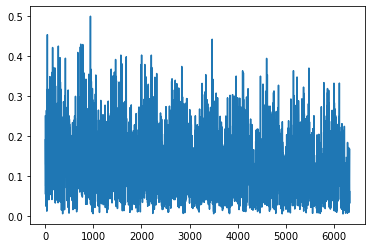

In [74]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 10
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(argument_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[2]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(argument_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     argument_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(argument_decoder.state_dict(), 'argument_decoder.pt')

show_plot(plot_losses)

# Train - Joint Action / Argument Predictor

updates:  697960
0m 0s (- 40m 28s) (100 0%) 1.6061
0m 0s (- 38m 47s) (200 0%) 0.7148
0m 0s (- 38m 43s) (300 0%) 0.5661
0m 1s (- 38m 41s) (400 0%) 0.6709
0m 1s (- 38m 24s) (500 0%) 0.3851
0m 1s (- 38m 17s) (600 0%) 0.9054
0m 2s (- 37m 54s) (700 0%) 0.8073
0m 2s (- 37m 39s) (800 0%) 0.8099
0m 2s (- 37m 37s) (900 0%) 0.5917
0m 3s (- 37m 36s) (1000 0%) 0.5153
0m 3s (- 37m 34s) (1100 0%) 0.2293
0m 3s (- 37m 23s) (1200 0%) 0.5349
0m 4s (- 37m 20s) (1300 0%) 0.4253
0m 4s (- 37m 28s) (1400 0%) 0.4273
0m 4s (- 37m 36s) (1500 0%) 0.6072
0m 5s (- 37m 51s) (1600 0%) 0.7082
0m 5s (- 37m 41s) (1700 0%) 0.6804
0m 5s (- 37m 43s) (1800 0%) 0.8368
0m 6s (- 37m 43s) (1900 0%) 0.4445
0m 6s (- 37m 50s) (2000 0%) 0.5864
0m 6s (- 37m 43s) (2100 0%) 0.7528
0m 7s (- 37m 36s) (2200 0%) 0.6883
0m 7s (- 37m 35s) (2300 0%) 0.4201
0m 7s (- 37m 35s) (2400 0%) 0.5375
0m 8s (- 37m 35s) (2500 0%) 0.4040
0m 8s (- 37m 35s) (2600 0%) 0.7249
0m 8s (- 37m 34s) (2700 0%) 0.6999
0m 9s (- 37m 31s) (2800 0%) 0.7688
0m 9s (- 37m

1m 15s (- 37m 38s) (22700 3%) 0.5438
1m 16s (- 37m 38s) (22800 3%) 0.8944
1m 16s (- 37m 37s) (22900 3%) 0.6965
1m 16s (- 37m 36s) (23000 3%) 0.5144
1m 17s (- 37m 35s) (23100 3%) 0.3839
1m 17s (- 37m 34s) (23200 3%) 0.4253
1m 17s (- 37m 33s) (23300 3%) 0.3340
1m 18s (- 37m 31s) (23400 3%) 0.6222
1m 18s (- 37m 29s) (23500 3%) 0.5532
1m 18s (- 37m 28s) (23600 3%) 0.9953
1m 19s (- 37m 27s) (23700 3%) 0.9638
1m 19s (- 37m 27s) (23800 3%) 0.6355
1m 19s (- 37m 26s) (23900 3%) 0.6875
1m 20s (- 37m 26s) (24000 3%) 0.3759
1m 20s (- 37m 26s) (24100 3%) 0.2956
1m 20s (- 37m 25s) (24200 3%) 0.3228
1m 20s (- 37m 24s) (24300 3%) 0.3929
1m 21s (- 37m 24s) (24400 3%) 0.4890
1m 21s (- 37m 23s) (24500 3%) 0.7835
1m 21s (- 37m 22s) (24600 3%) 0.4903
1m 22s (- 37m 22s) (24700 3%) 0.4164
1m 22s (- 37m 21s) (24800 3%) 0.3571
1m 22s (- 37m 21s) (24900 3%) 1.0914
1m 23s (- 37m 20s) (25000 3%) 0.8861
1m 23s (- 37m 20s) (25100 3%) 0.5881
1m 23s (- 37m 19s) (25200 3%) 0.7741
1m 24s (- 37m 19s) (25300 3%) 0.5129
1

2m 30s (- 36m 20s) (45000 6%) 0.7573
2m 30s (- 36m 20s) (45100 6%) 0.6012
2m 30s (- 36m 20s) (45200 6%) 0.7445
2m 31s (- 36m 19s) (45300 6%) 0.7369
2m 31s (- 36m 19s) (45400 6%) 0.4492
2m 31s (- 36m 19s) (45500 6%) 0.3540
2m 32s (- 36m 19s) (45600 6%) 0.6455
2m 32s (- 36m 18s) (45700 6%) 0.8793
2m 33s (- 36m 18s) (45800 6%) 0.5567
2m 33s (- 36m 19s) (45900 6%) 0.2861
2m 33s (- 36m 19s) (46000 6%) 0.7580
2m 34s (- 36m 20s) (46100 6%) 0.6528
2m 34s (- 36m 19s) (46200 6%) 0.3845
2m 34s (- 36m 19s) (46300 6%) 0.2004
2m 35s (- 36m 19s) (46400 6%) 0.6516
2m 35s (- 36m 19s) (46500 6%) 0.5636
2m 35s (- 36m 19s) (46600 6%) 0.5834
2m 36s (- 36m 19s) (46700 6%) 0.3695
2m 36s (- 36m 19s) (46800 6%) 0.2419
2m 36s (- 36m 18s) (46900 6%) 0.2910
2m 37s (- 36m 18s) (47000 6%) 0.5148
2m 37s (- 36m 18s) (47100 6%) 0.1885
2m 37s (- 36m 18s) (47200 6%) 0.4791
2m 38s (- 36m 17s) (47300 6%) 0.6889
2m 38s (- 36m 17s) (47400 6%) 0.5905
2m 38s (- 36m 17s) (47500 6%) 0.4242
2m 39s (- 36m 16s) (47600 6%) 0.4039
2

3m 46s (- 35m 20s) (67400 9%) 0.5480
3m 46s (- 35m 19s) (67500 9%) 0.5663
3m 47s (- 35m 19s) (67600 9%) 0.5104
3m 47s (- 35m 18s) (67700 9%) 0.7015
3m 47s (- 35m 18s) (67800 9%) 0.5289
3m 48s (- 35m 18s) (67900 9%) 0.6205
3m 48s (- 35m 18s) (68000 9%) 0.6110
3m 49s (- 35m 18s) (68100 9%) 0.2337
3m 49s (- 35m 18s) (68200 9%) 0.2500
3m 49s (- 35m 17s) (68300 9%) 0.1382
3m 50s (- 35m 17s) (68400 9%) 0.1201
3m 50s (- 35m 17s) (68500 9%) 0.2359
3m 50s (- 35m 17s) (68600 9%) 0.2380
3m 51s (- 35m 17s) (68700 9%) 0.1982
3m 51s (- 35m 16s) (68800 9%) 0.0960
3m 51s (- 35m 16s) (68900 9%) 0.2624
3m 52s (- 35m 16s) (69000 9%) 0.2529
3m 52s (- 35m 16s) (69100 9%) 0.0739
3m 52s (- 35m 16s) (69200 9%) 0.0474
3m 53s (- 35m 16s) (69300 9%) 0.1753
3m 53s (- 35m 15s) (69400 9%) 0.0773
3m 53s (- 35m 15s) (69500 9%) 0.0356
3m 54s (- 35m 15s) (69600 9%) 0.1035
3m 54s (- 35m 15s) (69700 9%) 0.2628
3m 55s (- 35m 15s) (69800 10%) 0.8108
3m 55s (- 35m 14s) (69900 10%) 0.5941
3m 55s (- 35m 14s) (70000 10%) 0.535

5m 0s (- 34m 8s) (89200 12%) 0.4651
5m 0s (- 34m 8s) (89300 12%) 0.4406
5m 0s (- 34m 7s) (89400 12%) 0.8006
5m 1s (- 34m 7s) (89500 12%) 0.3621
5m 1s (- 34m 6s) (89600 12%) 0.1850
5m 1s (- 34m 6s) (89700 12%) 0.3092
5m 2s (- 34m 5s) (89800 12%) 0.6097
5m 2s (- 34m 5s) (89900 12%) 0.3186
5m 2s (- 34m 4s) (90000 12%) 0.7125
5m 3s (- 34m 4s) (90100 12%) 0.2854
5m 3s (- 34m 3s) (90200 12%) 0.3098
5m 3s (- 34m 3s) (90300 12%) 0.4808
5m 4s (- 34m 3s) (90400 12%) 0.2987
5m 4s (- 34m 2s) (90500 12%) 0.4549
5m 4s (- 34m 2s) (90600 12%) 0.3818
5m 5s (- 34m 2s) (90700 12%) 0.4820
5m 5s (- 34m 2s) (90800 13%) 0.4803
5m 5s (- 34m 1s) (90900 13%) 0.5211
5m 6s (- 34m 1s) (91000 13%) 0.3704
5m 6s (- 34m 1s) (91100 13%) 0.6896
5m 6s (- 34m 0s) (91200 13%) 0.4736
5m 7s (- 34m 0s) (91300 13%) 0.6619
5m 7s (- 33m 59s) (91400 13%) 0.5567
5m 7s (- 33m 59s) (91500 13%) 0.3566
5m 8s (- 33m 59s) (91600 13%) 0.3458
5m 8s (- 33m 59s) (91700 13%) 0.5686
5m 8s (- 33m 58s) (91800 13%) 0.2540
5m 9s (- 33m 58s) (9190

6m 12s (- 32m 53s) (110800 15%) 0.3047
6m 12s (- 32m 53s) (110900 15%) 0.9604
6m 13s (- 32m 53s) (111000 15%) 0.5457
6m 13s (- 32m 52s) (111100 15%) 0.3520
6m 13s (- 32m 52s) (111200 15%) 1.1921
6m 14s (- 32m 51s) (111300 15%) 0.4094
6m 14s (- 32m 51s) (111400 15%) 0.8756
6m 14s (- 32m 51s) (111500 15%) 0.9344
6m 15s (- 32m 50s) (111600 15%) 0.6224
6m 15s (- 32m 50s) (111700 16%) 0.5291
6m 15s (- 32m 49s) (111800 16%) 0.2801
6m 16s (- 32m 49s) (111900 16%) 0.1809
6m 16s (- 32m 49s) (112000 16%) 0.1040
6m 16s (- 32m 48s) (112100 16%) 0.0478
6m 17s (- 32m 48s) (112200 16%) 0.3879
6m 17s (- 32m 48s) (112300 16%) 0.4492
6m 17s (- 32m 47s) (112400 16%) 0.7379
6m 18s (- 32m 47s) (112500 16%) 0.4891
6m 18s (- 32m 47s) (112600 16%) 0.1152
6m 18s (- 32m 46s) (112700 16%) 0.2859
6m 19s (- 32m 46s) (112800 16%) 0.3496
6m 19s (- 32m 46s) (112900 16%) 0.4123
6m 19s (- 32m 45s) (113000 16%) 0.4933
6m 20s (- 32m 45s) (113100 16%) 0.2070
6m 20s (- 32m 45s) (113200 16%) 0.1539
6m 20s (- 32m 44s) (11330

7m 24s (- 31m 45s) (132000 18%) 0.5589
7m 24s (- 31m 45s) (132100 18%) 0.3093
7m 25s (- 31m 45s) (132200 18%) 0.2685
7m 25s (- 31m 44s) (132300 18%) 1.0961
7m 25s (- 31m 44s) (132400 18%) 0.3434
7m 26s (- 31m 44s) (132500 18%) 0.1089
7m 26s (- 31m 43s) (132600 18%) 0.2118
7m 26s (- 31m 43s) (132700 19%) 0.4172
7m 27s (- 31m 42s) (132800 19%) 0.3563
7m 27s (- 31m 42s) (132900 19%) 0.5382
7m 27s (- 31m 42s) (133000 19%) 0.3044
7m 28s (- 31m 42s) (133100 19%) 0.0844
7m 28s (- 31m 41s) (133200 19%) 0.3013
7m 28s (- 31m 41s) (133300 19%) 0.2073
7m 29s (- 31m 41s) (133400 19%) 0.3668
7m 29s (- 31m 41s) (133500 19%) 0.1719
7m 30s (- 31m 40s) (133600 19%) 0.3635
7m 30s (- 31m 40s) (133700 19%) 0.5048
7m 30s (- 31m 40s) (133800 19%) 0.6434
7m 31s (- 31m 40s) (133900 19%) 0.9864
7m 31s (- 31m 39s) (134000 19%) 0.8001
7m 31s (- 31m 39s) (134100 19%) 0.6171
7m 32s (- 31m 39s) (134200 19%) 0.7318
7m 32s (- 31m 38s) (134300 19%) 0.2785
7m 32s (- 31m 38s) (134400 19%) 0.1113
7m 33s (- 31m 38s) (13450

8m 37s (- 30m 40s) (153200 21%) 0.9412
8m 38s (- 30m 40s) (153300 21%) 0.2907
8m 38s (- 30m 40s) (153400 21%) 0.5655
8m 38s (- 30m 39s) (153500 21%) 0.4629
8m 39s (- 30m 39s) (153600 22%) 0.5462
8m 39s (- 30m 39s) (153700 22%) 0.2271
8m 39s (- 30m 38s) (153800 22%) 0.6287
8m 40s (- 30m 38s) (153900 22%) 0.2707
8m 40s (- 30m 38s) (154000 22%) 0.5393
8m 40s (- 30m 37s) (154100 22%) 0.3928
8m 41s (- 30m 37s) (154200 22%) 0.4192
8m 41s (- 30m 37s) (154300 22%) 0.5398
8m 41s (- 30m 37s) (154400 22%) 0.2812
8m 42s (- 30m 36s) (154500 22%) 0.2513
8m 42s (- 30m 36s) (154600 22%) 0.5849
8m 42s (- 30m 36s) (154700 22%) 0.6697
8m 43s (- 30m 35s) (154800 22%) 0.4035
8m 43s (- 30m 35s) (154900 22%) 0.3937
8m 43s (- 30m 35s) (155000 22%) 0.8094
8m 44s (- 30m 34s) (155100 22%) 0.5565
8m 44s (- 30m 34s) (155200 22%) 0.2878
8m 45s (- 30m 34s) (155300 22%) 0.4403
8m 45s (- 30m 34s) (155400 22%) 0.5713
8m 45s (- 30m 33s) (155500 22%) 0.7922
8m 46s (- 30m 33s) (155600 22%) 0.4960
8m 46s (- 30m 33s) (15570

9m 50s (- 29m 32s) (174400 24%) 0.8662
9m 50s (- 29m 31s) (174500 25%) 0.5217
9m 51s (- 29m 31s) (174600 25%) 0.6264
9m 51s (- 29m 31s) (174700 25%) 0.6682
9m 51s (- 29m 30s) (174800 25%) 0.7953
9m 51s (- 29m 30s) (174900 25%) 0.6141
9m 52s (- 29m 29s) (175000 25%) 0.4966
9m 52s (- 29m 29s) (175100 25%) 0.4471
9m 52s (- 29m 29s) (175200 25%) 0.4286
9m 53s (- 29m 28s) (175300 25%) 0.5712
9m 53s (- 29m 28s) (175400 25%) 1.0048
9m 53s (- 29m 27s) (175500 25%) 0.8587
9m 54s (- 29m 27s) (175600 25%) 0.5566
9m 54s (- 29m 27s) (175700 25%) 0.6501
9m 54s (- 29m 26s) (175800 25%) 1.0516
9m 55s (- 29m 26s) (175900 25%) 0.6280
9m 55s (- 29m 26s) (176000 25%) 0.3564
9m 55s (- 29m 25s) (176100 25%) 0.8193
9m 56s (- 29m 25s) (176200 25%) 0.3893
9m 56s (- 29m 25s) (176300 25%) 0.2532
9m 56s (- 29m 24s) (176400 25%) 0.4142
9m 57s (- 29m 24s) (176500 25%) 0.5496
9m 57s (- 29m 23s) (176600 25%) 0.4100
9m 57s (- 29m 23s) (176700 25%) 0.5622
9m 58s (- 29m 23s) (176800 25%) 0.8009
9m 58s (- 29m 23s) (17690

10m 58s (- 28m 17s) (195100 27%) 0.0713
10m 59s (- 28m 17s) (195200 27%) 0.0670
10m 59s (- 28m 17s) (195300 27%) 0.3643
10m 59s (- 28m 16s) (195400 27%) 0.7662
11m 0s (- 28m 16s) (195500 28%) 0.6602
11m 0s (- 28m 15s) (195600 28%) 0.2657
11m 0s (- 28m 15s) (195700 28%) 0.5333
11m 0s (- 28m 15s) (195800 28%) 0.8039
11m 1s (- 28m 14s) (195900 28%) 0.2365
11m 1s (- 28m 14s) (196000 28%) 0.3551
11m 1s (- 28m 13s) (196100 28%) 0.2767
11m 2s (- 28m 13s) (196200 28%) 0.4588
11m 2s (- 28m 13s) (196300 28%) 0.6610
11m 2s (- 28m 12s) (196400 28%) 0.7197
11m 3s (- 28m 12s) (196500 28%) 0.5281
11m 3s (- 28m 11s) (196600 28%) 0.6755
11m 3s (- 28m 11s) (196700 28%) 0.7584
11m 4s (- 28m 11s) (196800 28%) 0.3285
11m 4s (- 28m 10s) (196900 28%) 0.4009
11m 4s (- 28m 10s) (197000 28%) 0.5639
11m 5s (- 28m 9s) (197100 28%) 0.2577
11m 5s (- 28m 9s) (197200 28%) 0.4942
11m 5s (- 28m 9s) (197300 28%) 0.2046
11m 5s (- 28m 8s) (197400 28%) 0.2566
11m 6s (- 28m 8s) (197500 28%) 0.1235
11m 6s (- 28m 8s) (197600 

12m 8s (- 27m 5s) (215900 30%) 0.3394
12m 8s (- 27m 5s) (216000 30%) 0.4112
12m 8s (- 27m 5s) (216100 30%) 0.6343
12m 9s (- 27m 4s) (216200 30%) 0.5048
12m 9s (- 27m 4s) (216300 30%) 0.4895
12m 9s (- 27m 3s) (216400 31%) 0.3224
12m 10s (- 27m 3s) (216500 31%) 0.3727
12m 10s (- 27m 3s) (216600 31%) 0.4910
12m 10s (- 27m 2s) (216700 31%) 0.6196
12m 11s (- 27m 2s) (216800 31%) 0.5422
12m 11s (- 27m 2s) (216900 31%) 0.5478
12m 11s (- 27m 1s) (217000 31%) 0.3152
12m 12s (- 27m 1s) (217100 31%) 0.0992
12m 12s (- 27m 1s) (217200 31%) 0.2449
12m 12s (- 27m 1s) (217300 31%) 0.3560
12m 13s (- 27m 0s) (217400 31%) 0.2918
12m 13s (- 27m 0s) (217500 31%) 0.3622
12m 13s (- 27m 0s) (217600 31%) 0.3364
12m 14s (- 26m 59s) (217700 31%) 0.2500
12m 14s (- 26m 59s) (217800 31%) 0.3393
12m 14s (- 26m 59s) (217900 31%) 0.1668
12m 15s (- 26m 58s) (218000 31%) 0.1650
12m 15s (- 26m 58s) (218100 31%) 0.5167
12m 16s (- 26m 58s) (218200 31%) 0.1836
12m 16s (- 26m 57s) (218300 31%) 0.3022
12m 16s (- 26m 57s) (218

13m 16s (- 25m 53s) (236600 33%) 0.3620
13m 17s (- 25m 53s) (236700 33%) 0.0575
13m 17s (- 25m 53s) (236800 33%) 0.1171
13m 17s (- 25m 52s) (236900 33%) 0.1831
13m 18s (- 25m 52s) (237000 33%) 0.2105
13m 18s (- 25m 52s) (237100 33%) 0.1514
13m 18s (- 25m 51s) (237200 33%) 0.2144
13m 19s (- 25m 51s) (237300 33%) 0.2210
13m 19s (- 25m 51s) (237400 34%) 0.3167
13m 19s (- 25m 50s) (237500 34%) 0.1378
13m 20s (- 25m 50s) (237600 34%) 0.1251
13m 20s (- 25m 49s) (237700 34%) 0.2813
13m 20s (- 25m 49s) (237800 34%) 0.2599
13m 21s (- 25m 49s) (237900 34%) 0.5460
13m 21s (- 25m 48s) (238000 34%) 0.1008
13m 21s (- 25m 48s) (238100 34%) 0.8104
13m 22s (- 25m 48s) (238200 34%) 0.7380
13m 22s (- 25m 47s) (238300 34%) 0.3272
13m 22s (- 25m 47s) (238400 34%) 0.4163
13m 23s (- 25m 47s) (238500 34%) 0.3338
13m 23s (- 25m 46s) (238600 34%) 0.3171
13m 23s (- 25m 46s) (238700 34%) 0.3434
13m 24s (- 25m 46s) (238800 34%) 0.2663
13m 24s (- 25m 45s) (238900 34%) 0.2245
13m 24s (- 25m 45s) (239000 34%) 0.0914


14m 24s (- 24m 40s) (257300 36%) 0.4624
14m 24s (- 24m 40s) (257400 36%) 0.4818
14m 25s (- 24m 39s) (257500 36%) 0.4782
14m 25s (- 24m 39s) (257600 36%) 0.8698
14m 25s (- 24m 39s) (257700 36%) 0.3976
14m 26s (- 24m 38s) (257800 36%) 0.4203
14m 26s (- 24m 38s) (257900 36%) 0.4729
14m 26s (- 24m 38s) (258000 36%) 0.2192
14m 27s (- 24m 37s) (258100 36%) 0.1634
14m 27s (- 24m 37s) (258200 36%) 0.2633
14m 27s (- 24m 37s) (258300 37%) 0.3865
14m 28s (- 24m 37s) (258400 37%) 0.1181
14m 28s (- 24m 36s) (258500 37%) 0.4265
14m 28s (- 24m 36s) (258600 37%) 0.3595
14m 29s (- 24m 36s) (258700 37%) 0.5730
14m 29s (- 24m 35s) (258800 37%) 0.3970
14m 30s (- 24m 35s) (258900 37%) 0.6564
14m 30s (- 24m 35s) (259000 37%) 0.2645
14m 30s (- 24m 34s) (259100 37%) 0.3063
14m 31s (- 24m 34s) (259200 37%) 0.3787
14m 31s (- 24m 34s) (259300 37%) 0.8833
14m 31s (- 24m 33s) (259400 37%) 0.5603
14m 31s (- 24m 33s) (259500 37%) 0.1931
14m 32s (- 24m 33s) (259600 37%) 0.3477
14m 32s (- 24m 32s) (259700 37%) 0.2696


15m 32s (- 23m 28s) (278000 39%) 0.4179
15m 33s (- 23m 28s) (278100 39%) 0.5310
15m 33s (- 23m 28s) (278200 39%) 0.6789
15m 33s (- 23m 27s) (278300 39%) 0.4182
15m 33s (- 23m 27s) (278400 39%) 0.2830
15m 34s (- 23m 27s) (278500 39%) 0.4093
15m 34s (- 23m 26s) (278600 39%) 0.2559
15m 34s (- 23m 26s) (278700 39%) 0.1930
15m 35s (- 23m 26s) (278800 39%) 0.4876
15m 35s (- 23m 25s) (278900 39%) 0.5185
15m 35s (- 23m 25s) (279000 39%) 0.4358
15m 36s (- 23m 25s) (279100 39%) 0.4808
15m 36s (- 23m 24s) (279200 40%) 0.5803
15m 36s (- 23m 24s) (279300 40%) 1.5234
15m 37s (- 23m 24s) (279400 40%) 0.5772
15m 37s (- 23m 23s) (279500 40%) 0.6166
15m 37s (- 23m 23s) (279600 40%) 0.6897
15m 38s (- 23m 23s) (279700 40%) 0.3236
15m 38s (- 23m 22s) (279800 40%) 0.8885
15m 38s (- 23m 22s) (279900 40%) 0.7564
15m 39s (- 23m 21s) (280000 40%) 0.8280
15m 39s (- 23m 21s) (280100 40%) 0.5619
15m 39s (- 23m 21s) (280200 40%) 0.4859
15m 40s (- 23m 20s) (280300 40%) 0.1562
15m 40s (- 23m 20s) (280400 40%) 0.5478


16m 40s (- 22m 17s) (298700 42%) 0.5602
16m 41s (- 22m 17s) (298800 42%) 0.5480
16m 41s (- 22m 17s) (298900 42%) 0.4787
16m 41s (- 22m 16s) (299000 42%) 0.3772
16m 42s (- 22m 16s) (299100 42%) 0.3973
16m 42s (- 22m 16s) (299200 42%) 0.4827
16m 42s (- 22m 15s) (299300 42%) 0.7199
16m 43s (- 22m 15s) (299400 42%) 0.5039
16m 43s (- 22m 15s) (299500 42%) 0.3264
16m 43s (- 22m 14s) (299600 42%) 0.4587
16m 44s (- 22m 14s) (299700 42%) 0.2006
16m 44s (- 22m 14s) (299800 42%) 0.3725
16m 44s (- 22m 13s) (299900 42%) 0.4444
16m 45s (- 22m 13s) (300000 42%) 0.3690
16m 45s (- 22m 13s) (300100 42%) 0.2573
16m 45s (- 22m 12s) (300200 43%) 0.9936
16m 46s (- 22m 12s) (300300 43%) 1.2837
16m 46s (- 22m 12s) (300400 43%) 1.1244
16m 46s (- 22m 11s) (300500 43%) 0.6111
16m 47s (- 22m 11s) (300600 43%) 0.5610
16m 47s (- 22m 11s) (300700 43%) 0.5058
16m 47s (- 22m 10s) (300800 43%) 0.9597
16m 48s (- 22m 10s) (300900 43%) 0.4114
16m 48s (- 22m 10s) (301000 43%) 0.7034
16m 48s (- 22m 9s) (301100 43%) 0.4864
1

17m 48s (- 21m 6s) (319400 45%) 0.5151
17m 49s (- 21m 6s) (319500 45%) 0.5558
17m 49s (- 21m 6s) (319600 45%) 0.4339
17m 49s (- 21m 5s) (319700 45%) 0.4464
17m 50s (- 21m 5s) (319800 45%) 0.4495
17m 50s (- 21m 5s) (319900 45%) 0.6727
17m 50s (- 21m 4s) (320000 45%) 0.6457
17m 51s (- 21m 4s) (320100 45%) 0.4909
17m 51s (- 21m 4s) (320200 45%) 0.4854
17m 51s (- 21m 3s) (320300 45%) 0.6459
17m 52s (- 21m 3s) (320400 45%) 0.7825
17m 52s (- 21m 3s) (320500 45%) 0.8295
17m 52s (- 21m 2s) (320600 45%) 0.2160
17m 53s (- 21m 2s) (320700 45%) 0.3736
17m 53s (- 21m 2s) (320800 45%) 0.6823
17m 53s (- 21m 1s) (320900 45%) 0.2288
17m 54s (- 21m 1s) (321000 45%) 0.9901
17m 54s (- 21m 0s) (321100 46%) 0.8534
17m 54s (- 21m 0s) (321200 46%) 0.3776
17m 55s (- 21m 0s) (321300 46%) 0.5166
17m 55s (- 20m 59s) (321400 46%) 0.1541
17m 55s (- 20m 59s) (321500 46%) 0.4695
17m 56s (- 20m 59s) (321600 46%) 0.3553
17m 56s (- 20m 58s) (321700 46%) 0.4808
17m 56s (- 20m 58s) (321800 46%) 0.7710
17m 56s (- 20m 58s) 

18m 56s (- 19m 56s) (340100 48%) 0.4481
18m 57s (- 19m 55s) (340200 48%) 0.5126
18m 57s (- 19m 55s) (340300 48%) 0.4047
18m 57s (- 19m 55s) (340400 48%) 0.8630
18m 58s (- 19m 54s) (340500 48%) 0.2961
18m 58s (- 19m 54s) (340600 48%) 0.4078
18m 58s (- 19m 54s) (340700 48%) 0.3723
18m 59s (- 19m 53s) (340800 48%) 0.5867
18m 59s (- 19m 53s) (340900 48%) 0.4694
18m 59s (- 19m 53s) (341000 48%) 0.6791
19m 0s (- 19m 53s) (341100 48%) 0.5813
19m 0s (- 19m 52s) (341200 48%) 0.5204
19m 0s (- 19m 52s) (341300 48%) 0.4921
19m 1s (- 19m 51s) (341400 48%) 0.3676
19m 1s (- 19m 51s) (341500 48%) 0.5193
19m 1s (- 19m 51s) (341600 48%) 0.5778
19m 2s (- 19m 50s) (341700 48%) 0.2069
19m 2s (- 19m 50s) (341800 48%) 0.5082
19m 2s (- 19m 50s) (341900 48%) 0.2322
19m 3s (- 19m 49s) (342000 48%) 0.0395
19m 3s (- 19m 49s) (342100 49%) 0.3106
19m 3s (- 19m 49s) (342200 49%) 0.4281
19m 4s (- 19m 48s) (342300 49%) 0.2307
19m 4s (- 19m 48s) (342400 49%) 0.1876
19m 4s (- 19m 48s) (342500 49%) 0.2937
19m 5s (- 19m 4

20m 4s (- 18m 45s) (360800 51%) 0.0326
20m 5s (- 18m 45s) (360900 51%) 0.2988
20m 5s (- 18m 45s) (361000 51%) 0.3327
20m 5s (- 18m 44s) (361100 51%) 0.1090
20m 6s (- 18m 44s) (361200 51%) 0.1424
20m 6s (- 18m 44s) (361300 51%) 0.3449
20m 6s (- 18m 43s) (361400 51%) 0.5071
20m 7s (- 18m 43s) (361500 51%) 0.1729
20m 7s (- 18m 43s) (361600 51%) 0.1996
20m 7s (- 18m 42s) (361700 51%) 0.3858
20m 8s (- 18m 42s) (361800 51%) 0.2671
20m 8s (- 18m 42s) (361900 51%) 0.5364
20m 8s (- 18m 41s) (362000 51%) 0.6930
20m 9s (- 18m 41s) (362100 51%) 0.2556
20m 9s (- 18m 41s) (362200 51%) 0.3949
20m 9s (- 18m 40s) (362300 51%) 0.4054
20m 10s (- 18m 40s) (362400 51%) 0.3865
20m 10s (- 18m 40s) (362500 51%) 0.3834
20m 10s (- 18m 39s) (362600 51%) 0.4137
20m 10s (- 18m 39s) (362700 51%) 0.5654
20m 11s (- 18m 38s) (362800 51%) 0.5581
20m 11s (- 18m 38s) (362900 51%) 0.5723
20m 11s (- 18m 38s) (363000 52%) 0.3218
20m 12s (- 18m 37s) (363100 52%) 0.3861
20m 12s (- 18m 37s) (363200 52%) 0.2418
20m 12s (- 18m 3

21m 12s (- 17m 35s) (381500 54%) 0.0950
21m 13s (- 17m 35s) (381600 54%) 0.4547
21m 13s (- 17m 35s) (381700 54%) 0.1650
21m 13s (- 17m 34s) (381800 54%) 0.3906
21m 14s (- 17m 34s) (381900 54%) 0.2782
21m 14s (- 17m 34s) (382000 54%) 0.2502
21m 14s (- 17m 33s) (382100 54%) 0.1892
21m 15s (- 17m 33s) (382200 54%) 0.4604
21m 15s (- 17m 33s) (382300 54%) 0.4820
21m 15s (- 17m 32s) (382400 54%) 0.2987
21m 16s (- 17m 32s) (382500 54%) 0.3251
21m 16s (- 17m 32s) (382600 54%) 0.5827
21m 16s (- 17m 31s) (382700 54%) 0.3793
21m 17s (- 17m 31s) (382800 54%) 0.3041
21m 17s (- 17m 31s) (382900 54%) 0.3658
21m 17s (- 17m 30s) (383000 54%) 0.3470
21m 18s (- 17m 30s) (383100 54%) 0.7544
21m 18s (- 17m 30s) (383200 54%) 0.8132
21m 18s (- 17m 29s) (383300 54%) 0.6739
21m 19s (- 17m 29s) (383400 54%) 0.4627
21m 19s (- 17m 29s) (383500 54%) 0.4770
21m 19s (- 17m 28s) (383600 54%) 0.3917
21m 20s (- 17m 28s) (383700 54%) 0.5071
21m 20s (- 17m 28s) (383800 54%) 0.4113
21m 20s (- 17m 27s) (383900 55%) 0.4473


22m 20s (- 16m 25s) (402200 57%) 0.6370
22m 20s (- 16m 25s) (402300 57%) 0.6085
22m 21s (- 16m 25s) (402400 57%) 0.4294
22m 21s (- 16m 24s) (402500 57%) 0.3343
22m 21s (- 16m 24s) (402600 57%) 0.1483
22m 22s (- 16m 24s) (402700 57%) 0.5842
22m 22s (- 16m 23s) (402800 57%) 0.8043
22m 22s (- 16m 23s) (402900 57%) 0.7576
22m 23s (- 16m 23s) (403000 57%) 0.5600
22m 23s (- 16m 22s) (403100 57%) 0.5010
22m 23s (- 16m 22s) (403200 57%) 0.2455
22m 24s (- 16m 22s) (403300 57%) 0.2695
22m 24s (- 16m 21s) (403400 57%) 0.2321
22m 24s (- 16m 21s) (403500 57%) 0.1445
22m 25s (- 16m 21s) (403600 57%) 0.1695
22m 25s (- 16m 20s) (403700 57%) 0.5151
22m 25s (- 16m 20s) (403800 57%) 0.6092
22m 26s (- 16m 20s) (403900 57%) 0.8520
22m 26s (- 16m 19s) (404000 57%) 0.3936
22m 26s (- 16m 19s) (404100 57%) 0.4417
22m 27s (- 16m 19s) (404200 57%) 0.2190
22m 27s (- 16m 18s) (404300 57%) 0.3698
22m 27s (- 16m 18s) (404400 57%) 0.1602
22m 28s (- 16m 18s) (404500 57%) 0.6433
22m 28s (- 16m 17s) (404600 57%) 0.1493


23m 29s (- 15m 16s) (422900 60%) 0.3425
23m 29s (- 15m 16s) (423000 60%) 0.5658
23m 29s (- 15m 15s) (423100 60%) 0.2075
23m 30s (- 15m 15s) (423200 60%) 0.0987
23m 30s (- 15m 15s) (423300 60%) 0.8177
23m 30s (- 15m 14s) (423400 60%) 0.5008
23m 31s (- 15m 14s) (423500 60%) 0.5878
23m 31s (- 15m 14s) (423600 60%) 0.4845
23m 31s (- 15m 13s) (423700 60%) 0.3967
23m 32s (- 15m 13s) (423800 60%) 0.3182
23m 32s (- 15m 13s) (423900 60%) 1.0252
23m 32s (- 15m 12s) (424000 60%) 0.6834
23m 33s (- 15m 12s) (424100 60%) 0.4626
23m 33s (- 15m 12s) (424200 60%) 0.5991
23m 33s (- 15m 11s) (424300 60%) 0.4343
23m 34s (- 15m 11s) (424400 60%) 0.5018
23m 34s (- 15m 11s) (424500 60%) 0.4161
23m 34s (- 15m 10s) (424600 60%) 0.2533
23m 35s (- 15m 10s) (424700 60%) 0.2078
23m 35s (- 15m 10s) (424800 60%) 0.1809
23m 35s (- 15m 9s) (424900 60%) 0.1068
23m 36s (- 15m 9s) (425000 60%) 0.0927
23m 36s (- 15m 9s) (425100 60%) 0.3266
23m 36s (- 15m 8s) (425200 60%) 0.4387
23m 37s (- 15m 8s) (425300 60%) 0.5134
23m 3

24m 38s (- 14m 7s) (443600 63%) 0.3814
24m 38s (- 14m 7s) (443700 63%) 1.3366
24m 38s (- 14m 6s) (443800 63%) 0.6560
24m 39s (- 14m 6s) (443900 63%) 0.7453
24m 39s (- 14m 6s) (444000 63%) 0.7175
24m 39s (- 14m 5s) (444100 63%) 0.4040
24m 40s (- 14m 5s) (444200 63%) 0.5565
24m 40s (- 14m 5s) (444300 63%) 0.6374
24m 40s (- 14m 4s) (444400 63%) 0.5279
24m 41s (- 14m 4s) (444500 63%) 0.4714
24m 41s (- 14m 4s) (444600 63%) 0.6514
24m 41s (- 14m 3s) (444700 63%) 0.7657
24m 42s (- 14m 3s) (444800 63%) 0.7974
24m 42s (- 14m 3s) (444900 63%) 0.5882
24m 42s (- 14m 2s) (445000 63%) 0.6435
24m 43s (- 14m 2s) (445100 63%) 0.6089
24m 43s (- 14m 2s) (445200 63%) 0.6399
24m 43s (- 14m 1s) (445300 63%) 0.4770
24m 44s (- 14m 1s) (445400 63%) 0.4193
24m 44s (- 14m 1s) (445500 63%) 0.3543
24m 44s (- 14m 0s) (445600 63%) 0.4026
24m 45s (- 14m 0s) (445700 63%) 0.4295
24m 45s (- 14m 0s) (445800 63%) 0.5847
24m 45s (- 13m 59s) (445900 63%) 0.5029
24m 46s (- 13m 59s) (446000 63%) 0.4497
24m 46s (- 13m 59s) (44

25m 45s (- 12m 57s) (464300 66%) 0.3342
25m 45s (- 12m 57s) (464400 66%) 0.7003
25m 45s (- 12m 56s) (464500 66%) 0.7203
25m 45s (- 12m 56s) (464600 66%) 0.5117
25m 46s (- 12m 56s) (464700 66%) 0.3660
25m 46s (- 12m 55s) (464800 66%) 0.7987
25m 47s (- 12m 55s) (464900 66%) 0.5345
25m 47s (- 12m 55s) (465000 66%) 0.3182
25m 47s (- 12m 54s) (465100 66%) 0.2996
25m 47s (- 12m 54s) (465200 66%) 0.5531
25m 48s (- 12m 54s) (465300 66%) 0.6142
25m 48s (- 12m 53s) (465400 66%) 0.5427
25m 49s (- 12m 53s) (465500 66%) 0.2602
25m 49s (- 12m 53s) (465600 66%) 0.2566
25m 49s (- 12m 52s) (465700 66%) 0.3103
25m 50s (- 12m 52s) (465800 66%) 0.5089
25m 50s (- 12m 52s) (465900 66%) 0.1931
25m 50s (- 12m 51s) (466000 66%) 0.6795
25m 51s (- 12m 51s) (466100 66%) 0.5570
25m 51s (- 12m 51s) (466200 66%) 0.6230
25m 51s (- 12m 50s) (466300 66%) 0.3748
25m 51s (- 12m 50s) (466400 66%) 0.3948
25m 52s (- 12m 50s) (466500 66%) 0.3717
25m 52s (- 12m 49s) (466600 66%) 0.5044
25m 52s (- 12m 49s) (466700 66%) 0.5501


26m 53s (- 11m 48s) (485000 69%) 0.7322
26m 53s (- 11m 48s) (485100 69%) 0.4887
26m 54s (- 11m 47s) (485200 69%) 0.4542
26m 54s (- 11m 47s) (485300 69%) 0.3631
26m 54s (- 11m 47s) (485400 69%) 0.3252
26m 55s (- 11m 46s) (485500 69%) 0.5781
26m 55s (- 11m 46s) (485600 69%) 0.2643
26m 55s (- 11m 46s) (485700 69%) 0.4025
26m 56s (- 11m 45s) (485800 69%) 0.4587
26m 56s (- 11m 45s) (485900 69%) 0.2734
26m 56s (- 11m 45s) (486000 69%) 0.4751
26m 57s (- 11m 44s) (486100 69%) 0.4843
26m 57s (- 11m 44s) (486200 69%) 0.4794
26m 57s (- 11m 44s) (486300 69%) 0.5395
26m 58s (- 11m 43s) (486400 69%) 0.4969
26m 58s (- 11m 43s) (486500 69%) 0.7135
26m 58s (- 11m 43s) (486600 69%) 0.4637
26m 59s (- 11m 42s) (486700 69%) 0.6251
26m 59s (- 11m 42s) (486800 69%) 0.5505
26m 59s (- 11m 42s) (486900 69%) 0.2585
27m 0s (- 11m 41s) (487000 69%) 0.2147
27m 0s (- 11m 41s) (487100 69%) 0.1305
27m 0s (- 11m 41s) (487200 69%) 0.2289
27m 1s (- 11m 40s) (487300 69%) 0.1807
27m 1s (- 11m 40s) (487400 69%) 0.2153
27m 1

28m 1s (- 10m 39s) (505700 72%) 0.0915
28m 1s (- 10m 38s) (505800 72%) 0.2713
28m 1s (- 10m 38s) (505900 72%) 0.2215
28m 2s (- 10m 38s) (506000 72%) 0.1259
28m 2s (- 10m 37s) (506100 72%) 0.2483
28m 2s (- 10m 37s) (506200 72%) 0.2042
28m 3s (- 10m 37s) (506300 72%) 0.1469
28m 3s (- 10m 36s) (506400 72%) 0.0794
28m 3s (- 10m 36s) (506500 72%) 0.1489
28m 4s (- 10m 36s) (506600 72%) 0.2653
28m 4s (- 10m 35s) (506700 72%) 0.1882
28m 4s (- 10m 35s) (506800 72%) 0.4795
28m 5s (- 10m 35s) (506900 72%) 0.1849
28m 5s (- 10m 34s) (507000 72%) 0.2855
28m 5s (- 10m 34s) (507100 72%) 0.2287
28m 6s (- 10m 34s) (507200 72%) 0.5351
28m 6s (- 10m 33s) (507300 72%) 0.3290
28m 6s (- 10m 33s) (507400 72%) 0.5220
28m 7s (- 10m 33s) (507500 72%) 0.5577
28m 7s (- 10m 32s) (507600 72%) 0.4379
28m 7s (- 10m 32s) (507700 72%) 0.4890
28m 7s (- 10m 32s) (507800 72%) 0.3299
28m 8s (- 10m 31s) (507900 72%) 0.3317
28m 8s (- 10m 31s) (508000 72%) 0.3698
28m 8s (- 10m 31s) (508100 72%) 0.4879
28m 9s (- 10m 30s) (50820

29m 8s (- 9m 28s) (526700 75%) 0.1465
29m 9s (- 9m 28s) (526800 75%) 0.9338
29m 9s (- 9m 27s) (526900 75%) 0.5178
29m 9s (- 9m 27s) (527000 75%) 0.2794
29m 10s (- 9m 27s) (527100 75%) 0.7068
29m 10s (- 9m 26s) (527200 75%) 0.5156
29m 10s (- 9m 26s) (527300 75%) 0.4949
29m 11s (- 9m 26s) (527400 75%) 0.5185
29m 11s (- 9m 25s) (527500 75%) 0.4115
29m 11s (- 9m 25s) (527600 75%) 0.2657
29m 11s (- 9m 25s) (527700 75%) 0.4903
29m 12s (- 9m 24s) (527800 75%) 0.4032
29m 12s (- 9m 24s) (527900 75%) 0.3829
29m 12s (- 9m 24s) (528000 75%) 0.5528
29m 13s (- 9m 23s) (528100 75%) 0.4206
29m 13s (- 9m 23s) (528200 75%) 0.4886
29m 13s (- 9m 23s) (528300 75%) 0.3676
29m 14s (- 9m 22s) (528400 75%) 0.5789
29m 14s (- 9m 22s) (528500 75%) 0.4691
29m 14s (- 9m 22s) (528600 75%) 0.4500
29m 15s (- 9m 21s) (528700 75%) 0.5908
29m 15s (- 9m 21s) (528800 75%) 0.4694
29m 15s (- 9m 21s) (528900 75%) 0.3659
29m 16s (- 9m 20s) (529000 75%) 0.4756
29m 16s (- 9m 20s) (529100 75%) 0.7172
29m 16s (- 9m 20s) (529200 75

30m 17s (- 8m 17s) (547900 78%) 0.1459
30m 18s (- 8m 17s) (548000 78%) 0.3225
30m 18s (- 8m 17s) (548100 78%) 0.1472
30m 19s (- 8m 16s) (548200 78%) 0.0957
30m 19s (- 8m 16s) (548300 78%) 0.2971
30m 19s (- 8m 16s) (548400 78%) 0.1684
30m 20s (- 8m 15s) (548500 78%) 0.2709
30m 20s (- 8m 15s) (548600 78%) 0.2132
30m 20s (- 8m 15s) (548700 78%) 0.1749
30m 21s (- 8m 14s) (548800 78%) 0.2230
30m 21s (- 8m 14s) (548900 78%) 0.1683
30m 21s (- 8m 14s) (549000 78%) 0.3198
30m 22s (- 8m 13s) (549100 78%) 0.3989
30m 22s (- 8m 13s) (549200 78%) 0.5842
30m 22s (- 8m 13s) (549300 78%) 0.4270
30m 23s (- 8m 12s) (549400 78%) 0.8180
30m 23s (- 8m 12s) (549500 78%) 0.6081
30m 23s (- 8m 12s) (549600 78%) 0.5200
30m 24s (- 8m 11s) (549700 78%) 0.3061
30m 24s (- 8m 11s) (549800 78%) 0.6628
30m 24s (- 8m 11s) (549900 78%) 0.5942
30m 25s (- 8m 11s) (550000 78%) 0.4575
30m 25s (- 8m 10s) (550100 78%) 0.5075
30m 25s (- 8m 10s) (550200 78%) 0.3263
30m 26s (- 8m 9s) (550300 78%) 0.2103
30m 26s (- 8m 9s) (550400 

31m 29s (- 7m 7s) (569100 81%) 0.3807
31m 29s (- 7m 7s) (569200 81%) 0.3669
31m 29s (- 7m 7s) (569300 81%) 0.5967
31m 30s (- 7m 6s) (569400 81%) 0.2441
31m 30s (- 7m 6s) (569500 81%) 0.2609
31m 30s (- 7m 6s) (569600 81%) 0.4303
31m 31s (- 7m 5s) (569700 81%) 0.4717
31m 31s (- 7m 5s) (569800 81%) 0.4236
31m 31s (- 7m 5s) (569900 81%) 1.0416
31m 32s (- 7m 4s) (570000 81%) 0.4887
31m 32s (- 7m 4s) (570100 81%) 0.5707
31m 32s (- 7m 4s) (570200 81%) 0.2187
31m 33s (- 7m 3s) (570300 81%) 0.2266
31m 33s (- 7m 3s) (570400 81%) 0.2708
31m 33s (- 7m 3s) (570500 81%) 0.4045
31m 34s (- 7m 2s) (570600 81%) 0.5317
31m 34s (- 7m 2s) (570700 81%) 0.5843
31m 34s (- 7m 2s) (570800 81%) 0.6176
31m 35s (- 7m 1s) (570900 81%) 0.7986
31m 35s (- 7m 1s) (571000 81%) 0.4174
31m 35s (- 7m 1s) (571100 81%) 0.4380
31m 36s (- 7m 0s) (571200 81%) 0.3419
31m 36s (- 7m 0s) (571300 81%) 0.3957
31m 36s (- 7m 0s) (571400 81%) 0.5791
31m 37s (- 6m 59s) (571500 81%) 0.3665
31m 37s (- 6m 59s) (571600 81%) 0.5980
31m 37s (-

32m 39s (- 5m 57s) (590400 84%) 0.3655
32m 40s (- 5m 56s) (590500 84%) 0.7135
32m 40s (- 5m 56s) (590600 84%) 0.5095
32m 40s (- 5m 56s) (590700 84%) 1.0238
32m 41s (- 5m 55s) (590800 84%) 0.5740
32m 41s (- 5m 55s) (590900 84%) 0.5803
32m 41s (- 5m 55s) (591000 84%) 0.6283
32m 42s (- 5m 54s) (591100 84%) 0.5062
32m 42s (- 5m 54s) (591200 84%) 0.8356
32m 42s (- 5m 54s) (591300 84%) 0.4674
32m 43s (- 5m 53s) (591400 84%) 0.1534
32m 43s (- 5m 53s) (591500 84%) 0.6288
32m 43s (- 5m 53s) (591600 84%) 1.2011
32m 44s (- 5m 52s) (591700 84%) 0.4305
32m 44s (- 5m 52s) (591800 84%) 0.2434
32m 44s (- 5m 52s) (591900 84%) 0.2474
32m 45s (- 5m 51s) (592000 84%) 1.4540
32m 45s (- 5m 51s) (592100 84%) 0.6237
32m 45s (- 5m 51s) (592200 84%) 0.5572
32m 46s (- 5m 50s) (592300 84%) 0.8982
32m 46s (- 5m 50s) (592400 84%) 0.3640
32m 46s (- 5m 50s) (592500 84%) 0.5302
32m 47s (- 5m 49s) (592600 84%) 0.9883
32m 47s (- 5m 49s) (592700 84%) 1.4193
32m 47s (- 5m 49s) (592800 84%) 0.8268
32m 48s (- 5m 48s) (59290

33m 49s (- 4m 46s) (611600 87%) 0.4314
33m 50s (- 4m 46s) (611700 87%) 0.1673
33m 50s (- 4m 45s) (611800 87%) 0.1793
33m 50s (- 4m 45s) (611900 87%) 0.1514
33m 51s (- 4m 45s) (612000 87%) 0.1979
33m 51s (- 4m 44s) (612100 87%) 0.4753
33m 51s (- 4m 44s) (612200 87%) 0.8666
33m 52s (- 4m 44s) (612300 87%) 0.2431
33m 52s (- 4m 43s) (612400 87%) 0.3780
33m 52s (- 4m 43s) (612500 87%) 0.2997
33m 53s (- 4m 43s) (612600 87%) 0.3416
33m 53s (- 4m 42s) (612700 87%) 0.6347
33m 53s (- 4m 42s) (612800 87%) 0.3734
33m 54s (- 4m 42s) (612900 87%) 0.5335
33m 54s (- 4m 41s) (613000 87%) 0.4225
33m 54s (- 4m 41s) (613100 87%) 0.2878
33m 55s (- 4m 41s) (613200 87%) 0.1684
33m 55s (- 4m 40s) (613300 87%) 0.3520
33m 55s (- 4m 40s) (613400 87%) 0.4439
33m 56s (- 4m 40s) (613500 87%) 0.2539
33m 56s (- 4m 39s) (613600 87%) 0.1557
33m 56s (- 4m 39s) (613700 87%) 0.2109
33m 57s (- 4m 39s) (613800 87%) 0.1422
33m 57s (- 4m 38s) (613900 87%) 0.0570
33m 57s (- 4m 38s) (614000 87%) 0.1582
33m 58s (- 4m 38s) (61410

34m 59s (- 3m 36s) (632800 90%) 0.1375
35m 0s (- 3m 35s) (632900 90%) 0.1318
35m 0s (- 3m 35s) (633000 90%) 0.0543
35m 0s (- 3m 35s) (633100 90%) 0.0948
35m 1s (- 3m 34s) (633200 90%) 0.5892
35m 1s (- 3m 34s) (633300 90%) 0.6343
35m 1s (- 3m 34s) (633400 90%) 0.4355
35m 2s (- 3m 33s) (633500 90%) 0.2618
35m 2s (- 3m 33s) (633600 90%) 0.4653
35m 2s (- 3m 33s) (633700 90%) 0.4131
35m 2s (- 3m 32s) (633800 90%) 0.3310
35m 3s (- 3m 32s) (633900 90%) 0.3795
35m 3s (- 3m 32s) (634000 90%) 0.3201
35m 3s (- 3m 31s) (634100 90%) 0.3803
35m 4s (- 3m 31s) (634200 90%) 0.4099
35m 4s (- 3m 31s) (634300 90%) 0.2974
35m 4s (- 3m 30s) (634400 90%) 0.2606
35m 5s (- 3m 30s) (634500 90%) 0.2875
35m 5s (- 3m 30s) (634600 90%) 0.4962
35m 5s (- 3m 29s) (634700 90%) 0.3939
35m 6s (- 3m 29s) (634800 90%) 0.3518
35m 6s (- 3m 29s) (634900 90%) 0.6438
35m 6s (- 3m 28s) (635000 90%) 0.5150
35m 6s (- 3m 28s) (635100 90%) 0.3966
35m 7s (- 3m 28s) (635200 91%) 0.3780
35m 7s (- 3m 27s) (635300 91%) 0.2616
35m 7s (- 3

36m 8s (- 2m 25s) (654100 93%) 0.3262
36m 8s (- 2m 25s) (654200 93%) 0.4183
36m 9s (- 2m 24s) (654300 93%) 0.4226
36m 9s (- 2m 24s) (654400 93%) 0.3305
36m 9s (- 2m 24s) (654500 93%) 0.4668
36m 10s (- 2m 23s) (654600 93%) 0.2005
36m 10s (- 2m 23s) (654700 93%) 0.2832
36m 10s (- 2m 23s) (654800 93%) 0.1018
36m 11s (- 2m 22s) (654900 93%) 0.1789
36m 11s (- 2m 22s) (655000 93%) 0.4351
36m 11s (- 2m 22s) (655100 93%) 0.3574
36m 12s (- 2m 21s) (655200 93%) 0.3759
36m 12s (- 2m 21s) (655300 93%) 0.1767
36m 12s (- 2m 21s) (655400 93%) 0.3682
36m 13s (- 2m 20s) (655500 93%) 0.0408
36m 13s (- 2m 20s) (655600 93%) 0.1781
36m 13s (- 2m 20s) (655700 93%) 0.1625
36m 14s (- 2m 19s) (655800 93%) 0.2202
36m 14s (- 2m 19s) (655900 93%) 0.1204
36m 14s (- 2m 19s) (656000 93%) 0.2471
36m 15s (- 2m 18s) (656100 94%) 0.1784
36m 15s (- 2m 18s) (656200 94%) 0.3321
36m 15s (- 2m 18s) (656300 94%) 0.1739
36m 16s (- 2m 17s) (656400 94%) 0.0544
36m 16s (- 2m 17s) (656500 94%) 0.3138
36m 16s (- 2m 17s) (656600 94%

37m 17s (- 1m 15s) (675300 96%) 0.0870
37m 18s (- 1m 14s) (675400 96%) 0.4250
37m 18s (- 1m 14s) (675500 96%) 0.5649
37m 18s (- 1m 14s) (675600 96%) 0.2382
37m 19s (- 1m 13s) (675700 96%) 0.8874
37m 19s (- 1m 13s) (675800 96%) 0.7996
37m 19s (- 1m 13s) (675900 96%) 0.4667
37m 20s (- 1m 12s) (676000 96%) 0.3450
37m 20s (- 1m 12s) (676100 96%) 0.5204
37m 20s (- 1m 12s) (676200 96%) 0.3421
37m 20s (- 1m 11s) (676300 96%) 0.6552
37m 21s (- 1m 11s) (676400 96%) 0.7299
37m 21s (- 1m 11s) (676500 96%) 0.2703
37m 21s (- 1m 10s) (676600 96%) 0.5919
37m 22s (- 1m 10s) (676700 96%) 0.3446
37m 22s (- 1m 10s) (676800 96%) 0.1818
37m 22s (- 1m 9s) (676900 96%) 0.1667
37m 23s (- 1m 9s) (677000 96%) 0.3515
37m 23s (- 1m 9s) (677100 97%) 0.2679
37m 24s (- 1m 8s) (677200 97%) 0.1506
37m 24s (- 1m 8s) (677300 97%) 0.3680
37m 24s (- 1m 8s) (677400 97%) 0.4018
37m 25s (- 1m 7s) (677500 97%) 0.4825
37m 25s (- 1m 7s) (677600 97%) 0.5333
37m 25s (- 1m 7s) (677700 97%) 0.5538
37m 26s (- 1m 6s) (677800 97%) 0.2

38m 28s (- 0m 4s) (696500 99%) 0.5320
38m 28s (- 0m 4s) (696600 99%) 0.6657
38m 28s (- 0m 4s) (696700 99%) 0.3579
38m 29s (- 0m 3s) (696800 99%) 0.3913
38m 29s (- 0m 3s) (696900 99%) 0.7290
38m 29s (- 0m 3s) (697000 99%) 0.5857
38m 29s (- 0m 2s) (697100 99%) 0.3869
38m 30s (- 0m 2s) (697200 99%) 0.1854
38m 30s (- 0m 2s) (697300 99%) 0.5059
38m 31s (- 0m 1s) (697400 99%) 0.2032
38m 31s (- 0m 1s) (697500 99%) 0.1928
38m 31s (- 0m 1s) (697600 99%) 0.4711
38m 32s (- 0m 0s) (697700 99%) 0.4934
38m 32s (- 0m 0s) (697800 99%) 0.4492
38m 32s (- 0m 0s) (697900 99%) 0.4884


<Figure size 432x288 with 0 Axes>

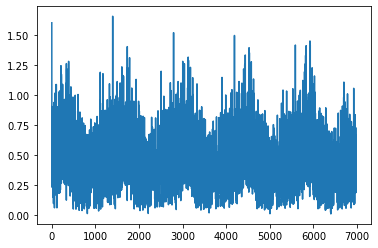

In [238]:
def train(
        input_tensor, 
        target_action, 
        target_arguments, 
        encoder, 
        action_predictor,
        argument_predictor, 
        action_lang,
        encoder_optimizer,
        action_predictor_optimizer, 
        argument_predictor_optimizer,
        criterion, 
        max_length=MAX_LENGTH,
        train_encoder=True,
        train_action_predictor=True,
        train_argument_predictor=True):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    action_predictor_optimizer.zero_grad()
    argument_predictor_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    if train_encoder:
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
    else:
        with torch.no_grad():
            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(
                    input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]
        
    if train_action_predictor:
        # Action Predictor
        action_predictor_output = action_predictor(encoder_hidden.flatten())
        topv, topi = action_predictor_output.topk(1)
        #action_predictor_output = topi.squeeze().detach()  # detach from history as input
        action_loss = criterion(action_predictor_output.unsqueeze(dim=0), target_action)
    
    if train_argument_predictor:
        # Argument Predictor
        # Without teacher forcing: use its own predictions as the next input
        target_action_one_hot = F.one_hot(target_action, num_classes=action_lang.n_words)[0]
        argument_predictor_output = argument_predictor(torch.cat((encoder_hidden.flatten(), target_action_one_hot)))
        topv, topi = argument_predictor_output.topk(1)
        #argument_predictor_output = topi.squeeze().detach()  # detach from history as input
        argument_loss = criterion(argument_predictor_output.unsqueeze(dim=0), target_arguments)
    
    if train_action_predictor and train_argument_predictor:
        loss = action_loss + argument_loss
    elif train_action_predictor:
        loss = action_loss
    elif train_argument_predictor:
        loss = argument_loss
    
    loss.backward()
    
    argument_predictor_optimizer.step()
    action_predictor_optimizer.step()
    encoder_optimizer.step()
    
    return loss.item()

hidden_size = 256
learning_rate = 0.001
epochs = 5
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_predictor = ArgumentPredictor(hidden_size+action_lang.n_words, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))
if os.path.isfile('argument_predictor.pt'):
    argument_predictor.load_state_dict(torch.load('argument_predictor.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
action_predictor_optimizer = optim.SGD(action_predictor.parameters(), lr=learning_rate)
argument_predictor_optimizer = optim.SGD(argument_predictor.parameters(), lr=learning_rate)

training_pairs = [i for i in train_low_action_argument_pairs if len(i[0]) < 30]
#print(len(max(train_low_action_argument_pairs, key=lambda item: len(item[0]))[0]))

update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for sample in training_pairs:
        update += 1
        input_tensor = tensor_from_sentence(lang, sample[0])
        target_action_tensor = tensor_from_sentence(action_lang, sample[1])[0]
        target_argument_tensor = tensor_from_sentence(argument_lang, sample[2])[0]
        
        loss = train(input_tensor, target_action_tensor, target_argument_tensor, 
                     encoder, action_predictor, argument_predictor, 
                     action_lang,
                     encoder_optimizer, action_predictor_optimizer, argument_predictor_optimizer,
                     criterion, 30, False, False, True)
        
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_predictor.state_dict(), 'action_predictor.pt')
    torch.save(argument_predictor.state_dict(), 'argument_predictor.pt')

show_plot(plot_losses)

# Action Predictor Eval

In [13]:
def evaluate(encoder, predictor, sentence, encoder_lang, action_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        predictor_output = predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        return predicted_action

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

eval_pairs = [[sample[0], sample[1]] for sample in eval_low_action_argument_pairs]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in tqdm.tqdm(eval_pairs):
    output = evaluate(encoder, action_predictor, sample[0], lang, action_lang, 45)
    #print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output} ({output == sample[1][0]})")
    results.append(output == sample[1][0])

  1%|▋                                                                              | 43/5140 [00:00<00:12, 413.46it/s]

samples: 5140


100%|█████████████████████████████████████████████████████████████████████████████| 5140/5140 [00:11<00:00, 467.19it/s]


In [14]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.941828793774319


# Eval Action / Arguments

In [39]:
def evaluate(encoder, action_predictor, argument_decoder, sentence, encoder_lang, action_decoder_lang, argument_decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action predictor
        predictor_output = action_predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        
        # Argument Decoder
        argument_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        argument_decoder_hidden = encoder_hidden
        argument_decoded_words = []
        argument_decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, argument_decoder_hidden, decoder_attention = argument_decoder(
                argument_decoder_input, argument_decoder_hidden, encoder_outputs)
            argument_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                argument_decoded_words.append('<EOS>')
                break
            else:
                argument_decoded_words.append(argument_decoder_lang.word(topi.item()))

            argument_decoder_input = topi.squeeze().detach()

        return predicted_action, argument_decoded_words

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt', map_location=torch.device('cpu')))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in tqdm.tqdm(eval_pairs):
    output = evaluate(encoder, action_predictor, argument_decoder, sample[0], lang, action_lang, argument_lang)
    
    action_expected = sample[1:][0][0]
    arguments_expected = sample[1:][1:][0]
    
    action_pred = output[0]
    argument_preds = output[1][:-1]
    
    #print(argument_preds, arguments_expected)
    
    result = action_expected == action_pred
    result &= argument_preds[0] == arguments_expected[0]
    if len(argument_preds) > 1 and len(arguments_expected) == 1:
        result = False
    if len(argument_preds) > 1 and len(arguments_expected) > 1:
        result &= argument_preds[1] == arguments_expected[1]
    #arg_result = output[1][0] == sample[2][0]
    #if len(arguments_expected) > 1:
    #    arg_result &= output[1][1] == sample[2][1]
    #print(' '.join(sample[0]), sample[1:][0], output[0][:-1], output[1][:-1])
    #results.append(output[0][0] == sample[1][0] and arg_result)
    results.append(result)

  3%|██▏                                                                            | 62/2245 [00:00<00:07, 311.08it/s]

samples: 2245


100%|█████████████████████████████████████████████████████████████████████████████| 2245/2245 [00:07<00:00, 285.92it/s]


In [40]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.5839643652561247


# Eval Action / Arguments Predictor

In [243]:
def evaluate(encoder, action_predictor, argument_predictor, sample, encoder_lang, action_lang, argument_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sample[0])
        target_action_tensor = F.one_hot(
            tensor_from_sentence(action_lang, sample[1])[0], 
            num_classes=action_lang.n_words)[0]
        target_argument_tensor = tensor_from_sentence(argument_lang, sample[2])[0]
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action predictor
        predictor_output = action_predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        
        # Argument predictor
        # Change the line below to incorporate the predicted action.
        
        argument_predictor_output = argument_predictor(torch.cat((encoder_hidden.flatten(), target_action_tensor)))
        topv, topi = argument_predictor_output.topk(2)
        predicted_argument_1 = argument_lang.word(topi[0].item())
        predicted_arguments = [predicted_argument_1]
        if sample[1][0] == 'PutObject':
            predicted_argument_2 = argument_lang.word(topi[1].item())
            predicted_arguments.append(predicted_argument_2)
        
        return predicted_action, predicted_arguments

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_predictor = ArgumentPredictor(hidden_size+action_lang.n_words, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt', map_location=torch.device('cpu')))
if os.path.isfile('argument_predictor.pt'):
    argument_predictor.load_state_dict(torch.load('argument_predictor.pt'))

eval_pairs = eval_low_action_argument_pairs
results = []
print(f"samples: {len(eval_pairs)}")
for sample in tqdm.tqdm(eval_pairs):
    output = evaluate(
        encoder, action_predictor, argument_predictor, 
        sample, 
        lang, action_lang, argument_lang,
        45)
    
    action_expected = sample[1:][0][0]
    arguments_expected = sample[1:][1:][0]
    
    action_pred = output[0]
    argument_preds = output[1]
    
    result = action_expected == action_pred
    result &= argument_preds[0] == arguments_expected[0]
    if len(argument_preds) > 1:
        result &= argument_preds[1] == arguments_expected[1]
    """
    if len(argument_preds) > 1 and len(arguments_expected) == 1:
        result = False
    if len(argument_preds) > 1 and len(arguments_expected) > 1:
        result &= argument_preds[1] == arguments_expected[1]
    """
    #arg_result = output[1][0] == sample[2][0]
    #if len(arguments_expected) > 1:
    #    arg_result &= output[1][1] == sample[2][1]
    #print(' '.join(sample[0]), sample[1:][0], output[0][:-1], output[1][:-1])
    #results.append(output[0][0] == sample[1][0] and arg_result)
    results.append(result)

  1%|▍                                                                              | 30/5140 [00:00<00:17, 288.46it/s]

samples: 5140


100%|█████████████████████████████████████████████████████████████████████████████| 5140/5140 [00:17<00:00, 296.42it/s]


In [245]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.4723735408560311


In [206]:
for i in train_low_action_argument_pairs:
    if len(i[2]) > 1:
        print(i[1], i[2])

['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
['PutObject'] ['alarmclock', 'desk']
[

['PutObject'] ['keychain', 'desk']
['PutObject'] ['keychain', 'desk']
['PutObject'] ['keychain', 'desk']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'drawer']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dresser']
['PutObject'] ['keychain', 'dr

['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', 'toiletpaperhanger']
['PutObject'] ['toiletpaper', '

['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', 'desk']
['PutObject'] ['cellphone', 'box']
['PutObject'] ['box', '

['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'armchair']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain', 'box']
['PutObject'] ['box', 'coffeetable']
['PutObject'] ['keychain

['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'mug']
['PutObject'] ['mug', 'sidetable']
['PutObject'] ['pen', 'plate']
['PutObject'] ['plate', 'coffeetable']
['PutObject'] ['pen', 'plate']
['PutObject'] ['plate', 'coffeet

['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['spoon', 'cup']
['PutObject'] ['cup', 'diningtable']
['PutObject

['PutObject'] ['butterknife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['knife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'sinkbasin']
['PutObject'] ['apple', 'fridge']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'

['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['lettuce', 'sidetable']
['PutObject'] ['knife', 'diningtable']
['PutObject'] ['lettuce', 'countertop']
['PutObject'] ['knife', 'diningtable']
['PutObject'] ['lettuce', 'countertop']
['PutObject'] ['knife', 'diningtable']
['PutObject'] ['lettuce', 'countertop']
['PutObject'] ['butterknife', 'countertop']
['PutObject'] ['l

['PutObject'] ['spoon', 'drawer']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['spoon', 'sidetable']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'countertop']
['PutObject'] ['tomato', 'c

['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'microwave']
['PutObject'] ['butterknife', 'fridge']
['PutObject'] ['bread', 'micro

['PutObject'] ['pan', 'stoveburner']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['plate', 'cabinet']
['PutObject'] ['pl

['PutObject'] ['apple', 'sidetable']
['PutObject'] ['apple', 'sidetable']
['PutObject'] ['apple', 'sidetable']
['PutObject'] ['apple', 'sidetable']
['PutObject'] ['apple', 'sidetable']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
['PutObject'] ['apple', 'sinkbasin']
[

['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'countertop']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'diningtable']
['PutObject'] ['cup', 'fridge']
['PutObject'] ['cup', 'fridge']
['PutObject'] ['cup', 'fridge']
['PutObject'] ['cup', 'fridge']

['PutObject'] ['butterknife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['potato', 'countertop']
['PutObject'] ['knife', 'countertop']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['potato', 'countertop']
['PutObject'] ['knife', 'countertop']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['potato', 'countertop']
['PutObject'] ['knife', 'countertop']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['knife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['knife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['knife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['butterknife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['butterknife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['butterknife', 'microwave']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['butterknife', 'cabinet']
['PutObject'] ['potato', 'garbagecan']
['PutObject'] ['

['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'diningtable']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject'] ['book', 'drawer']
['PutObject']

['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'dresser']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutObject'] ['cloth', 'shelf']
['PutOb

['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']
['PutObject'] ['keychain', 'sidetable']


['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'fridge']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
['PutObject'] ['potato', 'microwave']
[

['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'drawer']
['PutObject'] ['spatula', 'd

['PutObject'] ['vase', 'diningtable']
['PutObject'] ['vase', 'diningtable']
['PutObject'] ['vase', 'diningtable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['vase', 'sidetable']
['PutObject'] ['watch'